<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter08/Training_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLO
In this section, we will understand at a high level how YOLO works and the potential limitations of R-CNN-based object detection frameworks that YOLO overcomes.

In Faster R-CNN, we slide over the image using anchor boxes and identify the regions that are likely to contain an object, and then we make the bounding box corrections. However, in the fully connected layer, where only the detected region's RoI pooling output is passed as input, in the case of regions that do not fully encompass the object (where the object is beyond the boundaries of the bounding box of region proposal), the network has to guess the real boundaries of object, as it has not seen the full image (but has seen only the region proposal).  

Furthermore, Faster R-CNN is still slow, as we have two networks: the RPN and the final network that predicts classes and bounding boxes around objects.  

Here, we will understand how YOLO overcomes the limitations of Faster R-CNN, both by looking at the whole image at once as well as by having a single network to make predictions.


## Data Preperations
1. Create ground truth to train a model for a given image
    Let's consider an image with the given ground truth of bounding boxes in red:  
![yolo_1](./yolo_1.png)  
    Divide the image into N x N grid cells – for now, let's say N=3:
![yolo_2](./yolo_2.png)
    Identify those grid cells that contain the center of at least one ground truth bounding box. In our case, they are cells b1 and b3 of our 3 x 3 grid image.  

    The cell(s) where the middle point of ground truth bounding box falls is/are responsible for predicting the bounding box of the object. Let's create the ground truth corresponding to each cell.  

    The output ground truth corresponding to each cell is as follows:  
![yolo_3](yolo_3.png)

    Here, pc (the objectness score) is the probability of the cell containing an object.
    Let's understand how to calculate bx, by, bw, and bh.  

    First, we consider the grid cell (let's consider the b1 grid cell) as our universe, and normalize it to a scale between 0 and 1, as follows:
![yolo_4](yolo_4.png)

    bx and by are the locations of the mid-point of the ground truth bounding box with respect to the image (of the grid cell), as defined previously. In our case, bx = 0.5, as the mid-point of the ground truth is at a distance of 0.5 units from the origin. Similarly, by= 0.5:
![yolo_5](yolo_5.png)

    So far, we have calculated offsets from the grid cell center to the ground truth center corresponding to the object in the image.  

    bw is the ratio of the width of the bounding box with respect to the the width of the grid cell.  
    bh is the ratio of the height of the bounding box with respect to the height of the grid cell.  

    Next, we will predict the class corresponding to the grid cell. If we have three classes (c1 – truck, c2 – car, c3 – bus), we will predict the probability of the cell containing an object among any of the three classes.  
    Note that we do not need a background class here, as pc corresponds to whether the grid cell contains an object.  
    Now that we understand how to represent the output layer of each cell, let's understand how we construct the output of our 3 x 3 grid cells.

    the output of grid cell a3:  
![yolo_6](yolo_6.png)
    The output of cell a3 is as shown in the preceding screenshot. As the grid cell does not contain an object, the first output (pc – objectness score) is 0 and the remaining values do not matter as the cell does not contain the center of any ground truth bounding boxes of an object.  

    the output of grid cell b1:
![yolo_7](yolo_7.png)

    The preceding output is the way it is because the grid cell contains an object with the bx, by, bw, and bh values that were obtained in the same way as we went through earlier (in the bullet point before last), and finally the class being car resulting in c2 being 1 while c1 and c3 are 0.  
    Note that for each cell, we are able to fetch 8 outputs. Hence, for the 3 x 3 grid of cells, we fetch 3 x 3 x 8 outputs.

2. Define a model where the input is an image and the output is 3 x 3 x 8 with the ground truth being as defined in the previous step: 
![yolo_8](yolo_8.png) 

3. Define the ground truth by considering the anchor boxes   
    So far, we have been building for a scenario where the expectation is that there is only one object within a grid cell. However, in reality, there can be scenarios where there are multiple objects within the same grid cell. This would result in creating ground truths that are incorrect. Let's understand this phenomenon through the following example image:  
    ![yolo_9](yolo_9.png)
    In the preceding example, the mid-point of the ground truth bounding boxes for both the car and the person fall in the same cell – cell b1.  
    One way to avoid such a scenario is by having a grid that has more rows and columns – for example, a 19 x 19 grid. However, there can still be a scenario where an increase in the number of grid cells does not help.  
    Anchor boxes come in handy in such a scenario. Let's say we have two anchor boxes – one that has a greater height than width (corresponding to the person) and another that has a greater width than height (corresponding to the car)  
    
    ![yolo_10](yolo_10.png)
    Typically, the anchor boxes would have the grid cell center as their centers. The output for each cell in a scenario where we have two anchor boxes is represented as a concatenation of the output expected of the two anchor boxes:
    ![yolo_11](yolo_11.png)
    Here, bx, by, bw, and bh represent the offset from the anchor box (which is the universe in this scenario as seen in the image instead of the grid cell).  
    From the preceding screenshot, we see we have an output that is 3 x 3 x 16, as we have two anchors. The expected output is of the shape N x N x (num_classes + 1) x (num_anchor_boxes), where N x N is the number of cells in the grid, num_classes is the number of classes in the dataset, and num_anchor_boxes is the number of anchor boxes.

4. Now we define the loss function to train the model.

   When calculating the loss associated with the model, we need to ensure that we do not calculate the regression loss and classification loss when the objectness score is less than a certain threshold (this corresponds to the cells that do not contain an object).  
    Next, if the cell contains an object, we need to ensure that the classification across different classes is as accurate as possible. Finally, if the cell contains an object, the bounding box offsets should be as close to expected as possible. However, since the offsets of width and height can be much higher when compared to the offset of the center (as offsets of the center range between 0 and 1, while the offsets of width and height need not), we give a lower weightage to offsets of width and height by fetching a square root value. Calculate the loss of localization and classification as follows:  
    ![yolo_13](yolo_13.png)

In [2]:
import os
# if not os.path.exists('darknet'):
#     !git clone https://github.com/AlexeyAB/darknet
#     %cd darknet
#     !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
#     # !!! In case you dont have a GPU, make sure to comment out the below 3 lines !!! #
#     !sed -i 's/GPU=0/GPU=1/' Makefile
#     !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
#     !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
#     !make
#     !pip install -q torch_snippets
#     !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
#     !tar -xf open-images-bus-trucks.tar.xz
#     !rm open-images-bus-trucks.tar.xz
#     !wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [4]:
%cd darknet/
!pwd

/home/guy/workspace/study/git/guyk1971/Modern-Computer-Vision-with-PyTorch/Ch08_Adv_Obj_Det/darknet
/home/guy/workspace/study/git/guyk1971/Modern-Computer-Vision-with-PyTorch/Ch08_Adv_Obj_Det/darknet


In [5]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

 CUDA-version: 10010 (11040), GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 520, cudnn_half = 0, GPU: NVIDIA GeForce GTX TITAN X 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 

 106 conv   1024       3 x 3/ 1     19 x  19 x 512 ->   19 x  19 x1024 3.407 BF
 107 conv    512       1 x 1/ 1     19 x  19 x1024 ->   19 x  19 x 512 0.379 BF
 108 max                5x 5/ 1     19 x  19 x 512 ->   19 x  19 x 512 0.005 BF
 109 route  107 		                           ->   19 x  19 x 512 
 110 max                9x 9/ 1     19 x  19 x 512 ->   19 x  19 x 512 0.015 BF
 111 route  107 		                           ->   19 x  19 x 512 
 112 max               13x13/ 1     19 x  19 x 512 ->   19 x  19 x 512 0.031 BF
 113 route  112 110 108 107 	                   ->   19 x  19 x2048 
 114 conv    512       1 x 1/ 1     19 x  19 x2048 ->   19 x  19 x 512 0.757 BF
 115 conv   1024       3 x 3/ 1     19 x  19 x 512 ->   19 x  19 x1024 3.407 BF
 116 conv    512       1 x 1/ 1     19 x  19 x1024 ->   19 x  19 x 512 0.379 BF
 117 conv    256       1 x 1/ 1     19 x  19 x 512 ->   19 x  19 x 256 0.095 BF
 118 upsample                 2x    19 x  19 x 256 ->   38 x  38 x 256
 119 rou

In [8]:
%%writefile data/obj.names
bus
truck

Writing data/obj.names


In [9]:
%%writefile data/obj.data
classes = 2
train = data/train.txt
valid = data/val.txt
names = data/obj.names
backup = backup/

Writing data/obj.data


In [12]:
!mkdir -p data/obj
!cp -r open-images-bus-trucks/images/* data/obj/
!cp -r open-images-bus-trucks/yolo_labels/all/{train,val}.txt data/
!cp -r open-images-bus-trucks/yolo_labels/all/labels/*.txt data/obj/

In [13]:
# create a copy of existing configuration and modify it in place
!cp cfg/yolov4-tiny-custom.cfg cfg/yolov4-tiny-bus-trucks.cfg
# max_batches to 4000 (since the dataset is small enough)
!sed -i 's/max_batches = 500200/max_batches=4000/' cfg/yolov4-tiny-bus-trucks.cfg
# number of sub-batches per batch
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov4-tiny-bus-trucks.cfg
# number of batches after which learning rate is decayed
!sed -i 's/steps=400000,450000/steps=3200,3600/' cfg/yolov4-tiny-bus-trucks.cfg
# number of classes is 2 as opposed to 80 (which is the number of COCO classes)
!sed -i 's/classes=80/classes=2/g' cfg/yolov4-tiny-bus-trucks.cfg
# in the classification and regression heads, change number of output convolution filters
# from 255 -> 21 and 57 -> 33, since we have fewer classes we don't need as many filters
!sed -i 's/filters=255/filters=21/g' cfg/yolov4-tiny-bus-trucks.cfg
!sed -i 's/filters=57/filters=33/g' cfg/yolov4-tiny-bus-trucks.cfg

In [14]:
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
!cp yolov4-tiny.conv.29 build/darknet/x64/

In [15]:
!./darknet detector train data/obj.data cfg/yolov4-tiny-bus-trucks.cfg yolov4-tiny.conv.29 -dont_show -mapLastAt

 CUDA-version: 10010 (11040), GPU count: 1  
 OpenCV version: 4.2.0
yolov4-tiny-bus-trucks
 0 : compute_capability = 520, cudnn_half = 0, GPU: NVIDIA GeForce GTX TITAN X 
net.optimized_memory = 0 
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           -> 

 total_bbox = 55, rewritten_bbox = 0.000000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.231515), count: 7, class_loss = 141.813614, iou_loss = 0.055084, total_loss = 141.868698 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.403591), count: 2, class_loss = 605.219910, iou_loss = 0.940491, total_loss = 606.160400 
 total_bbox = 64, rewritten_bbox = 0.000000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.286069), count: 6, class_loss = 141.312454, iou_loss = 0.110886, total_loss = 141.423340 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.532544), count: 1, class_loss = 604.870300, iou_loss = 0.248169, total_loss = 605.118469 
 total_bbox = 71, rewritten_bbox = 0.000000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.306073), count: 4, class_loss = 139.858932, iou_loss = 0.055756, total_loss = 139.914688 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.390364), count: 4, class_loss = 140.481918, iou_loss = 0.132248, total_loss = 140.614166 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.393734), count: 2, class_loss = 605.207947, iou_loss = 0.618652, total_loss = 605.826599 
 total_bbox = 161, rewritten_bbox = 0.000000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.198243), count: 4, class_loss = 139.417145, iou_loss = 0.020126, total_loss = 139.437271 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 604.597778, iou_loss = 0.000000, total_loss = 604.597778 
 total_bbox = 165, rewritten_bbox = 0.000000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.253847), count: 3, class_loss = 141.047882, iou_loss = 0.036850, total_loss = 141.084732 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.221072), count: 5, class_loss = 143.296677, iou_loss = 0.029160, total_loss = 143.325836 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.175105), count: 2, class_loss = 604.566406, iou_loss = 0.057312, total_loss = 604.623718 
 total_bbox = 275, rewritten_bbox = 0.000000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.137925), count: 3, class_loss = 140.743591, iou_loss = 0.001907, total_loss = 140.745499 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.153847), count: 1, class_loss = 603.200195, iou_loss = 0.019958, total_loss = 603.220154 
 total_bbox = 279, rewritten_bbox = 0.000000 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.235435), count: 4, class_loss = 142.520615, iou_loss = 0.120148, total_loss = 142.640762 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1

 total_bbox = 382, rewritten_bbox = 0.261780 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.300406), count: 4, class_loss = 141.166489, iou_loss = 0.011383, total_loss = 141.177872 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.110123), count: 1, class_loss = 603.067200, iou_loss = 0.017517, total_loss = 603.084717 
 total_bbox = 387, rewritten_bbox = 0.258398 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.268191), count: 5, class_loss = 141.137955, iou_loss = 0.044540, total_loss = 141.182495 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 602.048279, iou_loss = 0.000000, total_loss = 602.048279 
 total_bbox = 392, rewritten_bbox = 0.255102 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.407586), count: 3, class_loss = 140.259048, iou_loss = 0.083771, total_loss = 140.3428

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.279178), count: 4, class_loss = 141.982697, iou_loss = 0.016907, total_loss = 141.999603 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.180548), count: 1, class_loss = 602.697754, iou_loss = 0.188110, total_loss = 602.885864 
 total_bbox = 498, rewritten_bbox = 0.200803 % 
]2;6/4000: loss=373.0 hours left=1.3
 6: 373.000153, 372.611908 avg loss, 0.000000 rate, 1.030845 seconds, 384 images, 1.300294 hours left
Loaded: 0.000023 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.123182), count: 3, class_loss = 139.960785, iou_loss = 0.002029, total_loss = 139.962814 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.191986), count: 1, class_loss = 604.711243, iou_loss = 0.029175, total_loss = 604.740417 
 total_bbox = 502, rewritten_bbox = 0.199203 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, c

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.254127), count: 4, class_loss = 140.590363, iou_loss = 0.010086, total_loss = 140.600449 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.238020), count: 2, class_loss = 605.362061, iou_loss = 0.170654, total_loss = 605.532715 
 total_bbox = 614, rewritten_bbox = 0.162866 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.211866), count: 4, class_loss = 140.493668, iou_loss = 0.030182, total_loss = 140.523849 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 602.929932, iou_loss = 0.000000, total_loss = 602.929932 
 total_bbox = 618, rewritten_bbox = 0.161812 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.187456), count: 4, class_loss = 140.040573, iou_loss = 0.005768, total_loss = 140.046341 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.190817), count: 4, class_loss = 139.737030, iou_loss = 0.007812, total_loss = 139.744843 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 605.518799, iou_loss = 0.000000, total_loss = 605.518799 
 total_bbox = 715, rewritten_bbox = 0.279720 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.264084), count: 5, class_loss = 140.980118, iou_loss = 0.053452, total_loss = 141.033569 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 605.820862, iou_loss = 0.000000, total_loss = 605.820862 
 total_bbox = 720, rewritten_bbox = 0.277778 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.277043), count: 6, class_loss = 139.219360, iou_loss = 0.141571, total_loss = 139.360931 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.289677), count: 4, class_loss = 142.368805, iou_loss = 0.044174, total_loss = 142.412979 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.433581), count: 2, class_loss = 602.590393, iou_loss = 0.435181, total_loss = 603.025574 
 total_bbox = 829, rewritten_bbox = 0.241255 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.143015), count: 1, class_loss = 141.553116, iou_loss = 0.001617, total_loss = 141.554733 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.269658), count: 3, class_loss = 604.218750, iou_loss = 0.549988, total_loss = 604.768738 
 total_bbox = 833, rewritten_bbox = 0.240096 % 
]2;10/4000: loss=372.4 hours left=1.3
 10: 372.406921, 372.557251 avg loss, 0.000000 rate, 1.028871 seconds, 640 images, 1.294018 hours left
Loaded: 0.000031 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.372727), count: 4, class_loss = 139.647644, iou_loss = 0.122116, total_loss = 139.769760 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 600.609619, iou_loss = 0.000000, total_loss = 600.609619 
 total_bbox = 931, rewritten_bbox = 0.214823 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.135162), count: 4, class_loss = 142.439346, iou_loss = 0.001358, total_loss = 142.440704 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 603.557251, iou_loss = 0.000000, total_loss = 603.557251 
 total_bbox = 935, rewritten_bbox = 0.213904 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.335636), count: 3, class_loss = 138.710632, iou_loss = 0.003128, total_loss = 138.713760 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.201269), count: 4, class_loss = 140.788605, iou_loss = 0.003540, total_loss = 140.792145 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 604.364380, iou_loss = 0.000000, total_loss = 604.364380 
 total_bbox = 1032, rewritten_bbox = 0.290698 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.087389), count: 3, class_loss = 142.406250, iou_loss = 0.000488, total_loss = 142.406738 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.384571), count: 4, class_loss = 605.902832, iou_loss = 1.091675, total_loss = 606.994507 
 total_bbox = 1039, rewritten_bbox = 0.288739 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.201069), count: 4, class_loss = 142.706558, iou_loss = 0.032166, total_loss = 142.738724 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.314329), count: 5, class_loss = 137.603622, iou_loss = 0.036072, total_loss = 137.639694 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 601.834473, iou_loss = 0.000000, total_loss = 601.834473 
 total_bbox = 1150, rewritten_bbox = 0.347826 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.408042), count: 4, class_loss = 139.870651, iou_loss = 0.066498, total_loss = 139.937149 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.340059), count: 2, class_loss = 605.522888, iou_loss = 0.368835, total_loss = 605.891724 
 total_bbox = 1156, rewritten_bbox = 0.346021 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.252121), count: 2, class_loss = 137.179840, iou_loss = 0.002243, total_loss = 137.182083 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.245758), count: 4, class_loss = 142.522552, iou_loss = 0.036255, total_loss = 142.558807 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 605.287537, iou_loss = 0.000000, total_loss = 605.287537 
 total_bbox = 1244, rewritten_bbox = 0.321543 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.253972), count: 4, class_loss = 138.925644, iou_loss = 0.006454, total_loss = 138.932098 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 606.401733, iou_loss = 0.000000, total_loss = 606.401733 
 total_bbox = 1248, rewritten_bbox = 0.320513 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.191820), count: 4, class_loss = 140.538773, iou_loss = 0.003235, total_loss = 140.542007 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.344193), count: 4, class_loss = 139.772461, iou_loss = 0.040222, total_loss = 139.812683 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 603.327271, iou_loss = 0.000000, total_loss = 603.327271 
 total_bbox = 1353, rewritten_bbox = 0.295639 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.161923), count: 4, class_loss = 142.172974, iou_loss = 0.002151, total_loss = 142.175125 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 600.888062, iou_loss = 0.000000, total_loss = 600.888062 
 total_bbox = 1357, rewritten_bbox = 0.294768 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.221194), count: 6, class_loss = 142.664932, iou_loss = 0.068558, total_loss = 142.733490 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.260916), count: 5, class_loss = 139.534103, iou_loss = 0.033920, total_loss = 139.568024 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 605.273560, iou_loss = 0.000000, total_loss = 605.273560 
 total_bbox = 1455, rewritten_bbox = 0.343643 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.332735), count: 3, class_loss = 143.074768, iou_loss = 0.014053, total_loss = 143.088821 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.402813), count: 1, class_loss = 603.578979, iou_loss = 0.448547, total_loss = 604.027527 
 total_bbox = 1459, rewritten_bbox = 0.342700 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.301583), count: 4, class_loss = 141.537476, iou_loss = 0.004364, total_loss = 141.541840 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.266989), count: 4, class_loss = 141.265625, iou_loss = 0.011978, total_loss = 141.277603 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.477981), count: 1, class_loss = 607.699097, iou_loss = 0.181458, total_loss = 607.880554 
 total_bbox = 1550, rewritten_bbox = 0.322581 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.144046), count: 4, class_loss = 139.826385, iou_loss = 0.037170, total_loss = 139.863556 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 602.884705, iou_loss = 0.000000, total_loss = 602.884705 
 total_bbox = 1554, rewritten_bbox = 0.321750 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.482404), count: 3, class_loss = 140.045471, iou_loss = 0.060196, total_loss = 140.105667 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.234311), count: 4, class_loss = 139.710403, iou_loss = 0.011703, total_loss = 139.722107 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 604.378845, iou_loss = 0.000000, total_loss = 604.378845 
 total_bbox = 1652, rewritten_bbox = 0.302663 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.180017), count: 3, class_loss = 141.339661, iou_loss = 0.003082, total_loss = 141.342743 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.282458), count: 1, class_loss = 602.548950, iou_loss = 0.093689, total_loss = 602.642639 
 total_bbox = 1656, rewritten_bbox = 0.301932 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.471810), count: 4, class_loss = 139.993088, iou_loss = 0.053604, total_loss = 140.046692 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.134125), count: 4, class_loss = 140.429016, iou_loss = 0.012909, total_loss = 140.441925 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 602.634644, iou_loss = 0.000000, total_loss = 602.634644 
 total_bbox = 1751, rewritten_bbox = 0.285551 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.356940), count: 6, class_loss = 141.648056, iou_loss = 0.101669, total_loss = 141.749725 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 600.433411, iou_loss = 0.000000, total_loss = 600.433411 
 total_bbox = 1757, rewritten_bbox = 0.284576 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.263558), count: 4, class_loss = 142.301910, iou_loss = 0.040970, total_loss = 142.342880 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.139690), count: 4, class_loss = 140.166092, iou_loss = 0.002441, total_loss = 140.168533 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 602.879211, iou_loss = 0.000000, total_loss = 602.879211 
 total_bbox = 1848, rewritten_bbox = 0.324675 % 
]2;23/4000: loss=372.0 hours left=1.3
 23: 371.971588, 372.460419 avg loss, 0.000000 rate, 1.028048 seconds, 1472 images, 1.274957 hours left
Loaded: 0.000023 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.403766), count: 5, class_loss = 140.342468, iou_loss = 0.177521, total_loss = 140.519989 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 602.713501, iou_loss = 0.000000, total_loss = 602.713501 
 total_bbox = 1853, rewritten_bbox = 0.323799 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.120953), count: 3, class_loss = 138.898422, iou_loss = 0.001114, total_loss = 138.899536 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.350882), count: 1, class_loss = 603.893555, iou_loss = 0.053772, total_loss = 603.947327 
 total_bbox = 1950, rewritten_bbox = 0.307692 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.200012), count: 4, class_loss = 140.268677, iou_loss = 0.004013, total_loss = 140.272690 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 601.269775, iou_loss = 0.000000, total_loss = 601.269775 
 total_bbox = 1954, rewritten_bbox = 0.307062 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.193949), count: 3, class_loss = 141.136719, iou_loss = 0.008408, total_loss = 141.145126 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.218469), count: 3, class_loss = 140.107590, iou_loss = 0.006622, total_loss = 140.114212 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.552131), count: 1, class_loss = 602.418457, iou_loss = 0.967834, total_loss = 603.386292 
 total_bbox = 2051, rewritten_bbox = 0.292540 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.173436), count: 7, class_loss = 141.637573, iou_loss = 0.020752, total_loss = 141.658325 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.501085), count: 1, class_loss = 604.638550, iou_loss = 0.703186, total_loss = 605.341736 
 total_bbox = 2059, rewritten_bbox = 0.291404 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.124665), count: 4, class_loss = 140.942062, iou_loss = 0.005875, total_loss = 140.947937 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.244236), count: 4, class_loss = 139.485825, iou_loss = 0.003571, total_loss = 139.489395 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.161891), count: 2, class_loss = 602.821777, iou_loss = 0.023621, total_loss = 602.845398 
 total_bbox = 2154, rewritten_bbox = 0.278552 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.231547), count: 3, class_loss = 141.037460, iou_loss = 0.032669, total_loss = 141.070129 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.307083), count: 2, class_loss = 602.306213, iou_loss = 0.173584, total_loss = 602.479797 
 total_bbox = 2159, rewritten_bbox = 0.277906 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.310723), count: 4, class_loss = 142.067123, iou_loss = 0.076538, total_loss = 142.143661 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.140587), count: 4, class_loss = 141.642944, iou_loss = 0.001678, total_loss = 141.644623 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.158848), count: 2, class_loss = 600.071899, iou_loss = 0.025330, total_loss = 600.097229 
 total_bbox = 2251, rewritten_bbox = 0.266548 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.271857), count: 3, class_loss = 140.364227, iou_loss = 0.089828, total_loss = 140.454056 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.097744), count: 1, class_loss = 601.180664, iou_loss = 0.796570, total_loss = 601.977234 
 total_bbox = 2255, rewritten_bbox = 0.266075 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.198887), count: 3, class_loss = 142.759415, iou_loss = 0.034302, total_loss = 142.793716 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.167322), count: 3, class_loss = 139.613861, iou_loss = 0.008347, total_loss = 139.622208 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.230954), count: 4, class_loss = 598.088379, iou_loss = 0.789368, total_loss = 598.877747 
 total_bbox = 2360, rewritten_bbox = 0.254237 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.321652), count: 4, class_loss = 141.957062, iou_loss = 0.171661, total_loss = 142.128723 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.283505), count: 6, class_loss = 607.002014, iou_loss = 3.408813, total_loss = 610.410828 
 total_bbox = 2370, rewritten_bbox = 0.253165 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.188232), count: 4, class_loss = 138.964233, iou_loss = 0.011246, total_loss = 138.975479 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.357739), count: 4, class_loss = 142.236771, iou_loss = 0.054138, total_loss = 142.290909 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 602.513184, iou_loss = 0.000000, total_loss = 602.513184 
 total_bbox = 2472, rewritten_bbox = 0.242718 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.291165), count: 2, class_loss = 138.304443, iou_loss = 0.002472, total_loss = 138.306915 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.279133), count: 3, class_loss = 603.525635, iou_loss = 0.286194, total_loss = 603.811829 
 total_bbox = 2477, rewritten_bbox = 0.242229 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.259741), count: 4, class_loss = 139.654587, iou_loss = 0.007599, total_loss = 139.662186 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.339512), count: 4, class_loss = 138.563553, iou_loss = 0.102600, total_loss = 138.666153 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 602.226135, iou_loss = 0.000000, total_loss = 602.226135 
 total_bbox = 2569, rewritten_bbox = 0.233554 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.166647), count: 3, class_loss = 137.884476, iou_loss = 0.002151, total_loss = 137.886627 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.406867), count: 1, class_loss = 606.506714, iou_loss = 0.192139, total_loss = 606.698853 
 total_bbox = 2573, rewritten_bbox = 0.233191 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.212168), count: 4, class_loss = 141.289703, iou_loss = 0.003830, total_loss = 141.293533 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.348466), count: 6, class_loss = 142.192780, iou_loss = 0.063629, total_loss = 142.256409 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.241282), count: 1, class_loss = 603.087219, iou_loss = 0.019104, total_loss = 603.106323 
 total_bbox = 2665, rewritten_bbox = 0.225141 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.097606), count: 3, class_loss = 139.731354, iou_loss = 0.008865, total_loss = 139.740219 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.070228), count: 1, class_loss = 600.738831, iou_loss = 0.005310, total_loss = 600.744141 
 total_bbox = 2669, rewritten_bbox = 0.224803 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.331640), count: 4, class_loss = 140.527588, iou_loss = 0.014221, total_loss = 140.541809 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.238659), count: 3, class_loss = 139.640839, iou_loss = 0.053207, total_loss = 139.694046 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.334595), count: 2, class_loss = 601.529846, iou_loss = 0.517212, total_loss = 602.047058 
 total_bbox = 2763, rewritten_bbox = 0.217155 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.118486), count: 3, class_loss = 143.252136, iou_loss = 0.007065, total_loss = 143.259201 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.208888), count: 2, class_loss = 604.035767, iou_loss = 0.051941, total_loss = 604.087708 
 total_bbox = 2768, rewritten_bbox = 0.216763 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.150048), count: 4, class_loss = 141.309723, iou_loss = 0.001358, total_loss = 141.311081 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.342922), count: 5, class_loss = 139.567764, iou_loss = 0.131210, total_loss = 139.698975 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.325968), count: 3, class_loss = 601.194397, iou_loss = 0.569092, total_loss = 601.763489 
 total_bbox = 2867, rewritten_bbox = 0.209278 % 
]2;36/4000: loss=371.4 hours left=1.3
 36: 371.377441, 372.042450 avg loss, 0.000000 rate, 1.029040 seconds, 2304 images, 1.257780 hours left
Loaded: 0.000023 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.129334), count: 4, class_loss = 141.314697, iou_loss = 0.007324, total_loss = 141.322021 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 599.342957, iou_loss = 0.000000, total_loss = 599.342957 
 total_bbox = 2871, rewritten_bbox = 0.208986 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.276236), count: 5, class_loss = 139.691269, iou_loss = 0.053482, total_loss = 139.744751 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 603.005188, iou_loss = 0.000000, total_loss = 603.005188 
 total_bbox = 2963, rewritten_bbox = 0.202497 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.140373), count: 3, class_loss = 140.161606, iou_loss = 0.002319, total_loss = 140.163925 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.341096), count: 1, class_loss = 600.435364, iou_loss = 0.166870, total_loss = 600.602234 
 total_bbox = 2967, rewritten_bbox = 0.202224 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.156857), count: 3, class_loss = 139.521194, iou_loss = 0.026505, total_loss = 139.547699 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.124718), count: 3, class_loss = 138.853241, iou_loss = 0.005646, total_loss = 138.858887 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 602.831543, iou_loss = 0.000000, total_loss = 602.831543 
 total_bbox = 3059, rewritten_bbox = 0.196143 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.280656), count: 4, class_loss = 139.816162, iou_loss = 0.005295, total_loss = 139.821457 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 601.454529, iou_loss = 0.000000, total_loss = 601.454529 
 total_bbox = 3063, rewritten_bbox = 0.195886 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.196116), count: 4, class_loss = 140.155090, iou_loss = 0.009644, total_loss = 140.164734 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.354429), count: 1, class_loss = 140.463440, iou_loss = 0.000992, total_loss = 140.464432 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.181998), count: 3, class_loss = 599.652405, iou_loss = 0.302124, total_loss = 599.954529 
 total_bbox = 3165, rewritten_bbox = 0.189573 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.315968), count: 5, class_loss = 139.809601, iou_loss = 0.044189, total_loss = 139.853790 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 601.039734, iou_loss = 0.000000, total_loss = 601.039734 
 total_bbox = 3170, rewritten_bbox = 0.189274 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.357588), count: 4, class_loss = 139.598312, iou_loss = 0.029327, total_loss = 139.627640 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.479148), count: 5, class_loss = 141.168549, iou_loss = 0.069534, total_loss = 141.238083 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 600.431519, iou_loss = 0.000000, total_loss = 600.431519 
 total_bbox = 3273, rewritten_bbox = 0.183318 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.192192), count: 4, class_loss = 139.606842, iou_loss = 0.060287, total_loss = 139.667130 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.128805), count: 1, class_loss = 605.821472, iou_loss = 0.015076, total_loss = 605.836548 
 total_bbox = 3278, rewritten_bbox = 0.183038 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.284725), count: 4, class_loss = 138.131897, iou_loss = 0.029358, total_loss = 138.161255 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.154936), count: 3, class_loss = 140.558197, iou_loss = 0.001343, total_loss = 140.559540 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.290969), count: 1, class_loss = 599.215942, iou_loss = 0.075623, total_loss = 599.291565 
 total_bbox = 3382, rewritten_bbox = 0.177410 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.175925), count: 5, class_loss = 140.579300, iou_loss = 0.006851, total_loss = 140.586151 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 600.378723, iou_loss = 0.000000, total_loss = 600.378723 
 total_bbox = 3387, rewritten_bbox = 0.177148 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.207785), count: 3, class_loss = 139.531998, iou_loss = 0.002533, total_loss = 139.534531 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.219358), count: 4, class_loss = 136.761200, iou_loss = 0.003723, total_loss = 136.764923 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.365014), count: 1, class_loss = 600.375244, iou_loss = 0.497803, total_loss = 600.873047 
 total_bbox = 3482, rewritten_bbox = 0.172315 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.206377), count: 5, class_loss = 139.454437, iou_loss = 0.013535, total_loss = 139.467972 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 599.754272, iou_loss = 0.000000, total_loss = 599.754272 
 total_bbox = 3487, rewritten_bbox = 0.172068 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.186298), count: 3, class_loss = 139.346329, iou_loss = 0.099213, total_loss = 139.445541 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.261329), count: 3, class_loss = 139.618896, iou_loss = 0.005676, total_loss = 139.624573 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 598.408875, iou_loss = 0.000000, total_loss = 598.408875 
 total_bbox = 3589, rewritten_bbox = 0.167177 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.185863), count: 4, class_loss = 139.436935, iou_loss = 0.039078, total_loss = 139.476013 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 596.785522, iou_loss = 0.000000, total_loss = 596.785522 
 total_bbox = 3593, rewritten_bbox = 0.166991 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.237653), count: 6, class_loss = 140.297653, iou_loss = 0.012619, total_loss = 140.310272 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.138002), count: 5, class_loss = 141.369598, iou_loss = 0.015350, total_loss = 141.384949 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 599.510193, iou_loss = 0.000000, total_loss = 599.510193 
 total_bbox = 3690, rewritten_bbox = 0.162602 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.228026), count: 5, class_loss = 141.517838, iou_loss = 0.036758, total_loss = 141.554596 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.197734), count: 1, class_loss = 599.198547, iou_loss = 0.068115, total_loss = 599.266663 
 total_bbox = 3696, rewritten_bbox = 0.162338 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.266911), count: 3, class_loss = 140.233093, iou_loss = 0.022995, total_loss = 140.256088 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.100889), count: 1, class_loss = 137.953217, iou_loss = 0.000183, total_loss = 137.953400 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.395909), count: 1, class_loss = 598.763245, iou_loss = 0.068054, total_loss = 598.831299 
 total_bbox = 3791, rewritten_bbox = 0.158270 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.181467), count: 6, class_loss = 138.744843, iou_loss = 0.032104, total_loss = 138.776947 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 596.662659, iou_loss = 0.000000, total_loss = 596.662659 
 total_bbox = 3797, rewritten_bbox = 0.158019 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.205602), count: 3, class_loss = 140.880005, iou_loss = 0.016968, total_loss = 140.896973 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.424218), count: 3, class_loss = 141.636276, iou_loss = 0.008713, total_loss = 141.644989 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.180178), count: 1, class_loss = 596.323853, iou_loss = 0.036499, total_loss = 596.360352 
 total_bbox = 3909, rewritten_bbox = 0.153492 % 
]2;49/4000: loss=367.5 hours left=1.2
 49: 367.539215, 370.083496 avg loss, 0.000000 rate, 1.038680 seconds, 3136 images, 1.242796 hours left
Loaded: 0.000027 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.183865), count: 4, class_loss = 139.614380, iou_loss = 0.001892, total_loss = 139.616272 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 597.307190, iou_loss = 0.000000, total_loss = 597.307190 
 total_bbox = 3913, rewritten_bbox = 0.153335 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.266737), count: 4, class_loss = 139.146866, iou_loss = 0.024292, total_loss = 139.171158 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.235761), count: 1, class_loss = 592.666809, iou_loss = 0.035950, total_loss = 592.702759 
 total_bbox = 4007, rewritten_bbox = 0.149738 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.269728), count: 5, class_loss = 138.658539, iou_loss = 0.018036, total_loss = 138.676575 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 593.560486, iou_loss = 0.000000, total_loss = 593.560486 
 total_bbox = 4012, rewritten_bbox = 0.149551 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.398565), count: 4, class_loss = 139.436844, iou_loss = 0.086533, total_loss = 139.523376 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.241888), count: 4, class_loss = 136.691772, iou_loss = 0.023148, total_loss = 136.714920 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.111823), count: 1, class_loss = 594.664490, iou_loss = 0.011353, total_loss = 594.675842 
 total_bbox = 4118, rewritten_bbox = 0.145702 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.275372), count: 4, class_loss = 139.496857, iou_loss = 0.030136, total_loss = 139.526993 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.609215), count: 1, class_loss = 595.242310, iou_loss = 0.227722, total_loss = 595.470032 
 total_bbox = 4123, rewritten_bbox = 0.145525 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.204402), count: 3, class_loss = 136.301682, iou_loss = 0.002365, total_loss = 136.304047 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.192557), count: 2, class_loss = 136.603455, iou_loss = 0.015137, total_loss = 136.618591 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.327805), count: 2, class_loss = 591.320618, iou_loss = 0.248108, total_loss = 591.568726 
 total_bbox = 4221, rewritten_bbox = 0.142146 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.203086), count: 4, class_loss = 138.925613, iou_loss = 0.014877, total_loss = 138.940491 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.214107), count: 1, class_loss = 593.198120, iou_loss = 0.022705, total_loss = 593.220825 
 total_bbox = 4226, rewritten_bbox = 0.141978 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.190023), count: 4, class_loss = 139.116943, iou_loss = 0.013336, total_loss = 139.130280 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.429531), count: 2, class_loss = 137.329086, iou_loss = 0.048843, total_loss = 137.377930 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.389415), count: 2, class_loss = 587.553101, iou_loss = 0.692871, total_loss = 588.245972 
 total_bbox = 4316, rewritten_bbox = 0.139018 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.294034), count: 4, class_loss = 138.258148, iou_loss = 0.332489, total_loss = 138.590637 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.163270), count: 2, class_loss = 590.594360, iou_loss = 0.028076, total_loss = 590.622437 
 total_bbox = 4322, rewritten_bbox = 0.138825 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.332479), count: 5, class_loss = 138.505844, iou_loss = 0.015656, total_loss = 138.521500 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.500106), count: 3, class_loss = 136.521591, iou_loss = 0.028549, total_loss = 136.550140 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.100208), count: 1, class_loss = 585.966675, iou_loss = 0.003235, total_loss = 585.969910 
 total_bbox = 4423, rewritten_bbox = 0.135655 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.215409), count: 5, class_loss = 139.557312, iou_loss = 0.037018, total_loss = 139.594330 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 588.067383, iou_loss = 0.000000, total_loss = 588.067383 
 total_bbox = 4428, rewritten_bbox = 0.135501 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.317046), count: 4, class_loss = 137.667084, iou_loss = 0.038452, total_loss = 137.705536 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.290785), count: 4, class_loss = 136.159637, iou_loss = 0.015839, total_loss = 136.175476 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 589.465942, iou_loss = 0.000000, total_loss = 589.465942 
 total_bbox = 4529, rewritten_bbox = 0.132480 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.270707), count: 6, class_loss = 136.505676, iou_loss = 0.009171, total_loss = 136.514847 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 587.694946, iou_loss = 0.000000, total_loss = 587.694946 
 total_bbox = 4535, rewritten_bbox = 0.132304 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.258945), count: 5, class_loss = 138.765076, iou_loss = 0.016006, total_loss = 138.781082 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.450766), count: 5, class_loss = 135.772308, iou_loss = 0.073395, total_loss = 135.845703 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 584.481018, iou_loss = 0.000000, total_loss = 584.481018 
 total_bbox = 4630, rewritten_bbox = 0.129590 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.343608), count: 5, class_loss = 136.361084, iou_loss = 0.041077, total_loss = 136.402161 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 582.866943, iou_loss = 0.000000, total_loss = 582.866943 
 total_bbox = 4635, rewritten_bbox = 0.129450 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.394915), count: 4, class_loss = 136.578888, iou_loss = 0.019943, total_loss = 136.598831 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.147495), count: 4, class_loss = 136.777542, iou_loss = 0.001007, total_loss = 136.778549 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 582.681641, iou_loss = 0.000000, total_loss = 582.681641 
 total_bbox = 4729, rewritten_bbox = 0.126877 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.294621), count: 6, class_loss = 136.877716, iou_loss = 0.019974, total_loss = 136.897690 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 582.185913, iou_loss = 0.000000, total_loss = 582.185913 
 total_bbox = 4735, rewritten_bbox = 0.126716 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.139689), count: 4, class_loss = 135.386215, iou_loss = 0.012833, total_loss = 135.399048 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.229873), count: 4, class_loss = 135.948441, iou_loss = 0.010132, total_loss = 135.958572 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 579.755005, iou_loss = 0.000000, total_loss = 579.755005 
 total_bbox = 4833, rewritten_bbox = 0.124146 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.238913), count: 2, class_loss = 135.756287, iou_loss = 0.006760, total_loss = 135.763046 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.149836), count: 3, class_loss = 577.485046, iou_loss = 2.194702, total_loss = 579.679749 
 total_bbox = 4838, rewritten_bbox = 0.124018 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.409781), count: 4, class_loss = 134.223602, iou_loss = 0.020248, total_loss = 134.243851 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.222196), count: 3, class_loss = 134.376923, iou_loss = 0.030304, total_loss = 134.407227 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.313557), count: 3, class_loss = 578.243286, iou_loss = 0.496643, total_loss = 578.739929 
 total_bbox = 4935, rewritten_bbox = 0.121581 % 
]2;62/4000: loss=356.7 hours left=1.2
 62: 356.674591, 363.511963 avg loss, 0.000000 rate, 1.038342 seconds, 3968 images, 1.229977 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.330593), count: 2, class_loss = 135.907013, iou_loss = 0.065063, total_loss = 135.972076 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.255833), count: 2, class_loss = 576.074707, iou_loss = 0.476868, total_loss = 576.551575 
 total_bbox = 4939, rewritten_bbox = 0.121482 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.114902), count: 5, class_loss = 132.691254, iou_loss = 0.002319, total_loss = 132.693573 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 576.606262, iou_loss = 0.000000, total_loss = 576.606262 
 total_bbox = 5048, rewritten_bbox = 0.138669 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.309856), count: 4, class_loss = 133.385605, iou_loss = 0.069916, total_loss = 133.455521 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.515904), count: 2, class_loss = 574.282776, iou_loss = 1.247131, total_loss = 575.529907 
 total_bbox = 5054, rewritten_bbox = 0.138504 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.304203), count: 5, class_loss = 134.952072, iou_loss = 0.007462, total_loss = 134.959534 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.221837), count: 4, class_loss = 135.399536, iou_loss = 0.003616, total_loss = 135.403152 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 570.310730, iou_loss = 0.000000, total_loss = 570.310730 
 total_bbox = 5160, rewritten_bbox = 0.135659 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.259937), count: 4, class_loss = 132.587463, iou_loss = 0.133774, total_loss = 132.721237 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.193474), count: 1, class_loss = 571.404358, iou_loss = 2.925903, total_loss = 574.330261 
 total_bbox = 5165, rewritten_bbox = 0.135528 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.287086), count: 3, class_loss = 133.061111, iou_loss = 0.005585, total_loss = 133.066696 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.214041), count: 4, class_loss = 134.339539, iou_loss = 0.005859, total_loss = 134.345398 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.481213), count: 1, class_loss = 566.054565, iou_loss = 0.521423, total_loss = 566.575989 
 total_bbox = 5267, rewritten_bbox = 0.132903 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.447944), count: 5, class_loss = 135.261154, iou_loss = 0.045547, total_loss = 135.306702 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 567.573792, iou_loss = 0.000000, total_loss = 567.573792 
 total_bbox = 5271, rewritten_bbox = 0.132802 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.540149), count: 3, class_loss = 132.909134, iou_loss = 0.017578, total_loss = 132.926712 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.263585), count: 3, class_loss = 132.258835, iou_loss = 0.006790, total_loss = 132.265625 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.157767), count: 2, class_loss = 564.261353, iou_loss = 0.028320, total_loss = 564.289673 
 total_bbox = 5351, rewritten_bbox = 0.130817 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.135272), count: 4, class_loss = 131.063599, iou_loss = 0.007690, total_loss = 131.071289 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 560.430542, iou_loss = 0.000000, total_loss = 560.430542 
 total_bbox = 5355, rewritten_bbox = 0.130719 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.352385), count: 3, class_loss = 132.164703, iou_loss = 0.043610, total_loss = 132.208313 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.077500), count: 1, class_loss = 128.271606, iou_loss = 0.001709, total_loss = 128.273315 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.338826), count: 2, class_loss = 558.592590, iou_loss = 0.448242, total_loss = 559.040833 
 total_bbox = 5443, rewritten_bbox = 0.128606 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.285452), count: 3, class_loss = 129.978241, iou_loss = 0.026520, total_loss = 130.004761 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 560.984436, iou_loss = 0.000000, total_loss = 560.984436 
 total_bbox = 5446, rewritten_bbox = 0.128535 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.314022), count: 3, class_loss = 127.806679, iou_loss = 0.105827, total_loss = 127.912506 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.300437), count: 7, class_loss = 132.704254, iou_loss = 0.135742, total_loss = 132.839996 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.141611), count: 1, class_loss = 556.634827, iou_loss = 0.004761, total_loss = 556.639587 
 total_bbox = 5541, rewritten_bbox = 0.162426 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.344347), count: 5, class_loss = 129.711563, iou_loss = 0.109238, total_loss = 129.820801 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.097654), count: 1, class_loss = 556.476929, iou_loss = 0.008362, total_loss = 556.485291 
 total_bbox = 5547, rewritten_bbox = 0.162250 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.350888), count: 3, class_loss = 131.949738, iou_loss = 0.008652, total_loss = 131.958389 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.114585), count: 4, class_loss = 129.611328, iou_loss = 0.001541, total_loss = 129.612869 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 550.081299, iou_loss = 0.000000, total_loss = 550.081299 
 total_bbox = 5648, rewritten_bbox = 0.159348 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.143216), count: 3, class_loss = 130.586334, iou_loss = 0.000977, total_loss = 130.587311 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 549.194214, iou_loss = 0.000000, total_loss = 549.194214 
 total_bbox = 5651, rewritten_bbox = 0.159264 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.289111), count: 6, class_loss = 129.732407, iou_loss = 0.097153, total_loss = 129.829559 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.282357), count: 7, class_loss = 129.858490, iou_loss = 0.190857, total_loss = 130.049347 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 548.409058, iou_loss = 0.000000, total_loss = 548.409058 
 total_bbox = 5756, rewritten_bbox = 0.156359 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.336346), count: 5, class_loss = 127.386673, iou_loss = 0.103592, total_loss = 127.490265 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 546.331482, iou_loss = 0.000000, total_loss = 546.331482 
 total_bbox = 5761, rewritten_bbox = 0.156223 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.272393), count: 3, class_loss = 129.642120, iou_loss = 0.034546, total_loss = 129.676666 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.314840), count: 3, class_loss = 128.178452, iou_loss = 0.029648, total_loss = 128.208099 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.026192), count: 1, class_loss = 543.096130, iou_loss = 0.000671, total_loss = 543.096802 
 total_bbox = 5857, rewritten_bbox = 0.153662 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.248157), count: 5, class_loss = 128.102432, iou_loss = 0.055069, total_loss = 128.157501 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.504647), count: 3, class_loss = 542.911804, iou_loss = 1.053894, total_loss = 543.965698 
 total_bbox = 5865, rewritten_bbox = 0.153453 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.280058), count: 5, class_loss = 125.170120, iou_loss = 0.148376, total_loss = 125.318497 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.383864), count: 5, class_loss = 126.550117, iou_loss = 0.053566, total_loss = 126.603683 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 537.451050, iou_loss = 0.000000, total_loss = 537.451050 
 total_bbox = 5971, rewritten_bbox = 0.184224 % 
]2;75/4000: loss=332.0 hours left=1.2
 75: 332.022369, 347.497833 avg loss, 0.000000 rate, 1.043323 seconds, 4800 images, 1.218591 hours left
Loaded: 0.000029 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.449988), count: 4, class_loss = 125.554611, iou_loss = 0.011520, total_loss = 125.566132 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 533.663696, iou_loss = 0.000000, total_loss = 533.663696 
 total_bbox = 5975, rewritten_bbox = 0.184100 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.240546), count: 4, class_loss = 124.144638, iou_loss = 0.012024, total_loss = 124.156662 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 528.751526, iou_loss = 0.000000, total_loss = 528.751526 
 total_bbox = 6066, rewritten_bbox = 0.181339 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.178889), count: 3, class_loss = 121.572762, iou_loss = 0.014824, total_loss = 121.587585 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 529.881714, iou_loss = 0.000000, total_loss = 529.881714 
 total_bbox = 6069, rewritten_bbox = 0.181249 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.199042), count: 3, class_loss = 122.053215, iou_loss = 0.061623, total_loss = 122.114838 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.077466), count: 4, class_loss = 123.193771, iou_loss = 0.004189, total_loss = 123.197960 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.185355), count: 1, class_loss = 522.895874, iou_loss = 0.030334, total_loss = 522.926208 
 total_bbox = 6179, rewritten_bbox = 0.178022 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.165441), count: 4, class_loss = 122.344070, iou_loss = 0.020760, total_loss = 122.364830 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.304998), count: 1, class_loss = 524.725891, iou_loss = 0.165771, total_loss = 524.891663 
 total_bbox = 6184, rewritten_bbox = 0.177878 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.215357), count: 4, class_loss = 124.828773, iou_loss = 0.040451, total_loss = 124.869225 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.186791), count: 5, class_loss = 123.735046, iou_loss = 0.019775, total_loss = 123.754822 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.182528), count: 2, class_loss = 520.324646, iou_loss = 1.631409, total_loss = 521.956055 
 total_bbox = 6307, rewritten_bbox = 0.174409 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.275330), count: 5, class_loss = 123.649178, iou_loss = 0.039665, total_loss = 123.688843 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.293214), count: 1, class_loss = 518.984131, iou_loss = 0.041626, total_loss = 519.025757 
 total_bbox = 6313, rewritten_bbox = 0.174244 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.235726), count: 3, class_loss = 120.627815, iou_loss = 0.019882, total_loss = 120.647697 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.460691), count: 5, class_loss = 119.462883, iou_loss = 0.070999, total_loss = 119.533882 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.248274), count: 1, class_loss = 509.270935, iou_loss = 0.314087, total_loss = 509.585022 
 total_bbox = 6405, rewritten_bbox = 0.171741 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.324776), count: 3, class_loss = 119.712975, iou_loss = 0.076225, total_loss = 119.789200 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 507.467224, iou_loss = 0.000000, total_loss = 507.467224 
 total_bbox = 6408, rewritten_bbox = 0.171660 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.249571), count: 4, class_loss = 119.911453, iou_loss = 0.050468, total_loss = 119.961922 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.347401), count: 4, class_loss = 117.639641, iou_loss = 0.065796, total_loss = 117.705437 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 502.598846, iou_loss = 0.000000, total_loss = 502.598846 
 total_bbox = 6508, rewritten_bbox = 0.169023 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.234960), count: 6, class_loss = 120.483353, iou_loss = 0.195244, total_loss = 120.678596 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.129210), count: 2, class_loss = 501.117950, iou_loss = 0.025452, total_loss = 501.143402 
 total_bbox = 6516, rewritten_bbox = 0.168815 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.320026), count: 4, class_loss = 118.581429, iou_loss = 0.010117, total_loss = 118.591545 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.129615), count: 3, class_loss = 116.460121, iou_loss = 0.008972, total_loss = 116.469093 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 497.045074, iou_loss = 0.000000, total_loss = 497.045074 
 total_bbox = 6615, rewritten_bbox = 0.166289 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.160268), count: 5, class_loss = 118.181305, iou_loss = 0.023262, total_loss = 118.204567 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.103224), count: 1, class_loss = 498.477966, iou_loss = 0.018066, total_loss = 498.496033 
 total_bbox = 6621, rewritten_bbox = 0.166138 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.324544), count: 5, class_loss = 116.823532, iou_loss = 0.059425, total_loss = 116.882957 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.325198), count: 2, class_loss = 111.632050, iou_loss = 0.019409, total_loss = 111.651459 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.052812), count: 1, class_loss = 483.447357, iou_loss = 0.002686, total_loss = 483.450043 
 total_bbox = 6720, rewritten_bbox = 0.163690 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.270277), count: 4, class_loss = 113.378296, iou_loss = 0.027420, total_loss = 113.405716 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 485.875061, iou_loss = 0.000000, total_loss = 485.875061 
 total_bbox = 6724, rewritten_bbox = 0.163593 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.117157), count: 3, class_loss = 113.048141, iou_loss = 0.005196, total_loss = 113.053337 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 477.079926, iou_loss = 0.000000, total_loss = 477.079926 
 total_bbox = 6811, rewritten_bbox = 0.176186 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.332788), count: 3, class_loss = 113.093719, iou_loss = 0.010384, total_loss = 113.104103 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.624857), count: 1, class_loss = 477.282745, iou_loss = 0.239960, total_loss = 477.522705 
 total_bbox = 6815, rewritten_bbox = 0.176082 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.166562), count: 5, class_loss = 113.284706, iou_loss = 0.022087, total_loss = 113.306793 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.329202), count: 2, class_loss = 479.327332, iou_loss = 0.826324, total_loss = 480.153656 
 total_bbox = 6822, rewritten_bbox = 0.175

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.239074), count: 4, class_loss = 111.213295, iou_loss = 0.087502, total_loss = 111.300797 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.317476), count: 4, class_loss = 472.314667, iou_loss = 0.889130, total_loss = 473.203796 
 total_bbox = 6923, rewritten_bbox = 0.173335 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.245739), count: 6, class_loss = 111.919472, iou_loss = 0.092331, total_loss = 112.011803 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 470.636932, iou_loss = 0.000000, total_loss = 470.636932 
 total_bbox = 6929, rewritten_bbox = 0.173185 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.303067), count: 4, class_loss = 110.254845, iou_loss = 0.007355, total_loss = 110.262199 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.173450), count: 4, class_loss = 106.991547, iou_loss = 0.012093, total_loss = 107.003639 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.376757), count: 1, class_loss = 465.751465, iou_loss = 0.073029, total_loss = 465.824493 
 total_bbox = 7046, rewritten_bbox = 0.184502 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.186719), count: 3, class_loss = 110.384323, iou_loss = 0.007233, total_loss = 110.391556 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 462.374512, iou_loss = 0.000000, total_loss = 462.374512 
 total_bbox = 7048, rewritten_bbox = 0.184449 % 
]2;88/4000: loss=286.5 hours left=1.2
 88: 286.500793, 315.447693 avg loss, 0.000000 rate, 1.043790 seconds, 5632 images, 1.208472 hours left
Loaded: 0.000021 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.231995), count: 5, class_loss = 106.204376, iou_loss = 0.021400, total_loss = 106.225777 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.448513), count: 1, class_loss = 451.035187, iou_loss = 0.175903, total_loss = 451.211090 
 total_bbox = 7148, rewritten_bbox = 0.181869 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.337695), count: 7, class_loss = 107.762917, iou_loss = 0.201599, total_loss = 107.964516 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.322685), count: 2, class_loss = 449.667877, iou_loss = 0.243103, total_loss = 449.910980 
 total_bbox = 7156, rewritten_bbox = 0.181666 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.281231), count: 6, class_loss = 106.659981, iou_loss = 0.025986, total_loss = 106.685966 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.318875), count: 4, class_loss = 104.570351, iou_loss = 0.112595, total_loss = 104.682945 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.317416), count: 1, class_loss = 439.199310, iou_loss = 0.088593, total_loss = 439.287903 
 total_bbox = 7245, rewritten_bbox = 0.179434 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.115873), count: 2, class_loss = 103.692856, iou_loss = 0.000313, total_loss = 103.693169 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.326941), count: 2, class_loss = 441.325134, iou_loss = 6.852661, total_loss = 448.177795 
 total_bbox = 7249, rewritten_bbox = 0.179335 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.265418), count: 4, class_loss = 103.691521, iou_loss = 0.023422, total_loss = 103.714943 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.163314), count: 2, class_loss = 100.322273, iou_loss = 0.000595, total_loss = 100.322868 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.121337), count: 2, class_loss = 433.924255, iou_loss = 0.013519, total_loss = 433.937775 
 total_bbox = 7349, rewritten_bbox = 0.190502 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.098333), count: 3, class_loss = 100.798805, iou_loss = 0.000992, total_loss = 100.799797 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.620848), count: 1, class_loss = 434.433929, iou_loss = 0.196014, total_loss = 434.629944 
 total_bbox = 7353, rewritten_bbox = 0.190398 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.255358), count: 5, class_loss = 102.569511, iou_loss = 0.053146, total_loss = 102.622658 
v3 (iou loss, Normalizer: (iou: 0.07, obj:

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.322873), count: 4, class_loss = 98.931946, iou_loss = 0.038383, total_loss = 98.970329 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.266225), count: 1, class_loss = 415.086060, iou_loss = 0.042908, total_loss = 415.128967 
 total_bbox = 7444, rewritten_bbox = 0.188071 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.179182), count: 3, class_loss = 99.276917, iou_loss = 0.003136, total_loss = 99.280052 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.334552), count: 4, class_loss = 415.599243, iou_loss = 6.684814, total_loss = 422.284058 
 total_bbox = 7451, rewritten_bbox = 0.201315 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.157368), count: 6, class_loss = 98.583679, iou_loss = 0.021187, total_loss = 98.604866 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.366286), count: 4, class_loss = 96.366402, iou_loss = 0.022041, total_loss = 96.388443 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.256960), count: 2, class_loss = 408.236786, iou_loss = 0.259766, total_loss = 408.496552 
 total_bbox = 7551, rewritten_bbox = 0.198649 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.232158), count: 5, class_loss = 97.022995, iou_loss = 0.006203, total_loss = 97.029198 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 409.468842, iou_loss = 0.000000, total_loss = 409.468842 
 total_bbox = 7556, rewritten_bbox = 0.198518 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.223840), count: 3, class_loss = 97.857742, iou_loss = 0.007927, total_loss = 97.865669 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.460559), count: 2, class_loss = 93.386177, iou_loss = 0.023666, total_loss = 93.409843 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.562545), count: 1, class_loss = 397.569916, iou_loss = 0.214539, total_loss = 397.784454 
 total_bbox = 7651, rewritten_bbox = 0.196053 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.215134), count: 4, class_loss = 95.039497, iou_loss = 0.006340, total_loss = 95.045837 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 397.171997, iou_loss = 0.000000, total_loss = 397.171997 
 total_bbox = 7655, rewritten_bbox = 0.195950 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.354995), count: 3, class_loss = 93.460381, iou_loss = 0.011307, total_loss = 93.471687 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.281983), count: 6, class_loss = 93.328880, iou_loss = 0.132698, total_loss = 93.461578 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.156367), count: 1, class_loss = 389.543274, iou_loss = 0.006622, total_loss = 389.549896 
 total_bbox = 7751, rewritten_bbox = 0.193523 % 
]2;97/4000: loss=241.7 hours left=1.2
 97: 241.716309, 280.927979 avg loss, 0.000000 rate, 1.043484 seconds, 6208 images, 1.201929 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.196535), count: 4, class_loss = 89.893898, iou_loss = 0.005066, total_loss = 89.898964 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 380.878448, iou_loss = 0.000000, total_loss = 380.878448 
 total_bbox = 7755, rewritten_bbox = 0.193424 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.199316), count: 6, class_loss = 87.276779, iou_loss = 0.083855, total_loss = 87.360634 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 370.705566, iou_loss = 0.000000, total_loss = 370.705566 
 total_bbox = 7850, rewritten_bbox = 0.203822 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.353907), count: 4, class_loss = 89.624016, iou_loss = 0.023010, total_loss = 89.647026 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.450030), count: 3, class_loss = 372.139008, iou_loss = 4.767334, total_loss = 376.906342 
 total_bbox = 7857, rewritten_bbox = 0.203640 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.223201), count: 8, class_loss = 89.998528, iou_loss = 0.143822, total_loss = 90.142349 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.279931), count: 5, class_loss = 85.669609, iou_loss = 0.053642, total_loss = 85.723251 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.280841), count: 4, class_loss = 363.413452, iou_loss = 0.685059, total_loss = 364.098511 
 total_bbox = 7965, rewritten_bbox = 0.200879 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.191047), count: 4, class_loss = 87.183449, iou_loss = 0.052422, total_loss = 87.235870 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.236788), count: 1, class_loss = 362.731293, iou_loss = 1.812683, total_loss = 364.543976 
 total_bbox = 7970, rewritten_bbox = 0.200753 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.382823), count: 3, class_loss = 85.892349, iou_loss = 0.017006, total_loss = 85.909355 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.298689), count: 5, class_loss = 83.329651, iou_loss = 0.011284, total_loss = 83.340935 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.331955), count: 2, class_loss = 349.613647, iou_loss = 0.155151, total_loss = 349.768799 
 total_bbox = 8069, rewritten_bbox = 0.210683 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.357174), count: 5, class_loss = 85.062454, iou_loss = 0.094070, total_loss = 85.156525 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 354.469635, iou_loss = 0.000000, total_loss = 354.469635 
 total_bbox = 8074, rewritten_bbox = 0.210552 % 
]2;101/4000: loss=218.6 hours left=1.2
 101: 218.625595, 262.265076 avg loss, 0.000000 rate, 1.020580 seconds, 6464 images, 1.199140 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.160949), count: 3, class_loss = 80.070595, iou_loss = 0.003075, total_loss = 80.073669 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 331.716888, iou_loss = 0.000000, total_loss = 331.716888 
 total_bbox = 8164, rewritten_bbox = 0.208231 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.326035), count: 4, class_loss = 82.297508, iou_loss = 0.030800, total_loss = 82.328308 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 332.551147, iou_loss = 0.000000, total_loss = 332.551147 
 total_bbox = 8168, rewritten_bbox = 0.208129 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.476310), count: 5, class_loss = 82.025932, iou_loss = 0.293831, total_loss = 82.319763 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.456142), count: 4, class_loss = 79.291344, iou_loss = 0.063995, total_loss = 79.355339 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.486915), count: 2, class_loss = 321.354492, iou_loss = 0.838593, total_loss = 322.193085 
 total_bbox = 8277, rewritten_bbox = 0.205388 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.136458), count: 3, class_loss = 79.451622, iou_loss = 0.000641, total_loss = 79.452263 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.209674), count: 3, class_loss = 324.859619, iou_loss = 0.176453, total_loss = 325.036072 
 total_bbox = 8283, rewritten_bbox = 0.205240 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.309410), count: 3, class_loss = 76.180328, iou_loss = 0.015900, total_loss = 76.196228 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.336075), count: 2, class_loss = 75.887344, iou_loss = 0.009308, total_loss = 75.896652 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.192769), count: 2, class_loss = 316.161865, iou_loss = 0.068634, total_loss = 316.230499 
 total_bbox = 8382, rewritten_bbox = 0.214746 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.246751), count: 4, class_loss = 75.441010, iou_loss = 0.166969, total_loss = 75.607979 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 315.493561, iou_loss = 0.164948, total_loss = 315.658508 
 total_bbox = 8387, rewritten_bbox = 0.214618 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.148928), count: 3, class_loss = 73.181931, iou_loss = 0.002441, total_loss = 73.184372 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.263606), count: 4, class_loss = 70.987053, iou_loss = 0.012955, total_loss = 71.000008 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 291.568542, iou_loss = 0.000000, total_loss = 291.568542 
 total_bbox = 8495, rewritten_bbox = 0.223661 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.407271), count: 5, class_loss = 71.493752, iou_loss = 0.048569, total_loss = 71.542320 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 292.249359, iou_loss = 0.000000, total_loss = 292.249359 
 total_bbox = 8500, rewritten_bbox = 0.223529 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.181119), count: 6, class_loss = 74.264549, iou_loss = 0.034081, total_loss = 74.298630 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.273538), count: 5, class_loss = 67.980431, iou_loss = 0.048538, total_loss = 68.028969 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 284.229401, iou_loss = 0.000000, total_loss = 284.229401 
 total_bbox = 8611, rewritten_bbox = 0.220648 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.245153), count: 5, class_loss = 69.070961, iou_loss = 0.024033, total_loss = 69.094994 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.503150), count: 3, class_loss = 284.680145, iou_loss = 0.609650, total_loss = 285.289795 
 total_bbox = 8619, rewritten_bbox = 0.220443 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.241884), count: 4, class_loss = 68.209473, iou_loss = 0.031700, total_loss = 68.241173 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.270637), count: 4, class_loss = 65.853203, iou_loss = 0.006996, total_loss = 65.860199 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 275.972351, iou_loss = 0.000000, total_loss = 275.972351 
 total_bbox = 8729, rewritten_bbox = 0.229121 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.162483), count: 3, class_loss = 64.317749, iou_loss = 0.001556, total_loss = 64.319305 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.186789), count: 1, class_loss = 274.055603, iou_loss = 0.040588, total_loss = 274.096191 
 total_bbox = 8732, rewritten_bbox = 0.229043 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.110685), count: 1, class_loss = 67.285957, iou_loss = 0.000282, total_loss = 67.286240 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.379045), count: 3, class_loss = 61.704121, iou_loss = 0.007057, total_loss = 61.711178 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.107763), count: 2, class_loss = 252.617172, iou_loss = 0.035660, total_loss = 252.652832 
 total_bbox = 8830, rewritten_bbox = 0.226501 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.563950), count: 4, class_loss = 62.490883, iou_loss = 0.084488, total_loss = 62.575371 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 253.550598, iou_loss = 0.000000, total_loss = 253.550598 
 total_bbox = 8834, rewritten_bbox = 0.226398 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.188193), count: 5, class_loss = 64.187897, iou_loss = 0.030228, total_loss = 64.218124 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.269898), count: 5, class_loss = 59.118076, iou_loss = 0.067135, total_loss = 59.185211 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 239.275055, iou_loss = 0.000000, total_loss = 239.275055 
 total_bbox = 8939, rewritten_bbox = 0.223739 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.361660), count: 4, class_loss = 59.580456, iou_loss = 0.013832, total_loss = 59.594288 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 240.905579, iou_loss = 0.000000, total_loss = 240.905579 
 total_bbox = 8943, rewritten_bbox = 0.223639 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.171310), count: 4, class_loss = 62.229851, iou_loss = 0.007942, total_loss = 62.237793 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.283384), count: 3, class_loss = 57.238499, iou_loss = 0.072571, total_loss = 57.311069 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.293685), count: 1, class_loss = 233.310287, iou_loss = 0.035141, total_loss = 233.345428 
 total_bbox = 9047, rewritten_bbox = 0.221068 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.528826), count: 4, class_loss = 57.303776, iou_loss = 0.051754, total_loss = 57.355530 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 233.634720, iou_loss = 0.000000, total_loss = 233.634720 
 total_bbox = 9051, rewritten_bbox = 0.220970 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.352531), count: 4, class_loss = 58.255234, iou_loss = 0.011856, total_loss = 58.267090 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.429931), count: 4, class_loss = 54.629044, iou_loss = 0.103989, total_loss = 54.733032 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.574645), count: 1, class_loss = 214.528702, iou_loss = 0.264236, total_loss = 214.792938 
 total_bbox = 9146, rewritten_bbox = 0.218675 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.210823), count: 4, class_loss = 54.307129, iou_loss = 0.005287, total_loss = 54.312416 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 209.768768, iou_loss = 0.000000, total_loss = 209.768768 
 total_bbox = 9150, rewritten_bbox = 0.218579 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.258239), count: 6, class_loss = 53.140736, iou_loss = 0.067783, total_loss = 53.208519 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.190286), count: 4, class_loss = 54.717926, iou_loss = 0.103844, total_loss = 54.821770 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.088199), count: 1, class_loss = 202.712662, iou_loss = 0.007278, total_loss = 202.719940 
 total_bbox = 9255, rewritten_bbox = 0.216099 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.308285), count: 4, class_loss = 51.960911, iou_loss = 0.012966, total_loss = 51.973877 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 203.401352, iou_loss = 0.000000, total_loss = 203.401352 
 total_bbox = 9259, rewritten_bbox = 0.216006 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.241584), count: 4, class_loss = 49.318493, iou_loss = 0.019291, total_loss = 49.337784 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.394463), count: 5, class_loss = 49.355625, iou_loss = 0.050793, total_loss = 49.406418 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.141573), count: 2, class_loss = 197.130173, iou_loss = 0.039017, total_loss = 197.169189 
 total_bbox = 9364, rewritten_bbox = 0.213584 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.301519), count: 4, class_loss = 48.981689, iou_loss = 0.030346, total_loss = 49.012035 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 197.036209, iou_loss = 0.000000, total_loss = 197.036209 
 total_bbox = 9368, rewritten_bbox = 0.213493 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.302579), count: 3, class_loss = 48.686192, iou_loss = 0.058422, total_loss = 48.744614 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.286092), count: 4, class_loss = 46.866066, iou_loss = 0.006512, total_loss = 46.872578 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.284029), count: 1, class_loss = 186.777023, iou_loss = 0.070297, total_loss = 186.847321 
 total_bbox = 9462, rewritten_bbox = 0.211372 % 
]2;118/4000: loss=116.1 hours left=1.2
 118: 116.087898, 168.312988 avg loss, 0.000001 rate, 1.080674 seconds, 7552 images, 1.193523 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.187809), count: 4, class_loss = 42.478027, iou_loss = 0.012371, total_loss = 42.490398 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 176.230042, iou_loss = 0.000000, total_loss = 176.230042 
 total_bbox = 9466, rewritten_bbox = 0.211282 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.216736), count: 4, class_loss = 41.707748, iou_loss = 0.003658, total_loss = 41.711407 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 169.845932, iou_loss = 0.000000, total_loss = 169.845932 
 total_bbox = 9559, rewritten_bbox = 0.209227 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.126645), count: 3, class_loss = 41.834808, iou_loss = 0.000599, total_loss = 41.835407 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 167.566864, iou_loss = 0.000000, total_loss = 167.566864 
 total_bbox = 9562, rewritten_bbox = 0.209161 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.206766), count: 4, class_loss = 43.151020, iou_loss = 0.072266, total_loss = 43.223286 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.143728), count: 7, class_loss = 41.752888, iou_loss = 0.029491, total_loss = 41.782379 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 155.608261, iou_loss = 0.000000, total_loss = 155.608261 
 total_bbox = 9658, rewritten_bbox = 0.217436 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.418152), count: 5, class_loss = 39.848305, iou_loss = 0.119537, total_loss = 39.967842 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 163.517212, iou_loss = 0.000000, total_loss = 163.517212 
 total_bbox = 9663, rewritten_bbox = 0.217324 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.301512), count: 2, class_loss = 41.432770, iou_loss = 0.002853, total_loss = 41.435623 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.153656), count: 4, class_loss = 41.201122, iou_loss = 0.001858, total_loss = 41.202980 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.237486), count: 1, class_loss = 152.686005, iou_loss = 0.026581, total_loss = 152.712585 
 total_bbox = 9776, rewritten_bbox = 0.235270 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.350432), count: 4, class_loss = 38.200943, iou_loss = 0.014580, total_loss = 38.215523 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.214532), count: 1, class_loss = 153.261261, iou_loss = 0.012772, total_loss = 153.274033 
 total_bbox = 9781, rewritten_bbox = 0.235150 % 
]2;122/4000: loss=96.4 hours left=1.2
 122: 96.355049, 145.755096 avg loss, 0.000001 rate, 1.073745 seconds, 7808 images, 1.192278 hours left
Loaded: 0.000021 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.195370), count: 4, class_loss = 34.940170, iou_loss = 0.017681, total_loss = 34.957851 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.240731), count: 1, class_loss = 135.326630, iou_loss = 0.052475, total_loss = 135.379105 
 total_bbox = 9878, rewritten_bbox = 0.232841 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.191977), count: 4, class_loss = 35.885540, iou_loss = 0.003910, total_loss = 35.889450 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 142.506210, iou_loss = 0.000000, total_loss = 142.506210 
 total_bbox = 9882, rewritten_bbox = 0.232746 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.239394), count: 3, class_loss = 36.044785, iou_loss = 0.002502, total_loss = 36.047287 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.381736), count: 2, class_loss = 33.833942, iou_loss = 0.037781, total_loss = 33.871723 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.435905), count: 2, class_loss = 131.695770, iou_loss = 2.346893, total_loss = 134.042664 
 total_bbox = 9974, rewritten_bbox = 0.230600 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.203798), count: 2, class_loss = 34.776695, iou_loss = 0.025230, total_loss = 34.801926 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.236382), count: 5, class_loss = 127.743652, iou_loss = 0.745117, total_loss = 128.488770 
 total_bbox = 9981, rewritten_bbox = 0.230438 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.262190), count: 4, class_loss = 33.381863, iou_loss = 0.012241, total_loss = 33.394104 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.209797), count: 1, class_loss = 31.240889, iou_loss = 0.106956, total_loss = 31.347845 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.157566), count: 4, class_loss = 121.044441, iou_loss = 0.069679, total_loss = 121.114120 
 total_bbox = 10070, rewritten_bbox = 0.228401 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.284338), count: 5, class_loss = 32.498005, iou_loss = 0.109722, total_loss = 32.607727 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 120.709587, iou_loss = 0.000000, total_loss = 120.709587 
 total_bbox = 10075, rewritten_bbox = 0.228288 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.089944), count: 2, class_loss = 32.042625, iou_loss = 0.000690, total_loss = 32.043316 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.0

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.307946), count: 7, class_loss = 30.190119, iou_loss = 0.022762, total_loss = 30.212881 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.193357), count: 1, class_loss = 108.344528, iou_loss = 0.013580, total_loss = 108.358109 
 total_bbox = 10183, rewritten_bbox = 0.225867 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.299086), count: 4, class_loss = 28.602482, iou_loss = 0.010946, total_loss = 28.613428 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 106.178368, iou_loss = 0.000000, total_loss = 106.178368 
 total_bbox = 10187, rewritten_bbox = 0.225778 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.568927), count: 4, class_loss = 28.413387, iou_loss = 0.023607, total_loss = 28.436995 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.0

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.259382), count: 5, class_loss = 27.757563, iou_loss = 0.037783, total_loss = 27.795345 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 99.521202, iou_loss = 0.000000, total_loss = 99.521202 
 total_bbox = 10291, rewritten_bbox = 0.223496 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.146840), count: 3, class_loss = 26.851624, iou_loss = 0.002243, total_loss = 26.853867 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.195917), count: 1, class_loss = 103.766891, iou_loss = 0.054314, total_loss = 103.821205 
 total_bbox = 10295, rewritten_bbox = 0.223409 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.235309), count: 4, class_loss = 28.013069, iou_loss = 0.047989, total_loss = 28.061058 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00,

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.296317), count: 4, class_loss = 27.487219, iou_loss = 0.010357, total_loss = 27.497576 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.183573), count: 1, class_loss = 94.033836, iou_loss = 1.508224, total_loss = 95.542061 
 total_bbox = 10397, rewritten_bbox = 0.221218 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.311533), count: 4, class_loss = 26.683155, iou_loss = 0.023085, total_loss = 26.706240 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 92.749466, iou_loss = 0.000000, total_loss = 92.749466 
 total_bbox = 10401, rewritten_bbox = 0.221133 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.095570), count: 4, class_loss = 25.624233, iou_loss = 0.002958, total_loss = 25.627192 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, c

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.217340), count: 4, class_loss = 23.717169, iou_loss = 0.048443, total_loss = 23.765612 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.175990), count: 2, class_loss = 81.831657, iou_loss = 0.175659, total_loss = 82.007317 
 total_bbox = 10499, rewritten_bbox = 0.219068 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.190223), count: 6, class_loss = 24.096352, iou_loss = 0.014290, total_loss = 24.110641 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 85.710976, iou_loss = 0.000000, total_loss = 85.710976 
 total_bbox = 10505, rewritten_bbox = 0.218943 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.252920), count: 2, class_loss = 22.581869, iou_loss = 0.003145, total_loss = 22.585014 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, c

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.368034), count: 3, class_loss = 22.084467, iou_loss = 0.079102, total_loss = 22.163568 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.318432), count: 1, class_loss = 80.219902, iou_loss = 0.092194, total_loss = 80.312096 
 total_bbox = 10593, rewritten_bbox = 0.217125 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.157692), count: 4, class_loss = 22.685892, iou_loss = 0.003698, total_loss = 22.689590 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 76.602074, iou_loss = 0.000000, total_loss = 76.602074 
 total_bbox = 10597, rewritten_bbox = 0.217043 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.251114), count: 2, class_loss = 21.107126, iou_loss = 0.003628, total_loss = 21.110754 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, c

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.290441), count: 6, class_loss = 22.007534, iou_loss = 0.131981, total_loss = 22.139515 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.107882), count: 1, class_loss = 73.782829, iou_loss = 0.002655, total_loss = 73.785484 
 total_bbox = 10688, rewritten_bbox = 0.215195 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.289653), count: 3, class_loss = 21.346981, iou_loss = 0.202255, total_loss = 21.549236 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.202780), count: 1, class_loss = 71.533394, iou_loss = 0.010712, total_loss = 71.544106 
 total_bbox = 10692, rewritten_bbox = 0.215114 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.381215), count: 4, class_loss = 20.136955, iou_loss = 0.008123, total_loss = 20.145079 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, c

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.288237), count: 2, class_loss = 17.840040, iou_loss = 0.003683, total_loss = 17.843723 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.254635), count: 3, class_loss = 66.351768, iou_loss = 0.229584, total_loss = 66.581352 
 total_bbox = 10796, rewritten_bbox = 0.213042 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.237003), count: 5, class_loss = 20.239611, iou_loss = 0.074224, total_loss = 20.313835 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.417695), count: 2, class_loss = 66.178818, iou_loss = 0.258972, total_loss = 66.437790 
 total_bbox = 10803, rewritten_bbox = 0.212904 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.265464), count: 4, class_loss = 19.678366, iou_loss = 0.005936, total_loss = 19.684301 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, c

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.296702), count: 3, class_loss = 17.834793, iou_loss = 0.062746, total_loss = 17.897539 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.331028), count: 1, class_loss = 61.399727, iou_loss = 0.300011, total_loss = 61.699738 
 total_bbox = 10905, rewritten_bbox = 0.220083 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.402166), count: 5, class_loss = 18.222208, iou_loss = 0.021269, total_loss = 18.243477 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 61.707706, iou_loss = 0.000000, total_loss = 61.707706 
 total_bbox = 10910, rewritten_bbox = 0.219982 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.262707), count: 5, class_loss = 17.876034, iou_loss = 0.036930, total_loss = 17.912964 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, c

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.343073), count: 4, class_loss = 16.780699, iou_loss = 0.012510, total_loss = 16.793209 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 58.701637, iou_loss = 0.000000, total_loss = 58.701637 
 total_bbox = 11010, rewritten_bbox = 0.217984 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.233546), count: 5, class_loss = 17.830391, iou_loss = 0.053240, total_loss = 17.883631 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.131008), count: 2, class_loss = 58.584610, iou_loss = 0.675789, total_loss = 59.260399 
 total_bbox = 11017, rewritten_bbox = 0.217845 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.320718), count: 3, class_loss = 16.866058, iou_loss = 0.016033, total_loss = 16.882092 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, c

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.314185), count: 4, class_loss = 14.496355, iou_loss = 0.068151, total_loss = 14.564506 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 52.713100, iou_loss = 0.000000, total_loss = 52.713100 
 total_bbox = 11121, rewritten_bbox = 0.215808 % 
]2;139/4000: loss=35.2 hours left=1.2
 139: 35.194412, 67.257370 avg loss, 0.000001 rate, 1.073079 seconds, 8896 images, 1.186148 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.472602), count: 3, class_loss = 14.513578, iou_loss = 0.008483, total_loss = 14.522061 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.092270), count: 1, class_loss = 52.069668, iou_loss = 0.015953, total_loss = 52.085621 
 total_bbox = 11125, rewritten_bbox = 0.215730 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.230649), count: 3, class_loss = 14.729829, iou_loss = 0.003066, total_loss = 14.732895 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.298176), count: 3, class_loss = 46.704788, iou_loss = 0.327084, total_loss = 47.031872 
 total_bbox = 11225, rewritten_bbox = 0.222717 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.091814), count: 4, class_loss = 13.342100, iou_loss = 0.001003, total_loss = 13.343103 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 49.022820, iou_loss = 0.000000, total_loss = 49.022820 
 total_bbox = 11229, rewritten_bbox = 0.222638 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.138407), count: 4, class_loss = 13.998985, iou_loss = 0.013191, total_loss = 14.012177 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, c

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.178538), count: 5, class_loss = 12.972417, iou_loss = 0.033202, total_loss = 13.005619 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.236543), count: 1, class_loss = 44.895149, iou_loss = 0.049904, total_loss = 44.945053 
 total_bbox = 11325, rewritten_bbox = 0.220751 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.266817), count: 4, class_loss = 12.489511, iou_loss = 0.013950, total_loss = 12.503461 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 43.246593, iou_loss = 0.000000, total_loss = 43.246593 
 total_bbox = 11329, rewritten_bbox = 0.220673 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.380476), count: 2, class_loss = 12.259403, iou_loss = 0.095284, total_loss = 12.354688 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, c

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.268846), count: 4, class_loss = 12.604939, iou_loss = 0.007519, total_loss = 12.612458 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.128663), count: 1, class_loss = 41.243546, iou_loss = 0.014488, total_loss = 41.258034 
 total_bbox = 11426, rewritten_bbox = 0.218799 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.325038), count: 3, class_loss = 11.122817, iou_loss = 0.012059, total_loss = 11.134876 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 41.184734, iou_loss = 0.000000, total_loss = 41.184734 
 total_bbox = 11429, rewritten_bbox = 0.218742 % 
]2;143/4000: loss=27.2 hours left=1.2
 143: 27.173689, 54.345058 avg loss, 0.000001 rate, 1.071204 seconds, 9152 images, 1.184726 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.108744), count: 3, class_loss = 11.698441, iou_loss = 0.000875, total_loss = 11.699315 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.283806), count: 3, class_loss = 36.332603, iou_loss = 0.355698, total_loss = 36.688301 
 total_bbox = 11526, rewritten_bbox = 0.216901 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.241717), count: 3, class_loss = 11.407564, iou_loss = 0.006557, total_loss = 11.414121 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.128335), count: 1, class_loss = 36.680851, iou_loss = 0.186729, total_loss = 36.867580 
 total_bbox = 11530, rewritten_bbox = 0.216826 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.246247), count: 6, class_loss = 12.208374, iou_loss = 0.027949, total_loss = 12.236323 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, c

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.226707), count: 2, class_loss = 10.579340, iou_loss = 0.009457, total_loss = 10.588797 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.247321), count: 3, class_loss = 33.909454, iou_loss = 0.177883, total_loss = 34.087337 
 total_bbox = 11636, rewritten_bbox = 0.232038 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.207355), count: 5, class_loss = 11.933797, iou_loss = 0.020687, total_loss = 11.954484 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 33.292114, iou_loss = 0.000000, total_loss = 33.292114 
 total_bbox = 11641, rewritten_bbox = 0.231939 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.168370), count: 7, class_loss = 11.440742, iou_loss = 0.005442, total_loss = 11.446184 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, c

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.180147), count: 5, class_loss = 10.253691, iou_loss = 0.039635, total_loss = 10.293325 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 32.163807, iou_loss = 0.000000, total_loss = 32.163807 
 total_bbox = 11742, rewritten_bbox = 0.229944 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.375438), count: 2, class_loss = 9.633862, iou_loss = 0.005318, total_loss = 9.639179 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.326649), count: 3, class_loss = 31.081697, iou_loss = 1.084715, total_loss = 32.166412 
 total_bbox = 11747, rewritten_bbox = 0.229846 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.177010), count: 4, class_loss = 10.558519, iou_loss = 0.023831, total_loss = 10.582351 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 27.657154, iou_loss = 0.037212, total_loss = 27.694366 
 total_bbox = 11836, rewritten_bbox = 0.228118 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.230763), count: 5, class_loss = 9.724910, iou_loss = 0.140865, total_loss = 9.865775 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.080676), count: 1, class_loss = 28.109060, iou_loss = 0.007690, total_loss = 28.116751 
 total_bbox = 11842, rewritten_bbox = 0.228002 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.237983), count: 4, class_loss = 8.941079, iou_loss = 0.004411, total_loss = 8.945490 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 27.388763, iou_loss = 0.000000, total_loss = 27.388763 
 total_bbox = 11846, rewritten_bbox = 0.227925 % 
v3 (

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.363289), count: 5, class_loss = 9.452662, iou_loss = 0.136876, total_loss = 9.589539 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.376684), count: 1, class_loss = 25.196705, iou_loss = 0.052099, total_loss = 25.248804 
 total_bbox = 11943, rewritten_bbox = 0.226074 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.252081), count: 4, class_loss = 8.741862, iou_loss = 0.059173, total_loss = 8.801035 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.735521), count: 1, class_loss = 27.449562, iou_loss = 0.498392, total_loss = 27.947954 
 total_bbox = 11948, rewritten_bbox = 0.225979 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.076663), count: 4, class_loss = 9.759588, iou_loss = 0.001307, total_loss = 9.760895 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.185737), count: 4, class_loss = 8.168232, iou_loss = 0.005084, total_loss = 8.173316 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 23.547955, iou_loss = 0.000000, total_loss = 23.547955 
 total_bbox = 12046, rewritten_bbox = 0.224141 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.221206), count: 3, class_loss = 7.564467, iou_loss = 0.120802, total_loss = 7.685269 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.395730), count: 1, class_loss = 24.670834, iou_loss = 0.136473, total_loss = 24.807306 
 total_bbox = 12050, rewritten_bbox = 0.224066 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.179686), count: 5, class_loss = 9.785263, iou_loss = 0.005947, total_loss = 9.791210 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.251931), count: 6, class_loss = 7.470987, iou_loss = 0.029150, total_loss = 7.500138 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.117681), count: 1, class_loss = 19.990925, iou_loss = 0.012156, total_loss = 20.003080 
 total_bbox = 12145, rewritten_bbox = 0.222314 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.206817), count: 4, class_loss = 7.547144, iou_loss = 0.012643, total_loss = 7.559787 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.307357), count: 1, class_loss = 20.660025, iou_loss = 0.038507, total_loss = 20.698532 
 total_bbox = 12149, rewritten_bbox = 0.222241 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.310578), count: 4, class_loss = 7.124192, iou_loss = 0.008356, total_loss = 7.132547 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.247847), count: 6, class_loss = 7.757524, iou_loss = 0.010802, total_loss = 7.768327 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.237293), count: 1, class_loss = 19.077833, iou_loss = 0.015795, total_loss = 19.093628 
 total_bbox = 12252, rewritten_bbox = 0.228534 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.277234), count: 6, class_loss = 7.278986, iou_loss = 0.064645, total_loss = 7.343631 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 19.311657, iou_loss = 0.000000, total_loss = 19.311657 
 total_bbox = 12258, rewritten_bbox = 0.228422 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.278352), count: 4, class_loss = 7.773039, iou_loss = 0.083914, total_loss = 7.856953 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.298308), count: 3, class_loss = 7.498142, iou_loss = 0.009017, total_loss = 7.507160 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.233441), count: 2, class_loss = 18.438908, iou_loss = 0.172245, total_loss = 18.611153 
 total_bbox = 12354, rewritten_bbox = 0.226647 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.179881), count: 4, class_loss = 6.056171, iou_loss = 0.010337, total_loss = 6.066508 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 18.944410, iou_loss = 0.000000, total_loss = 18.944410 
 total_bbox = 12357, rewritten_bbox = 0.226592 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.396869), count: 4, class_loss = 6.503003, iou_loss = 0.071401, total_loss = 6.574404 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.306545), count: 4, class_loss = 6.424032, iou_loss = 0.066489, total_loss = 6.490521 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 15.466836, iou_loss = 0.000000, total_loss = 15.466836 
 total_bbox = 12454, rewritten_bbox = 0.224827 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.300951), count: 4, class_loss = 5.560904, iou_loss = 0.066269, total_loss = 5.627173 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 15.672499, iou_loss = 0.000000, total_loss = 15.672499 
 total_bbox = 12458, rewritten_bbox = 0.224755 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.418964), count: 4, class_loss = 5.347118, iou_loss = 0.086632, total_loss = 5.433750 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.324464), count: 5, class_loss = 6.023965, iou_loss = 0.129988, total_loss = 6.153953 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.164219), count: 1, class_loss = 15.111120, iou_loss = 0.047028, total_loss = 15.158148 
 total_bbox = 12563, rewritten_bbox = 0.222877 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.358886), count: 5, class_loss = 6.754848, iou_loss = 0.110776, total_loss = 6.865624 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.548575), count: 1, class_loss = 14.988151, iou_loss = 0.146039, total_loss = 15.134190 
 total_bbox = 12569, rewritten_bbox = 0.222770 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.203377), count: 3, class_loss = 5.453576, iou_loss = 0.012884, total_loss = 5.466459 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.393190), count: 5, class_loss = 6.250626, iou_loss = 0.196515, total_loss = 6.447141 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 13.571790, iou_loss = 0.000000, total_loss = 13.571790 
 total_bbox = 12668, rewritten_bbox = 0.228923 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.384872), count: 5, class_loss = 6.703160, iou_loss = 0.051167, total_loss = 6.754327 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 13.539866, iou_loss = 0.000000, total_loss = 13.539866 
 total_bbox = 12673, rewritten_bbox = 0.228833 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.341034), count: 4, class_loss = 6.398600, iou_loss = 0.043537, total_loss = 6.442137 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.216340), count: 6, class_loss = 5.792523, iou_loss = 0.128551, total_loss = 5.921074 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.287606), count: 1, class_loss = 12.927523, iou_loss = 0.181887, total_loss = 13.109409 
 total_bbox = 12773, rewritten_bbox = 0.227041 % 
]2;160/4000: loss=9.3 hours left=1.2
 160: 9.327475, 20.510786 avg loss, 0.000002 rate, 1.073128 seconds, 10240 images, 1.178773 hours left
Loaded: 0.000023 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.188067), count: 4, class_loss = 4.707792, iou_loss = 0.004499, total_loss = 4.712292 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.551862), count: 2, class_loss = 12.525578, iou_loss = 0.464468, total_loss = 12.990046 
 total_bbox = 12779, rewritten_bbox = 0.226935 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.0

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.058457), count: 4, class_loss = 4.929684, iou_loss = 0.003203, total_loss = 4.932888 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.322153), count: 3, class_loss = 12.139107, iou_loss = 0.177543, total_loss = 12.316649 
 total_bbox = 12884, rewritten_bbox = 0.225085 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.223084), count: 8, class_loss = 5.952117, iou_loss = 0.077599, total_loss = 6.029716 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 11.493858, iou_loss = 0.000000, total_loss = 11.493858 
 total_bbox = 12892, rewritten_bbox = 0.224946 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.161698), count: 4, class_loss = 5.598611, iou_loss = 0.004228, total_loss = 5.602839 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.362567), count: 4, class_loss = 4.378127, iou_loss = 0.039880, total_loss = 4.418007 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 10.727586, iou_loss = 0.000000, total_loss = 10.727586 
 total_bbox = 12990, rewritten_bbox = 0.230947 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.309234), count: 4, class_loss = 4.426930, iou_loss = 0.024490, total_loss = 4.451420 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 11.698011, iou_loss = 0.000000, total_loss = 11.698011 
 total_bbox = 12994, rewritten_bbox = 0.230876 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.068662), count: 2, class_loss = 3.589136, iou_loss = 0.004515, total_loss = 3.593651 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.158829), count: 3, class_loss = 4.265211, iou_loss = 0.001059, total_loss = 4.266270 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 9.579160, iou_loss = 0.000000, total_loss = 9.579160 
 total_bbox = 13084, rewritten_bbox = 0.229288 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.199269), count: 5, class_loss = 5.223835, iou_loss = 0.017524, total_loss = 5.241359 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 10.401418, iou_loss = 0.000000, total_loss = 10.401418 
 total_bbox = 13089, rewritten_bbox = 0.229200 % 
]2;164/4000: loss=7.4 hours left=1.2
 164: 7.372544, 16.212662 avg loss, 0.000002 rate, 1.072857 seconds, 10496 images, 1.177396 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00)

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.153156), count: 7, class_loss = 5.010970, iou_loss = 0.013114, total_loss = 5.024085 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.197134), count: 1, class_loss = 9.037396, iou_loss = 0.013405, total_loss = 9.050801 
 total_bbox = 13199, rewritten_bbox = 0.234866 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.464468), count: 4, class_loss = 3.459576, iou_loss = 0.015344, total_loss = 3.474920 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 8.737321, iou_loss = 0.000000, total_loss = 8.737321 
 total_bbox = 13203, rewritten_bbox = 0.234795 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.160611), count: 6, class_loss = 4.456808, iou_loss = 0.018480, total_loss = 4.475288 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.270897), count: 4, class_loss = 3.909628, iou_loss = 0.072196, total_loss = 3.981823 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.331413), count: 1, class_loss = 9.298508, iou_loss = 0.085661, total_loss = 9.384169 
 total_bbox = 13306, rewritten_bbox = 0.232978 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.182235), count: 5, class_loss = 4.677283, iou_loss = 0.033319, total_loss = 4.710602 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 8.345041, iou_loss = 0.000000, total_loss = 8.345041 
 total_bbox = 13311, rewritten_bbox = 0.232890 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.280587), count: 6, class_loss = 4.765367, iou_loss = 0.011013, total_loss = 4.776380 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.300086), count: 5, class_loss = 4.111166, iou_loss = 0.009864, total_loss = 4.121030 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 7.230572, iou_loss = 0.000000, total_loss = 7.230572 
 total_bbox = 13412, rewritten_bbox = 0.231136 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.290825), count: 4, class_loss = 4.099195, iou_loss = 0.025825, total_loss = 4.125020 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 7.776803, iou_loss = 0.000000, total_loss = 7.776803 
 total_bbox = 13416, rewritten_bbox = 0.231067 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.235103), count: 2, class_loss = 2.965467, iou_loss = 0.029857, total_loss = 2.995324 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 6.366163, iou_loss = 0.000000, total_loss = 6.366163 
 total_bbox = 13508, rewritten_bbox = 0.236897 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.362495), count: 4, class_loss = 3.808487, iou_loss = 0.045818, total_loss = 3.854306 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 6.527969, iou_loss = 0.000000, total_loss = 6.527969 
 total_bbox = 13512, rewritten_bbox = 0.236827 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.226341), count: 5, class_loss = 3.887778, iou_loss = 0.021874, total_loss = 3.909652 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 6.970941, iou_loss = 0.000000, total_loss = 6.970941 
 total_bbox = 13517, rewritten_bbox = 0.236739 % 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.152962), count: 4, class_loss = 3.375944, iou_loss = 0.016414, total_loss = 3.392358 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.504847), count: 1, class_loss = 6.677442, iou_loss = 0.222129, total_loss = 6.899571 
 total_bbox = 13628, rewritten_bbox = 0.234811 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.348394), count: 4, class_loss = 3.026579, iou_loss = 0.091636, total_loss = 3.118215 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 6.412906, iou_loss = 0.000000, total_loss = 6.412906 
 total_bbox = 13632, rewritten_bbox = 0.234742 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.312502), count: 2, class_loss = 3.014711, iou_loss = 0.018533, total_loss = 3.033243 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.231702), count: 7, class_loss = 4.054391, iou_loss = 0.025761, total_loss = 4.080153 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.287258), count: 2, class_loss = 6.293879, iou_loss = 0.662915, total_loss = 6.956794 
 total_bbox = 13725, rewritten_bbox = 0.233151 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.227547), count: 6, class_loss = 3.900047, iou_loss = 0.031867, total_loss = 3.931914 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.192434), count: 3, class_loss = 7.127226, iou_loss = 0.538682, total_loss = 7.665908 
 total_bbox = 13734, rewritten_bbox = 0.232998 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.371298), count: 4, class_loss = 3.039125, iou_loss = 0.018535, total_loss = 3.057660 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.292426), count: 4, class_loss = 3.568441, iou_loss = 0.051409, total_loss = 3.619850 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 5.491897, iou_loss = 0.000000, total_loss = 5.491897 
 total_bbox = 13830, rewritten_bbox = 0.231381 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.228802), count: 4, class_loss = 3.279863, iou_loss = 0.005554, total_loss = 3.285418 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 4.972112, iou_loss = 0.000000, total_loss = 4.972112 
 total_bbox = 13834, rewritten_bbox = 0.231314 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.207747), count: 5, class_loss = 3.075142, iou_loss = 0.080410, total_loss = 3.155552 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.306788), count: 3, class_loss = 2.756483, iou_loss = 0.118553, total_loss = 2.875036 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.192745), count: 3, class_loss = 6.197256, iou_loss = 0.744063, total_loss = 6.941319 
 total_bbox = 13931, rewritten_bbox = 0.229704 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.278872), count: 4, class_loss = 3.092843, iou_loss = 0.015957, total_loss = 3.108800 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 4.982833, iou_loss = 0.000000, total_loss = 4.982833 
 total_bbox = 13935, rewritten_bbox = 0.229638 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.242433), count: 5, class_loss = 3.071963, iou_loss = 0.046140, total_loss = 3.118104 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.218915), count: 5, class_loss = 3.092213, iou_loss = 0.112183, total_loss = 3.204395 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 4.601257, iou_loss = 0.000000, total_loss = 4.601257 
 total_bbox = 14034, rewritten_bbox = 0.228018 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.495771), count: 3, class_loss = 2.426384, iou_loss = 0.025609, total_loss = 2.451993 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 5.035137, iou_loss = 0.000000, total_loss = 5.035137 
 total_bbox = 14037, rewritten_bbox = 0.227969 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.230200), count: 4, class_loss = 3.079389, iou_loss = 0.014301, total_loss = 3.093690 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.337774), count: 4, class_loss = 2.542097, iou_loss = 0.074286, total_loss = 2.616384 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 4.326728, iou_loss = 0.000000, total_loss = 4.326728 
 total_bbox = 14139, rewritten_bbox = 0.226324 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.389886), count: 3, class_loss = 2.506446, iou_loss = 0.008488, total_loss = 2.514934 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.423288), count: 1, class_loss = 4.586618, iou_loss = 0.842438, total_loss = 5.429056 
 total_bbox = 14143, rewritten_bbox = 0.226260 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.306672), count: 4, class_loss = 2.834826, iou_loss = 0.030130, total_loss = 2.864956 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.285550), count: 5, class_loss = 2.799717, iou_loss = 0.015859, total_loss = 2.815576 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 4.047109, iou_loss = 0.000000, total_loss = 4.047109 
 total_bbox = 14237, rewritten_bbox = 0.224766 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.335063), count: 3, class_loss = 2.192640, iou_loss = 0.047678, total_loss = 2.240318 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 3.813359, iou_loss = 0.000000, total_loss = 3.813359 
 total_bbox = 14240, rewritten_bbox = 0.224719 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.227988), count: 8, class_loss = 4.015233, iou_loss = 0.048828, total_loss = 4.064061 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.403062), count: 2, class_loss = 1.983645, iou_loss = 0.009792, total_loss = 1.993437 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.198192), count: 2, class_loss = 4.691256, iou_loss = 0.091539, total_loss = 4.782795 
 total_bbox = 14345, rewritten_bbox = 0.223074 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.527263), count: 4, class_loss = 2.833331, iou_loss = 0.102142, total_loss = 2.935472 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.292911), count: 3, class_loss = 4.754501, iou_loss = 7.025366, total_loss = 11.779867 
 total_bbox = 14352, rewritten_bbox = 0.222965 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.255335), count: 4, class_loss = 2.652539, iou_loss = 0.048926, total_loss = 2.701465 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00)

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.146578), count: 3, class_loss = 2.215240, iou_loss = 0.001754, total_loss = 2.216994 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.160927), count: 1, class_loss = 3.660523, iou_loss = 1.864054, total_loss = 5.524577 
 total_bbox = 14454, rewritten_bbox = 0.221392 % 
]2;181/4000: loss=3.4 hours left=1.2
 181: 3.407389, 6.299445 avg loss, 0.000003 rate, 1.072683 seconds, 11584 images, 1.171623 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.214745), count: 4, class_loss = 2.664189, iou_loss = 0.017537, total_loss = 2.681726 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 3.201107, iou_loss = 0.000000, total_loss = 3.201107 
 total_bbox = 14458, rewritten_bbox = 0.221331 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.329173), count: 5, class_loss = 2.910615, iou_loss = 0.034988, total_loss = 2.945603 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 3.601709, iou_loss = 0.021119, total_loss = 3.622828 
 total_bbox = 14557, rewritten_bbox = 0.219826 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.200477), count: 4, class_loss = 2.693996, iou_loss = 0.004313, total_loss = 2.698309 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.180938), count: 2, class_loss = 3.898792, iou_loss = 0.081711, total_loss = 3.980503 
 total_bbox = 14563, rewritten_bbox = 0.219735 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.205347), count: 7, class_loss = 3.411834, iou_loss = 0.068914, total_loss = 3.480748 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.198516), count: 6, class_loss = 3.032298, iou_loss = 0.051027, total_loss = 3.083324 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 2.904305, iou_loss = 0.000000, total_loss = 2.904305 
 total_bbox = 14673, rewritten_bbox = 0.218088 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.237881), count: 8, class_loss = 3.709347, iou_loss = 0.054763, total_loss = 3.764109 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.214054), count: 1, class_loss = 3.426640, iou_loss = 0.076975, total_loss = 3.503615 
 total_bbox = 14682, rewritten_bbox = 0.217954 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.247390), count: 5, class_loss = 2.823665, iou_loss = 0.077833, total_loss = 2.901499 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.230730), count: 4, class_loss = 2.195264, iou_loss = 0.015262, total_loss = 2.210527 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.121344), count: 1, class_loss = 3.037435, iou_loss = 0.006135, total_loss = 3.043570 
 total_bbox = 14785, rewritten_bbox = 0.216436 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.182782), count: 3, class_loss = 1.880923, iou_loss = 0.005529, total_loss = 1.886452 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.335361), count: 1, class_loss = 3.084474, iou_loss = 0.045817, total_loss = 3.130291 
 total_bbox = 14789, rewritten_bbox = 0.216377 % 
]2;185/4000: loss=2.8 hours left=1.2
 185: 2.793097, 5.172132 avg loss, 0.000003 rate, 1.072639 seconds, 11840 images, 1.170291 hours left
Loaded: 0.000023 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.259408), count: 4, class_loss = 2.251210, iou_loss = 0.026328, total_loss = 2.277538 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 2.309634, iou_loss = 0.000000, total_loss = 2.309634 
 total_bbox = 14885, rewritten_bbox = 0.214982 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.339410), count: 5, class_loss = 2.415377, iou_loss = 0.035438, total_loss = 2.450815 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 2.843312, iou_loss = 0.108875, total_loss = 2.952187 
 total_bbox = 14891, rewritten_bbox = 0.214895 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.319100), count: 3, class_loss = 2.021445, iou_loss = 0.031497, total_loss = 2.052942 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.262381), count: 3, class_loss = 2.042873, iou_loss = 0.014364, total_loss = 2.057237 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.203247), count: 1, class_loss = 2.561493, iou_loss = 0.110520, total_loss = 2.672013 
 total_bbox = 14992, rewritten_bbox = 0.213447 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.180987), count: 4, class_loss = 2.092683, iou_loss = 0.012552, total_loss = 2.105235 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 2.465642, iou_loss = 0.000000, total_loss = 2.465642 
 total_bbox = 14996, rewritten_bbox = 0.213390 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.333241), count: 3, class_loss = 2.192936, iou_loss = 0.068697, total_loss = 2.261634 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.200117), count: 4, class_loss = 2.778154, iou_loss = 0.003941, total_loss = 2.782095 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 2.110940, iou_loss = 0.000000, total_loss = 2.110940 
 total_bbox = 15086, rewritten_bbox = 0.212117 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.234601), count: 5, class_loss = 2.644017, iou_loss = 0.032133, total_loss = 2.676150 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.354453), count: 1, class_loss = 2.655792, iou_loss = 0.369769, total_loss = 3.025561 
 total_bbox = 15092, rewritten_bbox = 0.212033 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.267241), count: 5, class_loss = 2.767884, iou_loss = 0.014133, total_loss = 2.782017 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.284654), count: 5, class_loss = 2.834947, iou_loss = 0.031129, total_loss = 2.866076 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 2.232882, iou_loss = 0.000000, total_loss = 2.232882 
 total_bbox = 15194, rewritten_bbox = 0.210609 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.240314), count: 3, class_loss = 1.892151, iou_loss = 0.005251, total_loss = 1.897401 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 1.946156, iou_loss = 0.000000, total_loss = 1.946156 
 total_bbox = 15197, rewritten_bbox = 0.210568 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.208000), count: 5, class_loss = 2.663862, iou_loss = 0.015064, total_loss = 2.678926 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.138353), count: 4, class_loss = 2.308085, iou_loss = 0.009521, total_loss = 2.317606 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 1.984521, iou_loss = 0.000000, total_loss = 1.984521 
 total_bbox = 15310, rewritten_bbox = 0.209014 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.281392), count: 4, class_loss = 2.260219, iou_loss = 0.014431, total_loss = 2.274650 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 1.966506, iou_loss = 0.000000, total_loss = 1.966506 
 total_bbox = 15313, rewritten_bbox = 0.208973 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.238379), count: 4, class_loss = 2.474994, iou_loss = 0.084433, total_loss = 2.559427 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.084387), count: 3, class_loss = 1.897648, iou_loss = 0.003432, total_loss = 1.901080 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 2.024455, iou_loss = 0.000000, total_loss = 2.024455 
 total_bbox = 15411, rewritten_bbox = 0.214133 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.168386), count: 4, class_loss = 2.350458, iou_loss = 0.011858, total_loss = 2.362316 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 1.913681, iou_loss = 0.000000, total_loss = 1.913681 
 total_bbox = 15415, rewritten_bbox = 0.214077 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.194194), count: 3, class_loss = 1.644117, iou_loss = 0.003564, total_loss = 1.647681 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.244852), count: 4, class_loss = 1.761165, iou_loss = 0.015859, total_loss = 1.777024 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.253789), count: 2, class_loss = 2.176384, iou_loss = 0.133297, total_loss = 2.309681 
 total_bbox = 15506, rewritten_bbox = 0.212821 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.195460), count: 4, class_loss = 2.185854, iou_loss = 0.004415, total_loss = 2.190269 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.251907), count: 4, class_loss = 3.012652, iou_loss = 0.717995, total_loss = 3.730648 
 total_bbox = 15514, rewritten_bbox = 0.212711 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.077057), count: 5, class_loss = 2.039001, iou_loss = 0.001949, total_loss = 2.040950 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.166961), count: 5, class_loss = 2.373787, iou_loss = 0.010357, total_loss = 2.384144 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.415538), count: 2, class_loss = 2.252927, iou_loss = 3.981290, total_loss = 6.234217 
 total_bbox = 15619, rewritten_bbox = 0.217684 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.199888), count: 2, class_loss = 1.198008, iou_loss = 0.098676, total_loss = 1.296684 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.274472), count: 3, class_loss = 2.689985, iou_loss = 2.047409, total_loss = 4.737393 
 total_bbox = 15624, rewritten_bbox = 0.217614 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.433366), count: 2, class_loss = 1.338606, iou_loss = 0.012928, total_loss = 1.351534 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.359072), count: 4, class_loss = 1.858367, iou_loss = 0.070390, total_loss = 1.928757 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 1.380158, iou_loss = 0.000000, total_loss = 1.380158 
 total_bbox = 15724, rewritten_bbox = 0.216230 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.130447), count: 4, class_loss = 2.201617, iou_loss = 0.004879, total_loss = 2.206496 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 1.695939, iou_loss = 0.000000, total_loss = 1.695939 
 total_bbox = 15728, rewritten_bbox = 0.216175 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.257744), count: 5, class_loss = 2.486231, iou_loss = 0.036643, total_loss = 2.522874 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.177757), count: 5, class_loss = 2.406691, iou_loss = 0.087004, total_loss = 2.493695 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 1.323885, iou_loss = 0.000000, total_loss = 1.323885 
 total_bbox = 15831, rewritten_bbox = 0.214768 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.212498), count: 5, class_loss = 2.592674, iou_loss = 0.045457, total_loss = 2.638131 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.234105), count: 4, class_loss = 3.034553, iou_loss = 0.686309, total_loss = 3.720862 
 total_bbox = 15840, rewritten_bbox = 0.214646 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.352135), count: 4, class_loss = 2.093124, iou_loss = 0.109549, total_loss = 2.202673 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.294812), count: 4, class_loss = 1.864993, iou_loss = 0.053265, total_loss = 1.918258 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.116145), count: 3, class_loss = 2.464967, iou_loss = 0.190972, total_loss = 2.655938 
 total_bbox = 15932, rewritten_bbox = 0.213407 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.252437), count: 6, class_loss = 2.608035, iou_loss = 0.113120, total_loss = 2.721155 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.183188), count: 1, class_loss = 1.664795, iou_loss = 0.037939, total_loss = 1.702734 
 total_bbox = 15939, rewritten_bbox = 0.213313 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.225102), count: 5, class_loss = 2.216372, iou_loss = 0.080394, total_loss = 2.296766 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.211119), count: 3, class_loss = 1.643203, iou_loss = 0.010050, total_loss = 1.653253 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 1.250674, iou_loss = 0.000000, total_loss = 1.250674 
 total_bbox = 16032, rewritten_bbox = 0.212076 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.331535), count: 3, class_loss = 1.569737, iou_loss = 0.014850, total_loss = 1.584587 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.223773), count: 1, class_loss = 1.491804, iou_loss = 0.014098, total_loss = 1.505902 
 total_bbox = 16036, rewritten_bbox = 0.212023 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.268923), count: 5, class_loss = 2.498753, iou_loss = 0.049061, total_loss = 2.547814 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.201376), count: 4, class_loss = 1.954769, iou_loss = 0.003969, total_loss = 1.958737 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 1.071177, iou_loss = 0.000000, total_loss = 1.071177 
 total_bbox = 16135, rewritten_bbox = 0.216920 % 
]2;202/4000: loss=1.7 hours left=1.2
 202: 1.661862, 2.545597 avg loss, 0.000004 rate, 1.079564 seconds, 12928 images, 1.164906 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.303204), count: 4, class_loss = 2.071759, iou_loss = 0.014390, total_loss = 2.086149 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 1.143051, iou_loss = 0.000000, total_loss = 1.143051 
 total_bbox = 16139, rewritten_bbox = 0.216866 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.547407), count: 2, class_loss = 1.119775, iou_loss = 0.022828, total_loss = 1.142604 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.230377), count: 2, class_loss = 1.676035, iou_loss = 0.082407, total_loss = 1.758441 
 total_bbox = 16237, rewritten_bbox = 0.215557 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.278613), count: 4, class_loss = 1.723909, iou_loss = 0.058584, total_loss = 1.782492 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 1.061812, iou_loss = 0.000000, total_loss = 1.061812 
 total_bbox = 16241, rewritten_bbox = 0.215504 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.281058), count: 4, class_loss = 1.995774, iou_loss = 0.006579, total_loss = 2.002353 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.297063), count: 4, class_loss = 1.915465, iou_loss = 0.016476, total_loss = 1.931942 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 1.080017, iou_loss = 0.000000, total_loss = 1.080017 
 total_bbox = 16333, rewritten_bbox = 0.214290 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.176854), count: 1, class_loss = 0.851505, iou_loss = 0.000491, total_loss = 0.851996 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.174632), count: 1, class_loss = 1.439043, iou_loss = 0.657910, total_loss = 2.096952 
 total_bbox = 16335, rewritten_bbox = 0.214264 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.262715), count: 4, class_loss = 1.815607, iou_loss = 0.008055, total_loss = 1.823662 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.104461), count: 3, class_loss = 1.503345, iou_loss = 0.000830, total_loss = 1.504175 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.326586), count: 2, class_loss = 1.866127, iou_loss = 0.750513, total_loss = 2.616639 
 total_bbox = 16428, rewritten_bbox = 0.213051 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.371711), count: 4, class_loss = 1.904869, iou_loss = 0.052734, total_loss = 1.957603 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.392426), count: 1, class_loss = 1.363917, iou_loss = 0.082687, total_loss = 1.446603 
 total_bbox = 16433, rewritten_bbox = 0.212986 % 
]2;206/4000: loss=1.6 hours left=1.2
 206: 1.626839, 2.227435 avg loss, 0.000005 rate, 1.080178 seconds, 13184 images, 1.163873 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.321443), count: 6, class_loss = 3.036694, iou_loss = 0.391561, total_loss = 3.428255 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.232483), count: 3, class_loss = 1.920293, iou_loss = 0.983849, total_loss = 2.904142 
 total_bbox = 16533, rewritten_bbox = 0.211698 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.224752), count: 7, class_loss = 2.952713, iou_loss = 0.037353, total_loss = 2.990066 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.236936), count: 1, class_loss = 1.331054, iou_loss = 0.082576, total_loss = 1.413630 
 total_bbox = 16541, rewritten_bbox = 0.211595 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.145370), count: 4, class_loss = 1.894089, iou_loss = 0.004354, total_loss = 1.898443 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.262145), count: 5, class_loss = 2.226151, iou_loss = 0.016647, total_loss = 2.242799 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.088844), count: 1, class_loss = 1.266520, iou_loss = 0.047256, total_loss = 1.313776 
 total_bbox = 16635, rewritten_bbox = 0.210400 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.233685), count: 4, class_loss = 1.752544, iou_loss = 0.007694, total_loss = 1.760238 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.843687, iou_loss = 0.000000, total_loss = 0.843687 
 total_bbox = 16639, rewritten_bbox = 0.210349 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.205825), count: 5, class_loss = 2.005609, iou_loss = 0.047365, total_loss = 2.052974 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.347788), count: 3, class_loss = 1.371158, iou_loss = 0.102134, total_loss = 1.473292 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.419175), count: 2, class_loss = 1.549515, iou_loss = 0.678044, total_loss = 2.227560 
 total_bbox = 16739, rewritten_bbox = 0.209093 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.219532), count: 3, class_loss = 1.171788, iou_loss = 0.026500, total_loss = 1.198288 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.763389, iou_loss = 0.000000, total_loss = 0.763389 
 total_bbox = 16742, rewritten_bbox = 0.209055 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.297061), count: 4, class_loss = 1.954880, iou_loss = 0.013370, total_loss = 1.968250 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.183277), count: 4, class_loss = 1.828464, iou_loss = 0.018182, total_loss = 1.846646 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.697866, iou_loss = 0.000000, total_loss = 0.697866 
 total_bbox = 16829, rewritten_bbox = 0.207974 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.481436), count: 4, class_loss = 1.956528, iou_loss = 0.013034, total_loss = 1.969562 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.713745, iou_loss = 0.000000, total_loss = 0.713745 
 total_bbox = 16833, rewritten_bbox = 0.207925 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.279185), count: 4, class_loss = 1.879547, iou_loss = 0.054387, total_loss = 1.933934 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

 total_bbox = 16921, rewritten_bbox = 0.206844 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.392465), count: 4, class_loss = 2.047309, iou_loss = 0.115464, total_loss = 2.162773 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.726370, iou_loss = 0.000000, total_loss = 0.726370 
 total_bbox = 16925, rewritten_bbox = 0.206795 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.238495), count: 4, class_loss = 1.990736, iou_loss = 0.016262, total_loss = 2.006998 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.703433, iou_loss = 0.000000, total_loss = 0.703433 
 total_bbox = 16929, rewritten_bbox = 0.206746 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.320858), count: 4, class_loss = 1.721664, iou_loss = 0.015798, total_loss = 1.737462 
v3 (iou lo

 total_bbox = 17012, rewritten_bbox = 0.205737 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.116853), count: 3, class_loss = 1.389997, iou_loss = 0.001093, total_loss = 1.391089 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.041419), count: 1, class_loss = 0.884707, iou_loss = 0.004182, total_loss = 0.888889 
 total_bbox = 17016, rewritten_bbox = 0.205689 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.301304), count: 5, class_loss = 1.949644, iou_loss = 0.040363, total_loss = 1.990007 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.303537), count: 3, class_loss = 1.720852, iou_loss = 0.262440, total_loss = 1.983292 
 total_bbox = 17024, rewritten_bbox = 0.205592 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.179187), count: 3, class_loss = 1.460367, iou_loss = 0.013862, total_loss = 1.474228 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.567639, iou_loss = 0.000000, total_loss = 0.567639 
 total_bbox = 17119, rewritten_bbox = 0.210293 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.308241), count: 6, class_loss = 2.397207, iou_loss = 0.139883, total_loss = 2.537090 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.278442), count: 1, class_loss = 0.905533, iou_loss = 0.085320, total_loss = 0.990853 
 total_bbox = 17126, rewritten_bbox = 0.210207 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.173201), count: 3, class_loss = 1.200314, iou_loss = 0.027761, total_loss = 1.228075 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.013755), count: 2, class_loss = 1.306173, iou_loss = 2.360037, total_loss = 3.666209 
 total_bbox = 17131, rewritten_bbox = 0.210145 % 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.547084), count: 1, class_loss = 0.956174, iou_loss = 0.827063, total_loss = 1.783237 
 total_bbox = 17223, rewritten_bbox = 0.209023 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.250363), count: 6, class_loss = 2.647715, iou_loss = 0.087688, total_loss = 2.735402 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.176204), count: 1, class_loss = 1.077960, iou_loss = 0.505236, total_loss = 1.583196 
 total_bbox = 17230, rewritten_bbox = 0.208938 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.277775), count: 2, class_loss = 0.967554, iou_loss = 0.004500, total_loss = 0.972054 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.223484), count: 2, class_loss = 1.203993, iou_loss = 0.095934, total_loss = 1.299927 
 total_bbox = 17234, rewritten_bbox = 0.208889 % 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.270847), count: 4, class_loss = 1.910013, iou_loss = 0.067574, total_loss = 1.977587 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.333874), count: 1, class_loss = 0.960265, iou_loss = 0.153974, total_loss = 1.114239 
 total_bbox = 17347, rewritten_bbox = 0.213293 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.301167), count: 4, class_loss = 1.866620, iou_loss = 0.051423, total_loss = 1.918043 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.526794, iou_loss = 0.000000, total_loss = 0.526794 
 total_bbox = 17351, rewritten_bbox = 0.213244 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.220399), count: 3, class_loss = 1.454602, iou_loss = 0.006637, total_loss = 1.461239 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

 total_bbox = 17455, rewritten_bbox = 0.211974 % 
]2;219/4000: loss=1.4 hours left=1.2
 219: 1.425662, 1.629291 avg loss, 0.000006 rate, 1.080228 seconds, 14016 images, 1.160437 hours left
Loaded: 0.000028 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.332110), count: 7, class_loss = 2.875637, iou_loss = 0.144104, total_loss = 3.019741 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.281326), count: 3, class_loss = 1.701347, iou_loss = 0.891822, total_loss = 2.593168 
 total_bbox = 17465, rewritten_bbox = 0.211852 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.187453), count: 3, class_loss = 1.372664, iou_loss = 0.003501, total_loss = 1.376165 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.165431), count: 2, class_loss = 1.306656, iou_loss = 0.046966, total_loss = 1.353623 
 total_bbox = 17470, rewritten_bbox = 0.211792 % 
v3 (iou loss

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.435823, iou_loss = 0.000000, total_loss = 0.435823 
 total_bbox = 17560, rewritten_bbox = 0.210706 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.214504), count: 4, class_loss = 1.737853, iou_loss = 0.016933, total_loss = 1.754786 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.164368), count: 1, class_loss = 0.856347, iou_loss = 0.024616, total_loss = 0.880963 
 total_bbox = 17565, rewritten_bbox = 0.210646 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.305813), count: 3, class_loss = 1.257333, iou_loss = 0.021914, total_loss = 1.279247 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.116079), count: 1, class_loss = 0.882175, iou_loss = 0.003063, total_loss = 0.885238 
 total_bbox = 17569, rewritten_bbox = 0.210598 % 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.483815, iou_loss = 0.000000, total_loss = 0.483815 
 total_bbox = 17657, rewritten_bbox = 0.209549 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.377268), count: 6, class_loss = 2.728396, iou_loss = 0.123263, total_loss = 2.851659 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.099961), count: 1, class_loss = 0.942774, iou_loss = 0.002364, total_loss = 0.945138 
 total_bbox = 17664, rewritten_bbox = 0.209466 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.165041), count: 4, class_loss = 1.505958, iou_loss = 0.002647, total_loss = 1.508605 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.261170), count: 2, class_loss = 1.185969, iou_loss = 0.415145, total_loss = 1.601113 
 total_bbox = 17670, rewritten_bbox = 0.209394 % 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.427756, iou_loss = 0.000000, total_loss = 0.427756 
 total_bbox = 17763, rewritten_bbox = 0.208298 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.276011), count: 3, class_loss = 1.360412, iou_loss = 0.020800, total_loss = 1.381213 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.513640, iou_loss = 0.000000, total_loss = 0.513640 
 total_bbox = 17766, rewritten_bbox = 0.208263 % 
]2;223/4000: loss=1.2 hours left=1.2
 223: 1.182656, 1.505363 avg loss, 0.000006 rate, 1.078643 seconds, 14272 images, 1.159384 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.197236), count: 4, class_loss = 1.830883, iou_loss = 0.013211, total_loss = 1.844094 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.233240), count: 3, class_loss = 1.302757, iou_loss = 0.002879, total_loss = 1.305635 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.079136), count: 1, class_loss = 0.738410, iou_loss = 0.010841, total_loss = 0.749251 
 total_bbox = 17858, rewritten_bbox = 0.207190 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.249463), count: 4, class_loss = 1.450302, iou_loss = 0.013522, total_loss = 1.463824 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.417670, iou_loss = 0.000000, total_loss = 0.417670 
 total_bbox = 17862, rewritten_bbox = 0.207144 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.239568), count: 4, class_loss = 1.481408, iou_loss = 0.081955, total_loss = 1.563363 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.152485), count: 4, class_loss = 1.653426, iou_loss = 0.004559, total_loss = 1.657985 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.391141, iou_loss = 0.000000, total_loss = 0.391141 
 total_bbox = 17967, rewritten_bbox = 0.211499 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.320612), count: 5, class_loss = 1.905624, iou_loss = 0.054415, total_loss = 1.960039 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.357968, iou_loss = 0.000000, total_loss = 0.357968 
 total_bbox = 17972, rewritten_bbox = 0.211440 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.423317), count: 4, class_loss = 1.694373, iou_loss = 0.034468, total_loss = 1.728841 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.071696), count: 2, class_loss = 0.903526, iou_loss = 0.000251, total_loss = 0.903777 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.322165), count: 4, class_loss = 1.810950, iou_loss = 0.701157, total_loss = 2.512107 
 total_bbox = 18073, rewritten_bbox = 0.210258 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.326125), count: 4, class_loss = 1.932215, iou_loss = 0.017645, total_loss = 1.949860 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.150482), count: 2, class_loss = 1.045449, iou_loss = 0.032381, total_loss = 1.077830 
 total_bbox = 18079, rewritten_bbox = 0.210189 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.269794), count: 5, class_loss = 1.895895, iou_loss = 0.091374, total_loss = 1.987269 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.290934), count: 3, class_loss = 1.446194, iou_loss = 0.003540, total_loss = 1.449734 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.470157), count: 1, class_loss = 0.686865, iou_loss = 0.580248, total_loss = 1.267113 
 total_bbox = 18178, rewritten_bbox = 0.209044 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.257090), count: 5, class_loss = 2.309755, iou_loss = 0.040920, total_loss = 2.350675 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.330759, iou_loss = 0.000000, total_loss = 0.330759 
 total_bbox = 18183, rewritten_bbox = 0.208986 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.281723), count: 3, class_loss = 1.228064, iou_loss = 0.009074, total_loss = 1.237138 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.126406), count: 5, class_loss = 2.112188, iou_loss = 0.004533, total_loss = 2.116721 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.317797, iou_loss = 0.000000, total_loss = 0.317797 
 total_bbox = 18277, rewritten_bbox = 0.207912 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.182948), count: 5, class_loss = 2.272122, iou_loss = 0.014577, total_loss = 2.286699 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.336004, iou_loss = 0.000000, total_loss = 0.336004 
 total_bbox = 18282, rewritten_bbox = 0.207855 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.304643), count: 5, class_loss = 2.320579, iou_loss = 0.009872, total_loss = 2.330451 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.302426), count: 4, class_loss = 1.612858, iou_loss = 0.015158, total_loss = 1.628016 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.287060, iou_loss = 0.000000, total_loss = 0.287060 
 total_bbox = 18390, rewritten_bbox = 0.206634 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.251464), count: 5, class_loss = 1.891329, iou_loss = 0.058181, total_loss = 1.949510 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.320132, iou_loss = 0.000000, total_loss = 0.320132 
 total_bbox = 18395, rewritten_bbox = 0.206578 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.219445), count: 3, class_loss = 1.286768, iou_loss = 0.004035, total_loss = 1.290803 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.248709), count: 3, class_loss = 1.295200, iou_loss = 0.001842, total_loss = 1.297042 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.332689), count: 1, class_loss = 0.707979, iou_loss = 0.044909, total_loss = 0.752888 
 total_bbox = 18494, rewritten_bbox = 0.210879 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.262340), count: 4, class_loss = 1.707062, iou_loss = 0.053224, total_loss = 1.760286 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.270382, iou_loss = 0.000000, total_loss = 0.270382 
 total_bbox = 18498, rewritten_bbox = 0.210834 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.193002), count: 4, class_loss = 1.600423, iou_loss = 0.013199, total_loss = 1.613623 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.331478), count: 4, class_loss = 1.635607, iou_loss = 0.096811, total_loss = 1.732418 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.261020, iou_loss = 0.000000, total_loss = 0.261020 
 total_bbox = 18588, rewritten_bbox = 0.209813 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.260240), count: 6, class_loss = 2.537524, iou_loss = 0.065490, total_loss = 2.603014 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.446875), count: 1, class_loss = 0.649839, iou_loss = 0.078515, total_loss = 0.728354 
 total_bbox = 18595, rewritten_bbox = 0.209734 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.228542), count: 3, class_loss = 1.266303, iou_loss = 0.003151, total_loss = 1.269454 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.478921), count: 4, class_loss = 1.494934, iou_loss = 0.015215, total_loss = 1.510149 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.554931), count: 1, class_loss = 0.691282, iou_loss = 0.603172, total_loss = 1.294454 
 total_bbox = 18686, rewritten_bbox = 0.208712 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.275980), count: 3, class_loss = 1.394701, iou_loss = 0.047332, total_loss = 1.442032 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.172497), count: 1, class_loss = 0.583638, iou_loss = 0.007514, total_loss = 0.591153 
 total_bbox = 18690, rewritten_bbox = 0.208668 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.259878), count: 5, class_loss = 1.953682, iou_loss = 0.023570, total_loss = 1.977252 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.316608), count: 4, class_loss = 1.717169, iou_loss = 0.104680, total_loss = 1.821849 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.262019, iou_loss = 0.000000, total_loss = 0.262019 
 total_bbox = 18800, rewritten_bbox = 0.212766 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.294906), count: 3, class_loss = 1.257711, iou_loss = 0.010882, total_loss = 1.268593 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.579892), count: 2, class_loss = 1.028118, iou_loss = 0.529269, total_loss = 1.557387 
 total_bbox = 18805, rewritten_bbox = 0.212709 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.133805), count: 3, class_loss = 1.541563, iou_loss = 0.010213, total_loss = 1.551776 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.269335), count: 3, class_loss = 1.247832, iou_loss = 0.035614, total_loss = 1.283446 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.372745), count: 2, class_loss = 1.033250, iou_loss = 0.847467, total_loss = 1.880717 
 total_bbox = 18904, rewritten_bbox = 0.216885 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.310648), count: 4, class_loss = 1.655355, iou_loss = 0.093403, total_loss = 1.748759 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.243951, iou_loss = 0.000000, total_loss = 0.243951 
 total_bbox = 18908, rewritten_bbox = 0.216839 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.149864), count: 3, class_loss = 1.204825, iou_loss = 0.000971, total_loss = 1.205796 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.205163), count: 3, class_loss = 1.083199, iou_loss = 0.005962, total_loss = 1.089161 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.292362), count: 2, class_loss = 0.975543, iou_loss = 0.134622, total_loss = 1.110165 
 total_bbox = 19020, rewritten_bbox = 0.220820 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.203627), count: 5, class_loss = 1.902037, iou_loss = 0.067666, total_loss = 1.969703 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.213810, iou_loss = 0.000000, total_loss = 0.213810 
 total_bbox = 19025, rewritten_bbox = 0.220762 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.299263), count: 5, class_loss = 2.028882, iou_loss = 0.188808, total_loss = 2.217690 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.205185), count: 5, class_loss = 1.916077, iou_loss = 0.066895, total_loss = 1.982972 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.223661, iou_loss = 0.000000, total_loss = 0.223661 
 total_bbox = 19128, rewritten_bbox = 0.219573 % 
]2;240/4000: loss=1.1 hours left=1.2
 240: 1.088470, 1.238409 avg loss, 0.000009 rate, 1.072648 seconds, 15360 images, 1.154435 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.260894), count: 5, class_loss = 1.852568, iou_loss = 0.190611, total_loss = 2.043179 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.205129, iou_loss = 0.000000, total_loss = 0.205129 
 total_bbox = 19133, rewritten_bbox = 0.219516 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.234791), count: 5, class_loss = 2.127802, iou_loss = 0.030707, total_loss = 2.158509 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.189749, iou_loss = 0.000000, total_loss = 0.189749 
 total_bbox = 19234, rewritten_bbox = 0.218363 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.177518), count: 3, class_loss = 1.215197, iou_loss = 0.008811, total_loss = 1.224008 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.298384), count: 1, class_loss = 0.614024, iou_loss = 0.042870, total_loss = 0.656894 
 total_bbox = 19238, rewritten_bbox = 0.218318 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.347516), count: 5, class_loss = 1.999746, iou_loss = 0.019442, total_loss = 2.019187 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.232415), count: 5, class_loss = 1.983974, iou_loss = 0.006902, total_loss = 1.990876 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.083984), count: 1, class_loss = 0.627328, iou_loss = 0.022388, total_loss = 0.649716 
 total_bbox = 19339, rewritten_bbox = 0.217178 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.156963), count: 4, class_loss = 1.856052, iou_loss = 0.003442, total_loss = 1.859494 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.187330, iou_loss = 0.000000, total_loss = 0.187330 
 total_bbox = 19343, rewritten_bbox = 0.217133 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.137478), count: 5, class_loss = 1.941786, iou_loss = 0.012397, total_loss = 1.954182 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.053344), count: 4, class_loss = 1.651791, iou_loss = 0.000517, total_loss = 1.652308 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.175065, iou_loss = 0.000000, total_loss = 0.175065 
 total_bbox = 19447, rewritten_bbox = 0.215972 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.389106), count: 3, class_loss = 1.260851, iou_loss = 0.005622, total_loss = 1.266473 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.255719), count: 2, class_loss = 1.053973, iou_loss = 0.404130, total_loss = 1.458103 
 total_bbox = 19452, rewritten_bbox = 0.215916 % 
]2;244/4000: loss=1.2 hours left=1.2
 244: 1.161249, 1.208600 avg loss, 0.000009 rate, 1.072812 seconds, 15616 images, 1.153074 hours left
Loaded: 0.000020 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.340465), count: 3, class_loss = 1.480885, iou_loss = 0.019240, total_loss = 1.500125 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.153298, iou_loss = 0.000000, total_loss = 0.153298 
 total_bbox = 19547, rewritten_bbox = 0.219983 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.256195), count: 3, class_loss = 1.108468, iou_loss = 0.020672, total_loss = 1.129140 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.332990), count: 1, class_loss = 0.521109, iou_loss = 0.056455, total_loss = 0.577564 
 total_bbox = 19551, rewritten_bbox = 0.219938 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.301631), count: 5, class_loss = 2.383486, iou_loss = 0.008999, total_loss = 2.392485 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.284623), count: 2, class_loss = 1.010377, iou_loss = 0.025777, total_loss = 1.036154 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.503438), count: 1, class_loss = 0.597767, iou_loss = 0.275840, total_loss = 0.873607 
 total_bbox = 19646, rewritten_bbox = 0.218874 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.228184), count: 3, class_loss = 1.560333, iou_loss = 0.002785, total_loss = 1.563119 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.189322), count: 1, class_loss = 0.572657, iou_loss = 0.009462, total_loss = 0.582119 
 total_bbox = 19650, rewritten_bbox = 0.218830 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.374996), count: 4, class_loss = 1.533839, iou_loss = 0.037265, total_loss = 1.571104 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.342746), count: 4, class_loss = 1.606729, iou_loss = 0.008617, total_loss = 1.615346 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.153039, iou_loss = 0.000000, total_loss = 0.153039 
 total_bbox = 19749, rewritten_bbox = 0.217733 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.242305), count: 6, class_loss = 2.552137, iou_loss = 0.031867, total_loss = 2.584004 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.090188), count: 1, class_loss = 0.570725, iou_loss = 0.007270, total_loss = 0.577994 
 total_bbox = 19756, rewritten_bbox = 0.217655 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.413567), count: 5, class_loss = 2.210713, iou_loss = 0.112548, total_loss = 2.323261 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.175589), count: 5, class_loss = 2.088966, iou_loss = 0.021417, total_loss = 2.110383 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.149287, iou_loss = 0.000000, total_loss = 0.149287 
 total_bbox = 19852, rewritten_bbox = 0.216603 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.178284), count: 5, class_loss = 1.567208, iou_loss = 0.010170, total_loss = 1.577378 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.146918, iou_loss = 0.000000, total_loss = 0.146918 
 total_bbox = 19857, rewritten_bbox = 0.221584 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.253270), count: 4, class_loss = 1.684111, iou_loss = 0.057291, total_loss = 1.741402 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.048774), count: 2, class_loss = 0.767551, iou_loss = 0.000144, total_loss = 0.767695 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.231562), count: 2, class_loss = 0.858827, iou_loss = 0.050888, total_loss = 0.909716 
 total_bbox = 19949, rewritten_bbox = 0.220562 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.288968), count: 5, class_loss = 2.433102, iou_loss = 0.028913, total_loss = 2.462015 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.100615), count: 2, class_loss = 0.981907, iou_loss = 0.280252, total_loss = 1.262159 
 total_bbox = 19956, rewritten_bbox = 0.220485 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.236223), count: 4, class_loss = 1.468479, iou_loss = 0.033602, total_loss = 1.502081 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.262254), count: 4, class_loss = 1.533262, iou_loss = 0.054389, total_loss = 1.587651 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.138224, iou_loss = 0.000000, total_loss = 0.138224 
 total_bbox = 20059, rewritten_bbox = 0.219353 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.358276), count: 3, class_loss = 1.366229, iou_loss = 0.032687, total_loss = 1.398916 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.227235), count: 1, class_loss = 0.503555, iou_loss = 0.046341, total_loss = 0.549896 
 total_bbox = 20063, rewritten_bbox = 0.219309 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.306614), count: 5, class_loss = 1.907119, iou_loss = 0.012870, total_loss = 1.919989 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.194068), count: 4, class_loss = 1.552696, iou_loss = 0.002880, total_loss = 1.555576 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.124325, iou_loss = 0.000000, total_loss = 0.124325 
 total_bbox = 20159, rewritten_bbox = 0.218265 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.254460), count: 4, class_loss = 1.649834, iou_loss = 0.003915, total_loss = 1.653749 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.123451, iou_loss = 0.000000, total_loss = 0.123451 
 total_bbox = 20163, rewritten_bbox = 0.218222 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.367702), count: 4, class_loss = 1.474885, iou_loss = 0.009920, total_loss = 1.484805 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.283310), count: 5, class_loss = 2.163497, iou_loss = 0.059423, total_loss = 2.222920 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.123176, iou_loss = 0.000000, total_loss = 0.123176 
 total_bbox = 20269, rewritten_bbox = 0.217080 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.245155), count: 3, class_loss = 1.473530, iou_loss = 0.013073, total_loss = 1.486603 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.073949), count: 1, class_loss = 0.447954, iou_loss = 0.010340, total_loss = 0.458294 
 total_bbox = 20273, rewritten_bbox = 0.217037 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.287143), count: 4, class_loss = 1.620814, iou_loss = 0.011943, total_loss = 1.632757 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.147821), count: 3, class_loss = 1.180323, iou_loss = 0.002096, total_loss = 1.182419 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.145398), count: 1, class_loss = 0.493041, iou_loss = 0.006723, total_loss = 0.499764 
 total_bbox = 20375, rewritten_bbox = 0.215951 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.153570), count: 3, class_loss = 1.083256, iou_loss = 0.019481, total_loss = 1.102736 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.381732), count: 1, class_loss = 0.475495, iou_loss = 0.761595, total_loss = 1.237091 
 total_bbox = 20379, rewritten_bbox = 0.215909 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.171150), count: 4, class_loss = 1.514828, iou_loss = 0.034352, total_loss = 1.549181 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.253150), count: 5, class_loss = 2.245160, iou_loss = 0.137636, total_loss = 2.382796 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.218511), count: 2, class_loss = 0.850603, iou_loss = 0.508274, total_loss = 1.358878 
 total_bbox = 20476, rewritten_bbox = 0.214886 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.270849), count: 3, class_loss = 1.044171, iou_loss = 0.016108, total_loss = 1.060279 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.226559), count: 1, class_loss = 0.500568, iou_loss = 0.061965, total_loss = 0.562533 
 total_bbox = 20480, rewritten_bbox = 0.214844 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.259307), count: 5, class_loss = 2.133624, iou_loss = 0.106312, total_loss = 2.239936 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.259658), count: 4, class_loss = 1.641921, iou_loss = 0.010993, total_loss = 1.652915 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.101725, iou_loss = 0.000000, total_loss = 0.101725 
 total_bbox = 20571, rewritten_bbox = 0.213893 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.379463), count: 4, class_loss = 1.515180, iou_loss = 0.217554, total_loss = 1.732734 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.354977), count: 4, class_loss = 1.549380, iou_loss = 5.471416, total_loss = 7.020796 
 total_bbox = 20579, rewritten_bbox = 0.213810 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.227655), count: 3, class_loss = 1.289783, iou_loss = 0.008271, total_loss = 1.298054 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.087778), count: 3, class_loss = 1.169657, iou_loss = 0.000448, total_loss = 1.170105 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.096010, iou_loss = 0.000000, total_loss = 0.096010 
 total_bbox = 20669, rewritten_bbox = 0.212879 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.296201), count: 5, class_loss = 2.053100, iou_loss = 0.107733, total_loss = 2.160833 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.184899), count: 1, class_loss = 0.478487, iou_loss = 0.011570, total_loss = 0.490057 
 total_bbox = 20675, rewritten_bbox = 0.212817 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.292834), count: 3, class_loss = 1.088966, iou_loss = 0.004929, total_loss = 1.093895 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.245969), count: 4, class_loss = 1.558906, iou_loss = 0.007068, total_loss = 1.565974 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.461345), count: 1, class_loss = 0.408778, iou_loss = 0.275426, total_loss = 0.684204 
 total_bbox = 20771, rewritten_bbox = 0.211834 % 
]2;261/4000: loss=1.0 hours left=1.1
 261: 1.017118, 1.074709 avg loss, 0.000012 rate, 1.072693 seconds, 16704 images, 1.147320 hours left
Loaded: 0.000023 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.256484), count: 4, class_loss = 1.288255, iou_loss = 0.034810, total_loss = 1.323065 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.098452, iou_loss = 0.000000, total_loss = 0.098452 
 total_bbox = 20775, rewritten_bbox = 0.211793 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.184108), count: 4, class_loss = 1.722564, iou_loss = 0.005855, total_loss = 1.728418 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.088847, iou_loss = 0.000000, total_loss = 0.088847 
 total_bbox = 20879, rewritten_bbox = 0.210738 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.387881), count: 3, class_loss = 1.220392, iou_loss = 0.010084, total_loss = 1.230476 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.413310, iou_loss = 0.001419, total_loss = 0.414729 
 total_bbox = 20883, rewritten_bbox = 0.210698 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.364878), count: 5, class_loss = 2.190317, iou_loss = 0.049273, total_loss = 2.239589 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.271210), count: 4, class_loss = 1.543136, iou_loss = 0.006669, total_loss = 1.549805 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.087516, iou_loss = 0.000000, total_loss = 0.087516 
 total_bbox = 20985, rewritten_bbox = 0.219204 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.231176), count: 4, class_loss = 1.493405, iou_loss = 0.013565, total_loss = 1.506970 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.082975, iou_loss = 0.000000, total_loss = 0.082975 
 total_bbox = 20989, rewritten_bbox = 0.219162 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.304085), count: 4, class_loss = 1.711798, iou_loss = 0.076621, total_loss = 1.788419 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.476360), count: 4, class_loss = 1.517636, iou_loss = 0.141161, total_loss = 1.658797 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.292478), count: 2, class_loss = 0.484106, iou_loss = 1.114509, total_loss = 1.598615 
 total_bbox = 21088, rewritten_bbox = 0.222876 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.117769), count: 4, class_loss = 1.695619, iou_loss = 0.002793, total_loss = 1.698412 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.081401, iou_loss = 0.000000, total_loss = 0.081401 
 total_bbox = 21092, rewritten_bbox = 0.222833 % 
]2;265/4000: loss=1.1 hours left=1.1
 265: 1.081676, 1.068389 avg loss, 0.000013 rate, 1.072197 seconds, 16960 images, 1.145978 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.320642), count: 4, class_loss = 1.546381, iou_loss = 0.044464, total_loss = 1.590845 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.074079, iou_loss = 0.000000, total_loss = 0.074079 
 total_bbox = 21191, rewritten_bbox = 0.221792 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.291538), count: 3, class_loss = 1.315337, iou_loss = 0.016051, total_loss = 1.331388 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.466993), count: 1, class_loss = 0.478251, iou_loss = 0.098615, total_loss = 0.576866 
 total_bbox = 21195, rewritten_bbox = 0.221750 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.319213), count: 4, class_loss = 1.792918, iou_loss = 0.008951, total_loss = 1.801869 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.326861), count: 3, class_loss = 1.182920, iou_loss = 0.010611, total_loss = 1.193531 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.432721), count: 1, class_loss = 0.435563, iou_loss = 0.105941, total_loss = 0.541504 
 total_bbox = 21287, rewritten_bbox = 0.220792 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.206874), count: 4, class_loss = 1.536200, iou_loss = 0.003981, total_loss = 1.540181 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.371302), count: 1, class_loss = 0.417417, iou_loss = 0.117791, total_loss = 0.535208 
 total_bbox = 21292, rewritten_bbox = 0.220740 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.273187), count: 4, class_loss = 1.475866, iou_loss = 0.017326, total_loss = 1.493192 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.295879), count: 4, class_loss = 1.451253, iou_loss = 0.030390, total_loss = 1.481643 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.069457, iou_loss = 0.000000, total_loss = 0.069457 
 total_bbox = 21390, rewritten_bbox = 0.224404 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.395218), count: 5, class_loss = 2.018158, iou_loss = 0.033665, total_loss = 2.051824 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.325259), count: 3, class_loss = 1.145518, iou_loss = 0.290001, total_loss = 1.435519 
 total_bbox = 21398, rewritten_bbox = 0.224320 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.326564), count: 3, class_loss = 1.238743, iou_loss = 0.011626, total_loss = 1.250368 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.316041), count: 3, class_loss = 1.313507, iou_loss = 0.102193, total_loss = 1.415701 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.070438, iou_loss = 0.000000, total_loss = 0.070438 
 total_bbox = 21501, rewritten_bbox = 0.227896 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.268072), count: 5, class_loss = 2.069003, iou_loss = 0.017932, total_loss = 2.086936 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.069762, iou_loss = 0.000000, total_loss = 0.069762 
 total_bbox = 21506, rewritten_bbox = 0.227843 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.256845), count: 4, class_loss = 1.457337, iou_loss = 0.010398, total_loss = 1.467735 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.152785), count: 3, class_loss = 1.135199, iou_loss = 0.002422, total_loss = 1.137620 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.241964), count: 1, class_loss = 0.450729, iou_loss = 0.065503, total_loss = 0.516233 
 total_bbox = 21615, rewritten_bbox = 0.226694 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.286660), count: 4, class_loss = 1.239727, iou_loss = 0.039596, total_loss = 1.279323 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.279558), count: 2, class_loss = 0.812864, iou_loss = 0.196522, total_loss = 1.009386 
 total_bbox = 21621, rewritten_bbox = 0.226632 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.224081), count: 4, class_loss = 1.581037, iou_loss = 0.007670, total_loss = 1.588706 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.253150), count: 9, class_loss = 3.254231, iou_loss = 0.075642, total_loss = 3.329873 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.062843, iou_loss = 0.000000, total_loss = 0.062843 
 total_bbox = 21721, rewritten_bbox = 0.230192 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.289454), count: 5, class_loss = 1.966524, iou_loss = 0.049663, total_loss = 2.016187 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.372455), count: 1, class_loss = 0.410946, iou_loss = 0.091672, total_loss = 0.502617 
 total_bbox = 21727, rewritten_bbox = 0.230128 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.259384), count: 4, class_loss = 1.370806, iou_loss = 0.020094, total_loss = 1.390900 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.237484), count: 4, class_loss = 1.614519, iou_loss = 0.007287, total_loss = 1.621806 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.060327, iou_loss = 0.000000, total_loss = 0.060327 
 total_bbox = 21822, rewritten_bbox = 0.229127 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.219600), count: 5, class_loss = 1.936346, iou_loss = 0.008287, total_loss = 1.944633 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.056680, iou_loss = 0.000000, total_loss = 0.056680 
 total_bbox = 21827, rewritten_bbox = 0.229074 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.323899), count: 4, class_loss = 1.555007, iou_loss = 0.029424, total_loss = 1.584431 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.233206), count: 6, class_loss = 2.267252, iou_loss = 0.028985, total_loss = 2.296237 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.054543, iou_loss = 0.000000, total_loss = 0.054543 
 total_bbox = 21929, rewritten_bbox = 0.228009 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.192929), count: 5, class_loss = 1.634224, iou_loss = 0.003127, total_loss = 1.637351 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.057068, iou_loss = 0.000000, total_loss = 0.057068 
 total_bbox = 21934, rewritten_bbox = 0.227957 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.114486), count: 3, class_loss = 1.251822, iou_loss = 0.006699, total_loss = 1.258521 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.342483), count: 5, class_loss = 1.912353, iou_loss = 0.141518, total_loss = 2.053871 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.465757), count: 3, class_loss = 1.314708, iou_loss = 2.070727, total_loss = 3.385435 
 total_bbox = 22032, rewritten_bbox = 0.226943 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.244945), count: 4, class_loss = 1.852106, iou_loss = 0.024190, total_loss = 1.876297 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.360143), count: 2, class_loss = 0.838945, iou_loss = 0.176003, total_loss = 1.014947 
 total_bbox = 22038, rewritten_bbox = 0.226881 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.439060), count: 5, class_loss = 2.220452, iou_loss = 0.065154, total_loss = 2.285606 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.180929), count: 4, class_loss = 1.611343, iou_loss = 0.018887, total_loss = 1.630230 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.052310, iou_loss = 0.000000, total_loss = 0.052310 
 total_bbox = 22129, rewritten_bbox = 0.225948 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.215079), count: 3, class_loss = 1.376294, iou_loss = 0.004363, total_loss = 1.380657 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.422586), count: 2, class_loss = 0.757753, iou_loss = 0.552866, total_loss = 1.310619 
 total_bbox = 22134, rewritten_bbox = 0.225897 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.224996), count: 3, class_loss = 1.167970, iou_loss = 0.005778, total_loss = 1.173748 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.169143), count: 3, class_loss = 1.230657, iou_loss = 0.010119, total_loss = 1.240776 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.051410, iou_loss = 0.000000, total_loss = 0.051410 
 total_bbox = 22234, rewritten_bbox = 0.224881 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.211388), count: 4, class_loss = 1.536901, iou_loss = 0.006647, total_loss = 1.543548 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.045348, iou_loss = 0.000000, total_loss = 0.045348 
 total_bbox = 22238, rewritten_bbox = 0.224840 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.276066), count: 4, class_loss = 1.709794, iou_loss = 0.013049, total_loss = 1.722843 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.212779), count: 2, class_loss = 0.865611, iou_loss = 0.001935, total_loss = 0.867546 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.270207), count: 5, class_loss = 1.852451, iou_loss = 2.317800, total_loss = 4.170251 
 total_bbox = 22336, rewritten_bbox = 0.223854 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.374729), count: 5, class_loss = 2.127371, iou_loss = 0.025531, total_loss = 2.152902 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.049769, iou_loss = 0.000000, total_loss = 0.049769 
 total_bbox = 22341, rewritten_bbox = 0.223804 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.382686), count: 4, class_loss = 1.686143, iou_loss = 0.036192, total_loss = 1.722336 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.157720), count: 4, class_loss = 1.795678, iou_loss = 0.034671, total_loss = 1.830349 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.341653), count: 2, class_loss = 0.911374, iou_loss = 0.131525, total_loss = 1.042899 
 total_bbox = 22440, rewritten_bbox = 0.222816 % 
]2;282/4000: loss=1.0 hours left=1.1
 282: 0.976810, 1.025012 avg loss, 0.000017 rate, 1.078816 seconds, 18048 images, 1.141286 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.350882), count: 4, class_loss = 1.479081, iou_loss = 0.088510, total_loss = 1.567592 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.362361), count: 3, class_loss = 1.352249, iou_loss = 3.038929, total_loss = 4.391178 
 total_bbox = 22447, rewritten_bbox = 0.222747 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.141095), count: 5, class_loss = 1.988255, iou_loss = 0.011397, total_loss = 1.999652 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.320906), count: 2, class_loss = 0.803932, iou_loss = 0.562220, total_loss = 1.366153 
 total_bbox = 22545, rewritten_bbox = 0.221779 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.227543), count: 3, class_loss = 1.091392, iou_loss = 0.003873, total_loss = 1.095265 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.268377), count: 1, class_loss = 0.419036, iou_loss = 0.387964, total_loss = 0.806999 
 total_bbox = 22549, rewritten_bbox = 0.221739 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.419681), count: 5, class_loss = 2.239919, iou_loss = 0.167425, total_loss = 2.407344 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.223618), count: 4, class_loss = 1.483438, iou_loss = 0.011528, total_loss = 1.494966 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.039557, iou_loss = 0.000000, total_loss = 0.039557 
 total_bbox = 22636, rewritten_bbox = 0.220887 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.279810), count: 3, class_loss = 1.310468, iou_loss = 0.035189, total_loss = 1.345657 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.386269), count: 1, class_loss = 0.456076, iou_loss = 0.131539, total_loss = 0.587615 
 total_bbox = 22640, rewritten_bbox = 0.220848 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.442897), count: 4, class_loss = 1.482806, iou_loss = 0.092734, total_loss = 1.575540 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.233035), count: 4, class_loss = 1.582450, iou_loss = 0.086337, total_loss = 1.668787 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.282180), count: 2, class_loss = 0.787147, iou_loss = 2.022462, total_loss = 2.809609 
 total_bbox = 22735, rewritten_bbox = 0.224324 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.565272), count: 3, class_loss = 1.291774, iou_loss = 0.022782, total_loss = 1.314556 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.073145), count: 1, class_loss = 0.399645, iou_loss = 0.003155, total_loss = 0.402800 
 total_bbox = 22739, rewritten_bbox = 0.224284 % 
]2;286/4000: loss=1.0 hours left=1.1
 286: 1.013343, 1.002502 avg loss, 0.000017 rate, 1.079931 seconds, 18304 images, 1.140201 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.257095), count: 5, class_loss = 1.730701, iou_loss = 0.035081, total_loss = 1.765782 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.039678, iou_loss = 0.000000, total_loss = 0.039678 
 total_bbox = 22840, rewritten_bbox = 0.223292 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.334754), count: 4, class_loss = 1.391362, iou_loss = 0.016317, total_loss = 1.407679 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.037857, iou_loss = 0.000000, total_loss = 0.037857 
 total_bbox = 22844, rewritten_bbox = 0.223253 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.458183), count: 5, class_loss = 2.027327, iou_loss = 0.062027, total_loss = 2.089354 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.337916), count: 5, class_loss = 1.813703, iou_loss = 0.013825, total_loss = 1.827528 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.457524), count: 1, class_loss = 0.424180, iou_loss = 0.081058, total_loss = 0.505238 
 total_bbox = 22949, rewritten_bbox = 0.222232 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.255836), count: 3, class_loss = 1.233063, iou_loss = 0.017592, total_loss = 1.250655 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.340160), count: 1, class_loss = 0.324327, iou_loss = 0.049770, total_loss = 0.374097 
 total_bbox = 22952, rewritten_bbox = 0.222203 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.290560), count: 6, class_loss = 2.337360, iou_loss = 0.054442, total_loss = 2.391803 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.218394), count: 4, class_loss = 1.498461, iou_loss = 0.207214, total_loss = 1.705675 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.033720, iou_loss = 0.000000, total_loss = 0.033720 
 total_bbox = 23057, rewritten_bbox = 0.225528 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.340853), count: 5, class_loss = 2.032128, iou_loss = 0.077083, total_loss = 2.109210 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.037615, iou_loss = 0.000000, total_loss = 0.037615 
 total_bbox = 23062, rewritten_bbox = 0.225479 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.253803), count: 4, class_loss = 1.675932, iou_loss = 0.081872, total_loss = 1.757804 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.262012), count: 5, class_loss = 2.065155, iou_loss = 0.081610, total_loss = 2.146765 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.178099), count: 1, class_loss = 0.342125, iou_loss = 0.812069, total_loss = 1.154195 
 total_bbox = 23154, rewritten_bbox = 0.233221 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.178358), count: 4, class_loss = 1.442003, iou_loss = 0.058755, total_loss = 1.500758 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.476764), count: 1, class_loss = 0.445862, iou_loss = 0.112481, total_loss = 0.558343 
 total_bbox = 23158, rewritten_bbox = 0.233181 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.345520), count: 5, class_loss = 1.923161, iou_loss = 0.096673, total_loss = 2.019834 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.315380), count: 4, class_loss = 1.547579, iou_loss = 0.008044, total_loss = 1.555623 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.546600), count: 1, class_loss = 0.373088, iou_loss = 0.241315, total_loss = 0.614404 
 total_bbox = 23265, rewritten_bbox = 0.232108 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.154232), count: 4, class_loss = 1.414002, iou_loss = 0.002889, total_loss = 1.416891 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.037330, iou_loss = 0.000000, total_loss = 0.037330 
 total_bbox = 23269, rewritten_bbox = 0.232068 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.352817), count: 3, class_loss = 1.195101, iou_loss = 0.003790, total_loss = 1.198891 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.231460), count: 4, class_loss = 1.495680, iou_loss = 0.006071, total_loss = 1.501751 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.030266, iou_loss = 0.000000, total_loss = 0.030266 
 total_bbox = 23365, rewritten_bbox = 0.231115 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.257611), count: 4, class_loss = 1.551285, iou_loss = 0.016730, total_loss = 1.568014 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.033004, iou_loss = 0.000000, total_loss = 0.033004 
 total_bbox = 23369, rewritten_bbox = 0.231075 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.172401), count: 4, class_loss = 1.477862, iou_loss = 0.016954, total_loss = 1.494817 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.322999), count: 3, class_loss = 1.023043, iou_loss = 0.014509, total_loss = 1.037551 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.102925), count: 1, class_loss = 0.374122, iou_loss = 0.009658, total_loss = 0.383781 
 total_bbox = 23476, rewritten_bbox = 0.230022 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.222433), count: 6, class_loss = 2.335967, iou_loss = 0.137439, total_loss = 2.473406 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.133031), count: 1, class_loss = 0.461299, iou_loss = 0.016562, total_loss = 0.477861 
 total_bbox = 23483, rewritten_bbox = 0.229954 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.239748), count: 3, class_loss = 1.129211, iou_loss = 0.009743, total_loss = 1.138954 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.218136), count: 4, class_loss = 1.314933, iou_loss = 0.003403, total_loss = 1.318335 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.033220, iou_loss = 0.000000, total_loss = 0.033220 
 total_bbox = 23574, rewritten_bbox = 0.229066 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.258266), count: 3, class_loss = 1.163718, iou_loss = 0.032837, total_loss = 1.196555 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.186668), count: 1, class_loss = 0.435039, iou_loss = 0.054177, total_loss = 0.489216 
 total_bbox = 23578, rewritten_bbox = 0.229027 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.246012), count: 4, class_loss = 1.226700, iou_loss = 0.079001, total_loss = 1.305701 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.212503), count: 4, class_loss = 1.464052, iou_loss = 0.005311, total_loss = 1.469363 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.026492, iou_loss = 0.000000, total_loss = 0.026492 
 total_bbox = 23665, rewritten_bbox = 0.232411 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.324301), count: 4, class_loss = 1.387169, iou_loss = 0.109513, total_loss = 1.496681 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.073175), count: 1, class_loss = 0.545083, iou_loss = 0.013580, total_loss = 0.558663 
 total_bbox = 23669, rewritten_bbox = 0.232371 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.239362), count: 4, class_loss = 1.508264, iou_loss = 0.005357, total_loss = 1.513621 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.390808), count: 4, class_loss = 1.663459, iou_loss = 0.031841, total_loss = 1.695299 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.024392, iou_loss = 0.000000, total_loss = 0.024392 
 total_bbox = 23773, rewritten_bbox = 0.235561 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.357928), count: 3, class_loss = 1.067302, iou_loss = 0.018042, total_loss = 1.085344 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.294979), count: 1, class_loss = 0.454205, iou_loss = 0.036103, total_loss = 0.490308 
 total_bbox = 23777, rewritten_bbox = 0.235522 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.374520), count: 4, class_loss = 1.454745, iou_loss = 0.209566, total_loss = 1.664311 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.361720), count: 4, class_loss = 1.688245, iou_loss = 0.038813, total_loss = 1.727058 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.028633, iou_loss = 0.000000, total_loss = 0.028633 
 total_bbox = 23866, rewritten_bbox = 0.234643 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.344037), count: 4, class_loss = 1.397667, iou_loss = 0.087249, total_loss = 1.484916 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.130243), count: 4, class_loss = 1.606369, iou_loss = 0.228075, total_loss = 1.834444 
 total_bbox = 23874, rewritten_bbox = 0.234565 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.171258), count: 4, class_loss = 1.681099, iou_loss = 0.005214, total_loss = 1.686313 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.246745), count: 3, class_loss = 1.376672, iou_loss = 0.016854, total_loss = 1.393526 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.234754), count: 1, class_loss = 0.349115, iou_loss = 2.034457, total_loss = 2.383572 
 total_bbox = 23963, rewritten_bbox = 0.233694 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.194582), count: 5, class_loss = 1.772503, iou_loss = 0.006173, total_loss = 1.778675 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.022681, iou_loss = 0.000000, total_loss = 0.022681 
 total_bbox = 23968, rewritten_bbox = 0.233645 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.336146), count: 5, class_loss = 1.663757, iou_loss = 0.017659, total_loss = 1.681415 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.149684), count: 2, class_loss = 0.804031, iou_loss = 0.001130, total_loss = 0.805160 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.185037), count: 3, class_loss = 1.182153, iou_loss = 0.119949, total_loss = 1.302103 
 total_bbox = 24065, rewritten_bbox = 0.232703 % 
]2;303/4000: loss=1.0 hours left=1.1
 303: 0.988330, 0.966530 avg loss, 0.000022 rate, 1.065535 seconds, 19392 images, 1.135079 hours left
Loaded: 0.000021 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.265777), count: 4, class_loss = 1.726380, iou_loss = 0.009242, total_loss = 1.735622 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.022808, iou_loss = 0.000000, total_loss = 0.022808 
 total_bbox = 24069, rewritten_bbox = 0.232664 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.220573), count: 3, class_loss = 1.024559, iou_loss = 0.002532, total_loss = 1.027091 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.022305, iou_loss = 0.000000, total_loss = 0.022305 
 total_bbox = 24161, rewritten_bbox = 0.231778 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.394232), count: 5, class_loss = 1.797808, iou_loss = 0.064701, total_loss = 1.862509 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.021975, iou_loss = 0.000000, total_loss = 0.021975 
 total_bbox = 24166, rewritten_bbox = 0.231731 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.278284), count: 4, class_loss = 1.623689, iou_loss = 0.063411, total_loss = 1.687100 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.335287), count: 5, class_loss = 1.774262, iou_loss = 0.052497, total_loss = 1.826760 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.303688), count: 1, class_loss = 0.380422, iou_loss = 0.081624, total_loss = 0.462046 
 total_bbox = 24264, rewritten_bbox = 0.234916 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.368047), count: 4, class_loss = 1.593769, iou_loss = 0.018697, total_loss = 1.612466 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.584727), count: 1, class_loss = 0.432057, iou_loss = 0.590307, total_loss = 1.022365 
 total_bbox = 24269, rewritten_bbox = 0.234868 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.136179), count: 4, class_loss = 1.526976, iou_loss = 0.004198, total_loss = 1.531174 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.307165), count: 4, class_loss = 1.689913, iou_loss = 0.009785, total_loss = 1.699698 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.019500, iou_loss = 0.000000, total_loss = 0.019500 
 total_bbox = 24368, rewritten_bbox = 0.238017 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.333810), count: 6, class_loss = 2.143603, iou_loss = 0.038481, total_loss = 2.182084 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.023427, iou_loss = 0.000000, total_loss = 0.023427 
 total_bbox = 24374, rewritten_bbox = 0.237958 % 
]2;307/4000: loss=1.0 hours left=1.1
 307: 1.023370, 0.962514 avg loss, 0.000023 rate, 1.070719 seconds, 19648 images, 1.133476 hours left
Loaded: 0.000021 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.117806), count: 4, class_loss = 1.515700, iou_loss = 0.012633, total_loss = 1.528333 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.198621), count: 4, class_loss = 1.092090, iou_loss = 2.117106, total_loss = 3.209195 
 total_bbox = 24464, rewritten_bbox = 0.241171 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.377689), count: 4, class_loss = 1.404442, iou_loss = 0.140474, total_loss = 1.544916 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.019695, iou_loss = 0.000000, total_loss = 0.019695 
 total_bbox = 24468, rewritten_bbox = 0.241131 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.258314), count: 4, class_loss = 1.556769, iou_loss = 0.042410, total_loss = 1.599178 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.445246), count: 4, class_loss = 1.463314, iou_loss = 0.053352, total_loss = 1.516666 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.019904, iou_loss = 0.000000, total_loss = 0.019904 
 total_bbox = 24562, rewritten_bbox = 0.244280 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.343302), count: 5, class_loss = 1.758757, iou_loss = 0.055573, total_loss = 1.814330 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.018957, iou_loss = 0.000000, total_loss = 0.018957 
 total_bbox = 24567, rewritten_bbox = 0.244230 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.210746), count: 4, class_loss = 1.403792, iou_loss = 0.010734, total_loss = 1.414526 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.211301), count: 3, class_loss = 1.108604, iou_loss = 0.018101, total_loss = 1.126706 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.238505), count: 4, class_loss = 1.519813, iou_loss = 0.419142, total_loss = 1.938955 
 total_bbox = 24667, rewritten_bbox = 0.243240 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.264568), count: 4, class_loss = 1.648272, iou_loss = 0.007178, total_loss = 1.655449 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.425453), count: 3, class_loss = 1.242262, iou_loss = 0.848657, total_loss = 2.090919 
 total_bbox = 24674, rewritten_bbox = 0.243171 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.224028), count: 3, class_loss = 1.220498, iou_loss = 0.017236, total_loss = 1.237735 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.261389), count: 5, class_loss = 1.859714, iou_loss = 0.016223, total_loss = 1.875937 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.018170, iou_loss = 0.000000, total_loss = 0.018170 
 total_bbox = 24772, rewritten_bbox = 0.242209 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.213877), count: 4, class_loss = 1.530580, iou_loss = 0.005130, total_loss = 1.535710 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.016818, iou_loss = 0.000000, total_loss = 0.016818 
 total_bbox = 24776, rewritten_bbox = 0.242170 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.289900), count: 4, class_loss = 1.445154, iou_loss = 0.017445, total_loss = 1.462600 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.208438), count: 4, class_loss = 1.498716, iou_loss = 0.004653, total_loss = 1.503369 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.014101, iou_loss = 0.000000, total_loss = 0.014101 
 total_bbox = 24875, rewritten_bbox = 0.245226 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.181362), count: 4, class_loss = 1.369140, iou_loss = 0.003208, total_loss = 1.372348 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.016077, iou_loss = 0.000000, total_loss = 0.016077 
 total_bbox = 24879, rewritten_bbox = 0.245187 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.160635), count: 3, class_loss = 1.088956, iou_loss = 0.005286, total_loss = 1.094242 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.300442), count: 5, class_loss = 1.969646, iou_loss = 0.125801, total_loss = 2.095447 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.102383), count: 1, class_loss = 0.464370, iou_loss = 1.466645, total_loss = 1.931015 
 total_bbox = 24977, rewritten_bbox = 0.244225 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.247779), count: 7, class_loss = 2.475390, iou_loss = 0.065831, total_loss = 2.541221 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.015754, iou_loss = 0.000000, total_loss = 0.015754 
 total_bbox = 24984, rewritten_bbox = 0.244156 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.229575), count: 5, class_loss = 1.984451, iou_loss = 0.050602, total_loss = 2.035054 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.318790), count: 5, class_loss = 1.639402, iou_loss = 0.200063, total_loss = 1.839465 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.302314), count: 1, class_loss = 0.383666, iou_loss = 0.049604, total_loss = 0.433270 
 total_bbox = 25091, rewritten_bbox = 0.243115 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.266914), count: 5, class_loss = 1.671947, iou_loss = 0.015516, total_loss = 1.687463 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.017830, iou_loss = 0.000000, total_loss = 0.017830 
 total_bbox = 25096, rewritten_bbox = 0.243067 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.251389), count: 4, class_loss = 1.560285, iou_loss = 0.036004, total_loss = 1.596290 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.334995), count: 4, class_loss = 1.603784, iou_loss = 0.016621, total_loss = 1.620405 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.016000, iou_loss = 0.000000, total_loss = 0.016000 
 total_bbox = 25203, rewritten_bbox = 0.242035 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.425028), count: 6, class_loss = 2.372592, iou_loss = 0.222661, total_loss = 2.595253 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.134576), count: 1, class_loss = 0.411687, iou_loss = 0.004338, total_loss = 0.416025 
 total_bbox = 25210, rewritten_bbox = 0.241967 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.200980), count: 4, class_loss = 1.718140, iou_loss = 0.007325, total_loss = 1.725465 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

 total_bbox = 25301, rewritten_bbox = 0.245050 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.158254), count: 2, class_loss = 0.923258, iou_loss = 0.002122, total_loss = 0.925379 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.215987), count: 3, class_loss = 1.160241, iou_loss = 0.074018, total_loss = 1.234259 
 total_bbox = 25306, rewritten_bbox = 0.245001 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.333608), count: 3, class_loss = 1.081594, iou_loss = 0.006799, total_loss = 1.088393 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.285449), count: 3, class_loss = 1.096205, iou_loss = 2.366316, total_loss = 3.462521 
 total_bbox = 25312, rewritten_bbox = 0.244943 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.356102), count: 9, class_loss = 3.611360, iou_loss = 0.131787, total_loss = 3.743148 
v3 (iou lo

]2;320/4000: loss=1.0 hours left=1.1
 320: 1.019110, 0.986053 avg loss, 0.000027 rate, 1.079699 seconds, 20480 images, 1.129271 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.326245), count: 4, class_loss = 1.551422, iou_loss = 0.007750, total_loss = 1.559173 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.014427, iou_loss = 0.000000, total_loss = 0.014427 
 total_bbox = 25422, rewritten_bbox = 0.243883 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.242246), count: 5, class_loss = 1.865130, iou_loss = 0.030717, total_loss = 1.895847 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.013275, iou_loss = 0.000000, total_loss = 0.013275 
 total_bbox = 25427, rewritten_bbox = 0.243835 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.324055), count: 4, class_loss = 1.609595, iou_loss = 1.096096, total_loss = 2.705691 
 total_bbox = 25530, rewritten_bbox = 0.246769 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.392101), count: 5, class_loss = 2.015675, iou_loss = 0.065289, total_loss = 2.080964 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.312528), count: 1, class_loss = 0.384382, iou_loss = 0.128361, total_loss = 0.512744 
 total_bbox = 25536, rewritten_bbox = 0.246711 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.391337), count: 5, class_loss = 1.782347, iou_loss = 0.054796, total_loss = 1.837143 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.015166, iou_loss = 0.000000, total_loss = 0.015166 
 total_bbox = 25541, rewritten_bbox = 0.246662 % 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.227913), count: 4, class_loss = 1.495494, iou_loss = 0.005168, total_loss = 1.500662 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.013556, iou_loss = 0.000000, total_loss = 0.013556 
 total_bbox = 25648, rewritten_bbox = 0.245633 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.254545), count: 4, class_loss = 1.369979, iou_loss = 0.005891, total_loss = 1.375870 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.013693, iou_loss = 0.000000, total_loss = 0.013693 
 total_bbox = 25652, rewritten_bbox = 0.245595 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.369308), count: 5, class_loss = 2.008563, iou_loss = 0.017840, total_loss = 2.026403 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.173686), count: 6, class_loss = 2.198572, iou_loss = 0.008824, total_loss = 2.207395 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.113548), count: 1, class_loss = 0.448691, iou_loss = 0.011490, total_loss = 0.460182 
 total_bbox = 25756, rewritten_bbox = 0.244603 % 
]2;324/4000: loss=1.1 hours left=1.1
 324: 1.079169, 1.003909 avg loss, 0.000029 rate, 1.079486 seconds, 20736 images, 1.128255 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.372343), count: 4, class_loss = 1.403077, iou_loss = 0.150994, total_loss = 1.554071 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.331692), count: 3, class_loss = 1.145788, iou_loss = 0.211560, total_loss = 1.357347 
 total_bbox = 25763, rewritten_bbox = 0.244537 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.234565), count: 4, class_loss = 1.603420, iou_loss = 0.016566, total_loss = 1.619986 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.012673, iou_loss = 0.000000, total_loss = 0.012673 
 total_bbox = 25857, rewritten_bbox = 0.243648 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.318753), count: 3, class_loss = 1.254885, iou_loss = 0.003828, total_loss = 1.258713 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.228585), count: 2, class_loss = 0.885703, iou_loss = 0.070774, total_loss = 0.956477 
 total_bbox = 25862, rewritten_bbox = 0.243601 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.377846), count: 4, class_loss = 1.428083, iou_loss = 0.009754, total_loss = 1.437837 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.300872), count: 5, class_loss = 1.944439, iou_loss = 0.168252, total_loss = 2.112691 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.189217), count: 1, class_loss = 0.497507, iou_loss = 0.071862, total_loss = 0.569369 
 total_bbox = 25958, rewritten_bbox = 0.242700 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.264456), count: 4, class_loss = 1.502021, iou_loss = 0.004485, total_loss = 1.506506 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.011604, iou_loss = 0.000000, total_loss = 0.011604 
 total_bbox = 25962, rewritten_bbox = 0.242662 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.413038), count: 2, class_loss = 0.891354, iou_loss = 0.007573, total_loss = 0.898928 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.340539), count: 4, class_loss = 1.491893, iou_loss = 0.035265, total_loss = 1.527157 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.009789, iou_loss = 0.000000, total_loss = 0.009789 
 total_bbox = 26061, rewritten_bbox = 0.245578 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.379485), count: 3, class_loss = 1.187056, iou_loss = 0.042861, total_loss = 1.229917 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.487322), count: 1, class_loss = 0.387576, iou_loss = 0.376022, total_loss = 0.763598 
 total_bbox = 26065, rewritten_bbox = 0.245540 % 
]2;328/4000: loss=0.9 hours left=1.1
 328: 0.921688, 0.983167 avg loss, 0.000030 rate, 1.079139 seconds, 20992 images, 1.127213 hours left
Loaded: 0.000023 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.368425), count: 5, class_loss = 1.886850, iou_loss = 0.049453, total_loss = 1.936304 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.264112), count: 1, class_loss = 0.405455, iou_loss = 0.062201, total_loss = 0.467657 
 total_bbox = 26166, rewritten_bbox = 0.244592 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.183134), count: 5, class_loss = 2.070452, iou_loss = 0.006870, total_loss = 2.077321 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.111633), count: 1, class_loss = 0.376433, iou_loss = 0.002981, total_loss = 0.379414 
 total_bbox = 26172, rewritten_bbox = 0.244536 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.372484), count: 6, class_loss = 1.676026, iou_loss = 0.123703, total_loss = 1.799729 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

 total_bbox = 26279, rewritten_bbox = 0.251151 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.190417), count: 4, class_loss = 1.658205, iou_loss = 0.016098, total_loss = 1.674302 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.424834), count: 2, class_loss = 0.697440, iou_loss = 0.718139, total_loss = 1.415579 
 total_bbox = 26285, rewritten_bbox = 0.251094 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.235070), count: 9, class_loss = 2.960490, iou_loss = 0.094396, total_loss = 3.054886 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.290011), count: 1, class_loss = 0.409492, iou_loss = 0.265128, total_loss = 0.674620 
 total_bbox = 26295, rewritten_bbox = 0.250998 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.485853), count: 4, class_loss = 1.542225, iou_loss = 0.042567, total_loss = 1.584792 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.284415), count: 4, class_loss = 1.608666, iou_loss = 0.026067, total_loss = 1.634733 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.010074, iou_loss = 0.000000, total_loss = 0.010074 
 total_bbox = 26387, rewritten_bbox = 0.250123 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.288260), count: 4, class_loss = 1.481261, iou_loss = 0.141919, total_loss = 1.623180 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.010094, iou_loss = 0.000000, total_loss = 0.010094 
 total_bbox = 26391, rewritten_bbox = 0.250085 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.280827), count: 3, class_loss = 1.191376, iou_loss = 0.106843, total_loss = 1.298219 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.446633), count: 1, class_loss = 0.397044, iou_loss = 0.403873, total_loss = 0.800917 
 total_bbox = 26487, rewritten_bbox = 0.249179 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.315377), count: 4, class_loss = 1.567414, iou_loss = 0.176370, total_loss = 1.743784 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.376595), count: 3, class_loss = 1.182949, iou_loss = 0.514942, total_loss = 1.697891 
 total_bbox = 26494, rewritten_bbox = 0.249113 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.229317), count: 3, class_loss = 1.054195, iou_loss = 0.063458, total_loss = 1.117653 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.009278, iou_loss = 0.000000, total_loss = 0.009278 
 total_bbox = 26497, rewritten_bbox = 0.249085 % 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.168275), count: 4, class_loss = 1.504873, iou_loss = 0.004502, total_loss = 1.509375 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.009497, iou_loss = 0.000000, total_loss = 0.009497 
 total_bbox = 26595, rewritten_bbox = 0.248167 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.307837), count: 4, class_loss = 1.617080, iou_loss = 0.008125, total_loss = 1.625206 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.008874, iou_loss = 0.000000, total_loss = 0.008874 
 total_bbox = 26599, rewritten_bbox = 0.248130 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.440325), count: 3, class_loss = 1.123703, iou_loss = 0.038351, total_loss = 1.162054 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.257480), count: 4, class_loss = 1.395786, iou_loss = 0.013340, total_loss = 1.409126 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.100628), count: 4, class_loss = 1.194484, iou_loss = 0.148480, total_loss = 1.342964 
 total_bbox = 26703, rewritten_bbox = 0.250908 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.301568), count: 3, class_loss = 1.158280, iou_loss = 0.029566, total_loss = 1.187846 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.599464), count: 1, class_loss = 0.388956, iou_loss = 0.673346, total_loss = 1.062302 
 total_bbox = 26707, rewritten_bbox = 0.250871 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.240636), count: 4, class_loss = 1.523461, iou_loss = 0.012797, total_loss = 1.536258 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.115295), count: 1, class_loss = 0.501347, iou_loss = 0.007515, total_loss = 0.508862 
 total_bbox = 26805, rewritten_bbox = 0.261145 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.261213), count: 4, class_loss = 1.490932, iou_loss = 0.006456, total_loss = 1.497388 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.152344), count: 1, class_loss = 0.411830, iou_loss = 0.019380, total_loss = 0.431210 
 total_bbox = 26810, rewritten_bbox = 0.261097 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.184282), count: 5, class_loss = 1.658237, iou_loss = 0.032772, total_loss = 1.691009 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.394456), count: 1, class_loss = 0.458724, iou_loss = 0.427852, total_loss = 0.886575 
 total_bbox = 26816, rewritten_bbox = 0.261038 % 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.008217, iou_loss = 0.000000, total_loss = 0.008217 
 total_bbox = 26913, rewritten_bbox = 0.260097 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.203468), count: 2, class_loss = 0.791062, iou_loss = 0.001051, total_loss = 0.792113 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.439175), count: 2, class_loss = 0.776737, iou_loss = 0.635003, total_loss = 1.411740 
 total_bbox = 26917, rewritten_bbox = 0.260059 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.309414), count: 5, class_loss = 2.006099, iou_loss = 0.034996, total_loss = 2.041096 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.009115, iou_loss = 0.000000, total_loss = 0.009115 
 total_bbox = 26922, rewritten_bbox = 0.260010 % 
v3 (iou lo

 total_bbox = 27024, rewritten_bbox = 0.259029 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.265459), count: 4, class_loss = 1.300115, iou_loss = 0.021037, total_loss = 1.321152 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.008259, iou_loss = 0.000000, total_loss = 0.008259 
 total_bbox = 27028, rewritten_bbox = 0.258991 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.267798), count: 4, class_loss = 1.460153, iou_loss = 0.013364, total_loss = 1.473518 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.008191, iou_loss = 0.000000, total_loss = 0.008191 
 total_bbox = 27032, rewritten_bbox = 0.258952 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.290065), count: 5, class_loss = 1.784476, iou_loss = 0.013836, total_loss = 1.798312 
v3 (iou lo

Loaded: 0.000023 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.389582), count: 5, class_loss = 1.857579, iou_loss = 0.116782, total_loss = 1.974362 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.008218, iou_loss = 0.000000, total_loss = 0.008218 
 total_bbox = 27135, rewritten_bbox = 0.257969 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.316194), count: 6, class_loss = 2.098568, iou_loss = 0.072268, total_loss = 2.170837 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.138681), count: 1, class_loss = 0.373007, iou_loss = 0.152036, total_loss = 0.525043 
 total_bbox = 27142, rewritten_bbox = 0.257903 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.246465), count: 2, class_loss = 0.734372, iou_loss = 0.002387, total_loss = 0.736759 
v3 (iou loss, Normalizer: (iou: 0.0

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.289023), count: 3, class_loss = 1.240191, iou_loss = 0.024241, total_loss = 1.264432 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.283278), count: 3, class_loss = 0.769743, iou_loss = 0.438658, total_loss = 1.208401 
 total_bbox = 27255, rewritten_bbox = 0.260503 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.416267), count: 6, class_loss = 2.229910, iou_loss = 0.199584, total_loss = 2.429494 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.007937, iou_loss = 0.000000, total_loss = 0.007937 
 total_bbox = 27261, rewritten_bbox = 0.260445 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.258452), count: 5, class_loss = 1.751963, iou_loss = 0.075929, total_loss = 1.827892 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

 total_bbox = 27365, rewritten_bbox = 0.263110 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.236739), count: 5, class_loss = 1.775056, iou_loss = 0.005042, total_loss = 1.780098 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.007703, iou_loss = 0.000000, total_loss = 0.007703 
 total_bbox = 27370, rewritten_bbox = 0.263062 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.261473), count: 5, class_loss = 1.915925, iou_loss = 0.074849, total_loss = 1.990775 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.414437), count: 1, class_loss = 0.429322, iou_loss = 0.320888, total_loss = 0.750210 
 total_bbox = 27376, rewritten_bbox = 0.263004 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.240405), count: 4, class_loss = 1.639317, iou_loss = 0.053680, total_loss = 1.692997 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.167800), count: 4, class_loss = 1.582310, iou_loss = 0.001441, total_loss = 1.583751 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.007714, iou_loss = 0.000000, total_loss = 0.007714 
 total_bbox = 27473, rewritten_bbox = 0.262075 % 
]2;345/4000: loss=0.9 hours left=1.1
 345: 0.918071, 0.997632 avg loss, 0.000037 rate, 1.080316 seconds, 22080 images, 1.122764 hours left
Loaded: 0.000021 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.347348), count: 5, class_loss = 1.792606, iou_loss = 0.019053, total_loss = 1.811660 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.211345), count: 1, class_loss = 0.393682, iou_loss = 0.012357, total_loss = 0.406039 
 total_bbox = 27478, rewritten_bbox = 0.262028 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.007306, iou_loss = 0.000000, total_loss = 0.007306 
 total_bbox = 27568, rewritten_bbox = 0.261172 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.352926), count: 4, class_loss = 1.510912, iou_loss = 0.052356, total_loss = 1.563268 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.007858, iou_loss = 0.000000, total_loss = 0.007858 
 total_bbox = 27572, rewritten_bbox = 0.261134 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.173935), count: 3, class_loss = 0.991979, iou_loss = 0.008503, total_loss = 1.000482 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.246432), count: 2, class_loss = 0.662314, iou_loss = 0.084589, total_loss = 0.746903 
 total_bbox = 27576, rewritten_bbox = 0.261097 % 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.007695, iou_loss = 0.000000, total_loss = 0.007695 
 total_bbox = 27681, rewritten_bbox = 0.260106 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.219327), count: 5, class_loss = 1.769293, iou_loss = 0.035506, total_loss = 1.804799 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.215072), count: 1, class_loss = 0.452559, iou_loss = 2.087419, total_loss = 2.539978 
 total_bbox = 27687, rewritten_bbox = 0.260050 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.374471), count: 6, class_loss = 2.150429, iou_loss = 0.120415, total_loss = 2.270844 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.006348, iou_loss = 0.000000, total_loss = 0.006348 
 total_bbox = 27693, rewritten_bbox = 0.259993 % 
v3 (iou lo

 total_bbox = 27788, rewritten_bbox = 0.259105 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.136813), count: 4, class_loss = 1.696648, iou_loss = 0.010378, total_loss = 1.707026 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.296385), count: 2, class_loss = 0.818115, iou_loss = 0.744906, total_loss = 1.563020 
 total_bbox = 27794, rewritten_bbox = 0.259049 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.164944), count: 3, class_loss = 1.096413, iou_loss = 0.017835, total_loss = 1.114248 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.709559), count: 1, class_loss = 0.449421, iou_loss = 0.441547, total_loss = 0.890968 
 total_bbox = 27798, rewritten_bbox = 0.259011 % 
]2;349/4000: loss=0.9 hours left=1.1
 349: 0.913914, 0.991293 avg loss, 0.000039 rate, 1.079184 seconds, 22336 images, 1.121721 hours left
Loaded: 0.000023 seconds
v3 (iou loss

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.006838, iou_loss = 0.000000, total_loss = 0.006838 
 total_bbox = 27891, rewritten_bbox = 0.261733 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.331392), count: 4, class_loss = 1.307028, iou_loss = 0.069742, total_loss = 1.376769 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.006960, iou_loss = 0.000000, total_loss = 0.006960 
 total_bbox = 27895, rewritten_bbox = 0.261696 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.352118), count: 7, class_loss = 2.300110, iou_loss = 0.183115, total_loss = 2.483224 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.389568), count: 3, class_loss = 1.085959, iou_loss = 1.248209, total_loss = 2.334169 
 total_bbox = 27905, rewritten_bbox = 0.265185 % 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.254743), count: 4, class_loss = 1.523124, iou_loss = 0.027243, total_loss = 1.550367 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.402648), count: 1, class_loss = 0.379933, iou_loss = 0.143835, total_loss = 0.523768 
 total_bbox = 28006, rewritten_bbox = 0.264229 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.462248), count: 5, class_loss = 1.788951, iou_loss = 0.052754, total_loss = 1.841705 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.078684), count: 1, class_loss = 0.343244, iou_loss = 0.001374, total_loss = 0.344618 
 total_bbox = 28012, rewritten_bbox = 0.264172 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.230203), count: 3, class_loss = 1.146191, iou_loss = 0.009871, total_loss = 1.156062 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

 total_bbox = 28101, rewritten_bbox = 0.266894 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.330248), count: 3, class_loss = 1.232733, iou_loss = 0.022901, total_loss = 1.255634 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.430168), count: 1, class_loss = 0.414543, iou_loss = 0.232347, total_loss = 0.646890 
 total_bbox = 28105, rewritten_bbox = 0.266856 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.152692), count: 4, class_loss = 1.645122, iou_loss = 0.003775, total_loss = 1.648896 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.005968, iou_loss = 0.000000, total_loss = 0.005968 
 total_bbox = 28109, rewritten_bbox = 0.266818 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.252905), count: 6, class_loss = 2.335493, iou_loss = 0.040903, total_loss = 2.376396 
v3 (iou lo

 total_bbox = 28215, rewritten_bbox = 0.272904 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.287281), count: 4, class_loss = 1.470995, iou_loss = 0.013203, total_loss = 1.484198 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.693457), count: 1, class_loss = 0.398561, iou_loss = 0.689209, total_loss = 1.087769 
 total_bbox = 28220, rewritten_bbox = 0.272856 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.247919), count: 6, class_loss = 2.244963, iou_loss = 0.104164, total_loss = 2.349128 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.312444), count: 1, class_loss = 0.368808, iou_loss = 0.033475, total_loss = 0.402283 
 total_bbox = 28227, rewritten_bbox = 0.272788 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.238241), count: 3, class_loss = 1.181565, iou_loss = 0.007894, total_loss = 1.189459 
v3 (iou lo

 total_bbox = 28322, rewritten_bbox = 0.271873 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.285207), count: 5, class_loss = 1.723724, iou_loss = 0.020215, total_loss = 1.743938 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.004732, iou_loss = 0.000000, total_loss = 0.004732 
 total_bbox = 28327, rewritten_bbox = 0.271825 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.295054), count: 5, class_loss = 1.686436, iou_loss = 0.012455, total_loss = 1.698891 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.005859, iou_loss = 0.000000, total_loss = 0.005859 
 total_bbox = 28331, rewritten_bbox = 0.271787 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.321432), count: 5, class_loss = 1.938756, iou_loss = 0.186349, total_loss = 2.125105 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.425503), count: 5, class_loss = 1.719685, iou_loss = 0.242753, total_loss = 1.962438 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.739318), count: 1, class_loss = 0.348418, iou_loss = 0.652130, total_loss = 1.000547 
 total_bbox = 28429, rewritten_bbox = 0.274368 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.398510), count: 4, class_loss = 1.478476, iou_loss = 0.043888, total_loss = 1.522363 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.709980), count: 1, class_loss = 0.371345, iou_loss = 4.933097, total_loss = 5.304441 
 total_bbox = 28434, rewritten_bbox = 0.274319 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.227502), count: 3, class_loss = 1.141967, iou_loss = 0.025698, total_loss = 1.167665 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.126138), count: 4, class_loss = 1.554499, iou_loss = 0.014331, total_loss = 1.568829 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.278814), count: 1, class_loss = 0.385842, iou_loss = 0.427705, total_loss = 0.813547 
 total_bbox = 28528, rewritten_bbox = 0.273416 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.144428), count: 4, class_loss = 1.674310, iou_loss = 0.004820, total_loss = 1.679130 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.005611, iou_loss = 0.000000, total_loss = 0.005611 
 total_bbox = 28532, rewritten_bbox = 0.273377 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.262192), count: 6, class_loss = 2.097684, iou_loss = 0.034583, total_loss = 2.132267 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

 total_bbox = 28633, rewritten_bbox = 0.275905 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.267826), count: 4, class_loss = 1.452298, iou_loss = 0.006410, total_loss = 1.458708 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.005211, iou_loss = 0.000000, total_loss = 0.005211 
 total_bbox = 28637, rewritten_bbox = 0.275867 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.538513), count: 3, class_loss = 1.299103, iou_loss = 0.021282, total_loss = 1.320385 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.328246), count: 3, class_loss = 1.158190, iou_loss = 2.540277, total_loss = 3.698468 
 total_bbox = 28643, rewritten_bbox = 0.275809 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.370461), count: 2, class_loss = 0.752120, iou_loss = 0.059811, total_loss = 0.811931 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.320822), count: 4, class_loss = 1.242014, iou_loss = 0.024563, total_loss = 1.266577 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.004612, iou_loss = 0.000000, total_loss = 0.004612 
 total_bbox = 28744, rewritten_bbox = 0.274840 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.325818), count: 3, class_loss = 1.021890, iou_loss = 0.014968, total_loss = 1.036858 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.456962), count: 2, class_loss = 0.737216, iou_loss = 0.491868, total_loss = 1.229084 
 total_bbox = 28749, rewritten_bbox = 0.274792 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.327515), count: 2, class_loss = 0.728765, iou_loss = 0.028592, total_loss = 0.757358 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.219083), count: 3, class_loss = 1.139105, iou_loss = 0.007828, total_loss = 1.146933 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.418088), count: 2, class_loss = 0.892949, iou_loss = 0.511300, total_loss = 1.404249 
 total_bbox = 28856, rewritten_bbox = 0.277239 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.300241), count: 4, class_loss = 1.620575, iou_loss = 0.113104, total_loss = 1.733679 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.212650), count: 4, class_loss = 1.183405, iou_loss = 1.682690, total_loss = 2.866096 
 total_bbox = 28864, rewritten_bbox = 0.280626 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.187364), count: 4, class_loss = 1.587766, iou_loss = 0.009852, total_loss = 1.597618 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.129346), count: 3, class_loss = 1.083932, iou_loss = 0.009882, total_loss = 1.093814 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.417360), count: 2, class_loss = 0.711482, iou_loss = 1.185781, total_loss = 1.897263 
 total_bbox = 28961, rewritten_bbox = 0.283139 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.338657), count: 5, class_loss = 1.819985, iou_loss = 0.128968, total_loss = 1.948954 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.004386, iou_loss = 0.000000, total_loss = 0.004386 
 total_bbox = 28966, rewritten_bbox = 0.283091 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.295289), count: 6, class_loss = 1.987849, iou_loss = 0.069284, total_loss = 2.057133 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.200038), count: 4, class_loss = 1.406925, iou_loss = 0.060900, total_loss = 1.467826 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.135241), count: 7, class_loss = 2.206169, iou_loss = 15.742262, total_loss = 17.948431 
 total_bbox = 29075, rewritten_bbox = 0.285469 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.354402), count: 4, class_loss = 1.512209, iou_loss = 0.071229, total_loss = 1.583439 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.177467), count: 1, class_loss = 0.390066, iou_loss = 1.589998, total_loss = 1.980064 
 total_bbox = 29080, rewritten_bbox = 0.285420 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.224229), count: 4, class_loss = 1.383458, iou_loss = 0.049116, total_loss = 1.432574 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00

 total_bbox = 29165, rewritten_bbox = 0.284588 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.309041), count: 4, class_loss = 1.467350, iou_loss = 0.052835, total_loss = 1.520185 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.125965), count: 1, class_loss = 0.360536, iou_loss = 0.003648, total_loss = 0.364185 
 total_bbox = 29170, rewritten_bbox = 0.284539 % 
]2;366/4000: loss=0.9 hours left=1.1
 366: 0.868494, 0.955709 avg loss, 0.000047 rate, 1.080023 seconds, 23424 images, 1.117156 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.290988), count: 4, class_loss = 1.472231, iou_loss = 0.039634, total_loss = 1.511865 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.191343), count: 1, class_loss = 0.337660, iou_loss = 0.032528, total_loss = 0.370188 
 total_bbox = 29175, rewritten_bbox = 0.284490 % 
v3 (iou loss

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.304805), count: 3, class_loss = 1.002432, iou_loss = 0.010364, total_loss = 1.012796 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.004124, iou_loss = 0.000000, total_loss = 0.004124 
 total_bbox = 29263, rewritten_bbox = 0.283635 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.277342), count: 3, class_loss = 1.158572, iou_loss = 0.002538, total_loss = 1.161111 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.004577, iou_loss = 0.000000, total_loss = 0.004577 
 total_bbox = 29266, rewritten_bbox = 0.283606 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.365946), count: 6, class_loss = 2.110497, iou_loss = 0.132279, total_loss = 2.242777 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.324960), count: 5, class_loss = 1.942926, iou_loss = 0.038616, total_loss = 1.981541 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.280935), count: 1, class_loss = 0.361018, iou_loss = 0.051449, total_loss = 0.412467 
 total_bbox = 29366, rewritten_bbox = 0.282640 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.304189), count: 4, class_loss = 1.386991, iou_loss = 0.087321, total_loss = 1.474312 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003877, iou_loss = 0.000000, total_loss = 0.003877 
 total_bbox = 29370, rewritten_bbox = 0.282601 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.336711), count: 7, class_loss = 2.497437, iou_loss = 0.188919, total_loss = 2.686355 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.443071), count: 5, class_loss = 2.121830, iou_loss = 0.224691, total_loss = 2.346521 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.334240), count: 4, class_loss = 1.509482, iou_loss = 5.055038, total_loss = 6.564520 
 total_bbox = 29465, rewritten_bbox = 0.281690 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.425675), count: 4, class_loss = 1.743748, iou_loss = 0.038889, total_loss = 1.782637 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.171947), count: 1, class_loss = 0.415485, iou_loss = 0.035076, total_loss = 0.450561 
 total_bbox = 29470, rewritten_bbox = 0.281642 % 
]2;370/4000: loss=0.9 hours left=1.1
 370: 0.914351, 0.933302 avg loss, 0.000049 rate, 1.079305 seconds, 23680 images, 1.116084 hours left
Loaded: 0.000025 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.305604), count: 4, class_loss = 1.445605, iou_loss = 0.005476, total_loss = 1.451081 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003585, iou_loss = 0.000000, total_loss = 0.003585 
 total_bbox = 29563, rewritten_bbox = 0.280756 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.167025), count: 3, class_loss = 1.113599, iou_loss = 0.058276, total_loss = 1.171876 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.394019), count: 1, class_loss = 0.402976, iou_loss = 0.138924, total_loss = 0.541900 
 total_bbox = 29567, rewritten_bbox = 0.280718 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.216072), count: 6, class_loss = 2.396140, iou_loss = 0.009397, total_loss = 2.405537 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.125187), count: 3, class_loss = 0.925910, iou_loss = 0.007497, total_loss = 0.933407 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.343565), count: 1, class_loss = 0.404434, iou_loss = 0.110381, total_loss = 0.514815 
 total_bbox = 29673, rewritten_bbox = 0.279716 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.403438), count: 4, class_loss = 1.473867, iou_loss = 0.103650, total_loss = 1.577516 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.277253), count: 1, class_loss = 0.391477, iou_loss = 0.480658, total_loss = 0.872135 
 total_bbox = 29678, rewritten_bbox = 0.279668 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.375110), count: 5, class_loss = 1.848240, iou_loss = 0.061490, total_loss = 1.909730 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.373077), count: 4, class_loss = 1.285436, iou_loss = 0.045704, total_loss = 1.331140 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.523808), count: 2, class_loss = 0.780630, iou_loss = 1.351157, total_loss = 2.131787 
 total_bbox = 29773, rewritten_bbox = 0.278776 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.240412), count: 4, class_loss = 1.243045, iou_loss = 0.011947, total_loss = 1.254992 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.117853), count: 1, class_loss = 0.418451, iou_loss = 0.038090, total_loss = 0.456542 
 total_bbox = 29778, rewritten_bbox = 0.278729 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.119203), count: 4, class_loss = 1.529930, iou_loss = 0.002497, total_loss = 1.532427 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.389491), count: 5, class_loss = 1.696075, iou_loss = 0.088113, total_loss = 1.784188 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003439, iou_loss = 0.000000, total_loss = 0.003439 
 total_bbox = 29874, rewritten_bbox = 0.284528 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.200665), count: 3, class_loss = 0.985406, iou_loss = 0.019293, total_loss = 1.004699 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.304016), count: 1, class_loss = 0.455948, iou_loss = 0.122586, total_loss = 0.578534 
 total_bbox = 29878, rewritten_bbox = 0.284490 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.204676), count: 4, class_loss = 1.372339, iou_loss = 0.062956, total_loss = 1.435295 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.298789), count: 4, class_loss = 1.399587, iou_loss = 0.013855, total_loss = 1.413442 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.005166, iou_loss = 0.000000, total_loss = 0.005166 
 total_bbox = 29976, rewritten_bbox = 0.283560 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.262354), count: 3, class_loss = 0.913396, iou_loss = 0.004180, total_loss = 0.917576 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.053767), count: 1, class_loss = 0.378317, iou_loss = 0.003645, total_loss = 0.381962 
 total_bbox = 29980, rewritten_bbox = 0.283522 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.311527), count: 4, class_loss = 1.483848, iou_loss = 0.013285, total_loss = 1.497133 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.185151), count: 4, class_loss = 1.273264, iou_loss = 0.048612, total_loss = 1.321876 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.266394), count: 2, class_loss = 0.887711, iou_loss = 1.644362, total_loss = 2.532073 
 total_bbox = 30085, rewritten_bbox = 0.282533 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.266775), count: 2, class_loss = 0.593366, iou_loss = 0.061987, total_loss = 0.655353 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.466521), count: 2, class_loss = 0.686779, iou_loss = 0.927395, total_loss = 1.614174 
 total_bbox = 30089, rewritten_bbox = 0.282495 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.226043), count: 3, class_loss = 0.905850, iou_loss = 0.031862, total_loss = 0.937713 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

 total_bbox = 30187, rewritten_bbox = 0.281578 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.272056), count: 5, class_loss = 1.856488, iou_loss = 0.119108, total_loss = 1.975596 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002873, iou_loss = 0.000000, total_loss = 0.002873 
 total_bbox = 30192, rewritten_bbox = 0.281532 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.394465), count: 4, class_loss = 1.224422, iou_loss = 0.046823, total_loss = 1.271245 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003311, iou_loss = 0.000000, total_loss = 0.003311 
 total_bbox = 30196, rewritten_bbox = 0.281494 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.299384), count: 4, class_loss = 1.548213, iou_loss = 0.026683, total_loss = 1.574896 
v3 (iou lo

 total_bbox = 30293, rewritten_bbox = 0.280593 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.235309), count: 3, class_loss = 1.196568, iou_loss = 0.002975, total_loss = 1.199544 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003466, iou_loss = 0.000000, total_loss = 0.003466 
 total_bbox = 30296, rewritten_bbox = 0.280565 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.240063), count: 5, class_loss = 1.750569, iou_loss = 0.036533, total_loss = 1.787102 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003900, iou_loss = 0.000000, total_loss = 0.003900 
 total_bbox = 30301, rewritten_bbox = 0.280519 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.301102), count: 4, class_loss = 1.431083, iou_loss = 0.075617, total_loss = 1.506700 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.219536), count: 4, class_loss = 1.439017, iou_loss = 0.049601, total_loss = 1.488618 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003656, iou_loss = 0.000000, total_loss = 0.003656 
 total_bbox = 30406, rewritten_bbox = 0.279550 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.221947), count: 4, class_loss = 1.499672, iou_loss = 0.010566, total_loss = 1.510238 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003438, iou_loss = 0.000000, total_loss = 0.003438 
 total_bbox = 30410, rewritten_bbox = 0.279513 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.285674), count: 4, class_loss = 1.459435, iou_loss = 0.010643, total_loss = 1.470079 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

]2;383/4000: loss=1.0 hours left=1.1
 383: 0.958520, 0.935210 avg loss, 0.000056 rate, 1.079624 seconds, 24512 images, 1.112524 hours left
Loaded: 0.000030 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.189112), count: 2, class_loss = 0.806181, iou_loss = 0.001001, total_loss = 0.807182 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.187082), count: 2, class_loss = 0.859750, iou_loss = 0.037937, total_loss = 0.897687 
 total_bbox = 30511, rewritten_bbox = 0.278588 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.278332), count: 6, class_loss = 2.568586, iou_loss = 0.120201, total_loss = 2.688787 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.194639), count: 1, class_loss = 0.373698, iou_loss = 0.012158, total_loss = 0.385856 
 total_bbox = 30518, rewritten_bbox = 0.278524 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.312466), count: 4, class_loss = 1.398003, iou_loss = 0.055878, total_loss = 1.453880 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.426192), count: 1, class_loss = 0.438928, iou_loss = 0.735318, total_loss = 1.174247 
 total_bbox = 30628, rewritten_bbox = 0.277524 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.248171), count: 2, class_loss = 0.648260, iou_loss = 0.008563, total_loss = 0.656823 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.387867), count: 3, class_loss = 1.220917, iou_loss = 1.968101, total_loss = 3.189018 
 total_bbox = 30633, rewritten_bbox = 0.277479 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.317641), count: 4, class_loss = 1.345578, iou_loss = 0.009372, total_loss = 1.354950 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.338507), count: 4, class_loss = 1.472450, iou_loss = 0.077881, total_loss = 1.550331 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003218, iou_loss = 0.000000, total_loss = 0.003218 
 total_bbox = 30729, rewritten_bbox = 0.279866 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.292754), count: 5, class_loss = 1.917297, iou_loss = 0.016529, total_loss = 1.933826 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.610650), count: 1, class_loss = 0.425008, iou_loss = 0.324209, total_loss = 0.749217 
 total_bbox = 30735, rewritten_bbox = 0.279811 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.263789), count: 5, class_loss = 2.048033, iou_loss = 0.006799, total_loss = 2.054832 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.341962), count: 4, class_loss = 1.372944, iou_loss = 0.096883, total_loss = 1.469827 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002659, iou_loss = 0.000000, total_loss = 0.002659 
 total_bbox = 30831, rewritten_bbox = 0.278940 % 
]2;387/4000: loss=0.8 hours left=1.1
 387: 0.829388, 0.937949 avg loss, 0.000059 rate, 1.079649 seconds, 24768 images, 1.111411 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.382791), count: 4, class_loss = 1.544990, iou_loss = 0.033813, total_loss = 1.578803 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002616, iou_loss = 0.000000, total_loss = 0.002616 
 total_bbox = 30835, rewritten_bbox = 0.278904 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.304195), count: 4, class_loss = 1.457553, iou_loss = 0.195588, total_loss = 1.653141 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002234, iou_loss = 0.000000, total_loss = 0.002234 
 total_bbox = 30921, rewritten_bbox = 0.278128 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.364852), count: 3, class_loss = 1.231659, iou_loss = 0.015463, total_loss = 1.247122 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.221447), count: 2, class_loss = 0.741301, iou_loss = 0.644784, total_loss = 1.386085 
 total_bbox = 30926, rewritten_bbox = 0.278083 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.275590), count: 7, class_loss = 2.481357, iou_loss = 0.068546, total_loss = 2.549903 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.442142), count: 5, class_loss = 1.685501, iou_loss = 0.167481, total_loss = 1.852982 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.286266), count: 2, class_loss = 0.806908, iou_loss = 0.149772, total_loss = 0.956680 
 total_bbox = 31023, rewritten_bbox = 0.277214 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.301062), count: 4, class_loss = 1.614447, iou_loss = 0.008828, total_loss = 1.623275 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002285, iou_loss = 0.000000, total_loss = 0.002285 
 total_bbox = 31027, rewritten_bbox = 0.277178 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.334310), count: 4, class_loss = 1.385305, iou_loss = 0.053399, total_loss = 1.438704 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.300487), count: 4, class_loss = 1.723222, iou_loss = 0.020697, total_loss = 1.743919 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.337959, iou_loss = 0.080481, total_loss = 0.418440 
 total_bbox = 31124, rewritten_bbox = 0.279527 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.305776), count: 4, class_loss = 1.333527, iou_loss = 0.007060, total_loss = 1.340587 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.400962), count: 1, class_loss = 0.447579, iou_loss = 0.084103, total_loss = 0.531682 
 total_bbox = 31129, rewritten_bbox = 0.279482 % 
]2;391/4000: loss=0.9 hours left=1.1
 391: 0.900792, 0.919517 avg loss, 0.000061 rate, 1.079725 seconds, 25024 images, 1.110289 hours left
Loaded: 0.000023 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.280676), count: 3, class_loss = 1.147908, iou_loss = 0.014477, total_loss = 1.162385 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.238513), count: 3, class_loss = 1.178017, iou_loss = 0.397104, total_loss = 1.575121 
 total_bbox = 31225, rewritten_bbox = 0.278623 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.252879), count: 4, class_loss = 1.485273, iou_loss = 0.062049, total_loss = 1.547322 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002251, iou_loss = 0.000000, total_loss = 0.002251 
 total_bbox = 31229, rewritten_bbox = 0.278587 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.475185), count: 5, class_loss = 1.942396, iou_loss = 0.195415, total_loss = 2.137812 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.216612), count: 5, class_loss = 1.826280, iou_loss = 0.013472, total_loss = 1.839753 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002189, iou_loss = 0.000000, total_loss = 0.002189 
 total_bbox = 31323, rewritten_bbox = 0.277751 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.266525), count: 4, class_loss = 1.409924, iou_loss = 0.032104, total_loss = 1.442028 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002677, iou_loss = 0.000000, total_loss = 0.002677 
 total_bbox = 31327, rewritten_bbox = 0.277716 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.257169), count: 8, class_loss = 2.805152, iou_loss = 0.108998, total_loss = 2.914151 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.311962), count: 4, class_loss = 1.325436, iou_loss = 0.050740, total_loss = 1.376176 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.372838), count: 5, class_loss = 1.938902, iou_loss = 1.120777, total_loss = 3.059679 
 total_bbox = 31434, rewritten_bbox = 0.276770 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.329979), count: 2, class_loss = 0.806761, iou_loss = 0.024090, total_loss = 0.830851 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.251417), count: 4, class_loss = 1.527966, iou_loss = 2.494328, total_loss = 4.022294 
 total_bbox = 31440, rewritten_bbox = 0.276718 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.298134), count: 3, class_loss = 1.027807, iou_loss = 0.023829, total_loss = 1.051636 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.339974), count: 4, class_loss = 1.335176, iou_loss = 0.028770, total_loss = 1.363946 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002338, iou_loss = 0.000000, total_loss = 0.002338 
 total_bbox = 31536, rewritten_bbox = 0.275875 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.260615), count: 4, class_loss = 1.288593, iou_loss = 0.025771, total_loss = 1.314364 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.458493), count: 1, class_loss = 0.284093, iou_loss = 0.093333, total_loss = 0.377426 
 total_bbox = 31541, rewritten_bbox = 0.275831 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.292665), count: 6, class_loss = 2.257860, iou_loss = 0.041586, total_loss = 2.299446 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.328437), count: 3, class_loss = 1.361585, iou_loss = 0.005328, total_loss = 1.366913 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.036218), count: 1, class_loss = 0.362332, iou_loss = 2.970151, total_loss = 3.332483 
 total_bbox = 31640, rewritten_bbox = 0.274968 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.432713), count: 4, class_loss = 1.568650, iou_loss = 0.090209, total_loss = 1.658858 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002420, iou_loss = 0.000000, total_loss = 0.002420 
 total_bbox = 31644, rewritten_bbox = 0.274934 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.168074), count: 3, class_loss = 1.147463, iou_loss = 0.001886, total_loss = 1.149349 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.367079), count: 4, class_loss = 1.290918, iou_loss = 0.081841, total_loss = 1.372760 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.334083), count: 2, class_loss = 0.773914, iou_loss = 0.487979, total_loss = 1.261892 
 total_bbox = 31734, rewritten_bbox = 0.277305 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.327669), count: 4, class_loss = 1.298247, iou_loss = 0.076396, total_loss = 1.374642 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002253, iou_loss = 0.000000, total_loss = 0.002253 
 total_bbox = 31738, rewritten_bbox = 0.277270 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.224827), count: 5, class_loss = 2.335289, iou_loss = 0.032531, total_loss = 2.367820 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.259716), count: 3, class_loss = 1.174454, iou_loss = 0.009564, total_loss = 1.184018 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002500, iou_loss = 0.000000, total_loss = 0.002500 
 total_bbox = 31846, rewritten_bbox = 0.276330 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.407001), count: 4, class_loss = 1.185357, iou_loss = 0.120073, total_loss = 1.305429 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.432200), count: 1, class_loss = 0.322229, iou_loss = 0.102722, total_loss = 0.424951 
 total_bbox = 31851, rewritten_bbox = 0.276286 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.372281), count: 5, class_loss = 1.748730, iou_loss = 0.035645, total_loss = 1.784375 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.216893), count: 4, class_loss = 1.555035, iou_loss = 0.030154, total_loss = 1.585189 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.292136), count: 1, class_loss = 0.452870, iou_loss = 0.031995, total_loss = 0.484865 
 total_bbox = 31950, rewritten_bbox = 0.275430 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.317045), count: 3, class_loss = 0.999651, iou_loss = 0.003178, total_loss = 1.002829 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.364337), count: 1, class_loss = 0.366748, iou_loss = 0.056366, total_loss = 0.423114 
 total_bbox = 31954, rewritten_bbox = 0.275396 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.200157), count: 4, class_loss = 1.477407, iou_loss = 0.003057, total_loss = 1.480463 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.455544), count: 4, class_loss = 1.398747, iou_loss = 0.127751, total_loss = 1.526498 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002198, iou_loss = 0.000000, total_loss = 0.002198 
 total_bbox = 32058, rewritten_bbox = 0.274502 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.257597), count: 4, class_loss = 1.420940, iou_loss = 0.016329, total_loss = 1.437269 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.093466), count: 1, class_loss = 0.324714, iou_loss = 0.007655, total_loss = 0.332369 
 total_bbox = 32063, rewritten_bbox = 0.274460 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.263734), count: 4, class_loss = 1.628963, iou_loss = 0.027961, total_loss = 1.656923 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.331834), count: 4, class_loss = 1.367342, iou_loss = 0.095474, total_loss = 1.462815 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.007152), count: 2, class_loss = 0.728675, iou_loss = 0.271669, total_loss = 1.000344 
 total_bbox = 32154, rewritten_bbox = 0.273683 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.223961), count: 5, class_loss = 1.829010, iou_loss = 0.026175, total_loss = 1.855185 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002393, iou_loss = 0.000000, total_loss = 0.002393 
 total_bbox = 32159, rewritten_bbox = 0.273640 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.346396), count: 4, class_loss = 1.423335, iou_loss = 0.062763, total_loss = 1.486098 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.295949), count: 4, class_loss = 1.577309, iou_loss = 0.052030, total_loss = 1.629339 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.250154), count: 2, class_loss = 0.737381, iou_loss = 0.547791, total_loss = 1.285172 
 total_bbox = 32256, rewritten_bbox = 0.272817 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.265831), count: 4, class_loss = 1.084905, iou_loss = 0.048619, total_loss = 1.133524 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001992, iou_loss = 0.000000, total_loss = 0.001992 
 total_bbox = 32260, rewritten_bbox = 0.272784 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.441261), count: 4, class_loss = 1.364294, iou_loss = 0.057528, total_loss = 1.421822 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.183654), count: 4, class_loss = 1.299515, iou_loss = 0.009268, total_loss = 1.308783 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001901, iou_loss = 0.000000, total_loss = 0.001901 
 total_bbox = 32358, rewritten_bbox = 0.271957 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.492663), count: 7, class_loss = 2.717241, iou_loss = 0.217040, total_loss = 2.934281 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002077, iou_loss = 0.000000, total_loss = 0.002077 
 total_bbox = 32365, rewritten_bbox = 0.271899 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.336727), count: 2, class_loss = 0.809697, iou_loss = 0.028959, total_loss = 0.838655 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.669081), count: 4, class_loss = 1.337970, iou_loss = 0.099425, total_loss = 1.437395 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001914, iou_loss = 0.000000, total_loss = 0.001914 
 total_bbox = 32470, rewritten_bbox = 0.277179 % 
]2;408/4000: loss=1.0 hours left=1.1
 408: 0.989654, 0.905152 avg loss, 0.000072 rate, 1.074371 seconds, 26112 images, 1.104739 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.350294), count: 4, class_loss = 1.232295, iou_loss = 0.008479, total_loss = 1.240774 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001770, iou_loss = 0.000000, total_loss = 0.001770 
 total_bbox = 32474, rewritten_bbox = 0.277145 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.369962), count: 5, class_loss = 1.628391, iou_loss = 0.027480, total_loss = 1.655872 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001998, iou_loss = 0.000000, total_loss = 0.001998 
 total_bbox = 32563, rewritten_bbox = 0.276387 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.273845), count: 4, class_loss = 1.377314, iou_loss = 0.029272, total_loss = 1.406587 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.264064), count: 1, class_loss = 0.449316, iou_loss = 0.063166, total_loss = 0.512482 
 total_bbox = 32568, rewritten_bbox = 0.276345 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.452807), count: 4, class_loss = 1.467623, iou_loss = 0.014357, total_loss = 1.481980 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.194210), count: 4, class_loss = 1.250501, iou_loss = 0.028409, total_loss = 1.278910 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.335473), count: 3, class_loss = 1.280179, iou_loss = 1.912025, total_loss = 3.192204 
 total_bbox = 32665, rewritten_bbox = 0.275524 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.206406), count: 4, class_loss = 1.490532, iou_loss = 0.005247, total_loss = 1.495779 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.246567), count: 1, class_loss = 0.383300, iou_loss = 0.023330, total_loss = 0.406630 
 total_bbox = 32670, rewritten_bbox = 0.275482 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.220405), count: 4, class_loss = 1.482331, iou_loss = 0.008693, total_loss = 1.491024 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.343749), count: 6, class_loss = 2.295555, iou_loss = 0.174043, total_loss = 2.469599 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001574, iou_loss = 0.000000, total_loss = 0.001574 
 total_bbox = 32778, rewritten_bbox = 0.274574 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.256176), count: 4, class_loss = 1.437204, iou_loss = 0.004348, total_loss = 1.441553 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001796, iou_loss = 0.000000, total_loss = 0.001796 
 total_bbox = 32782, rewritten_bbox = 0.274541 % 
]2;412/4000: loss=1.0 hours left=1.1
 412: 0.961816, 0.900535 avg loss, 0.000075 rate, 1.080041 seconds, 26368 images, 1.103572 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.311008), count: 4, class_loss = 1.313258, iou_loss = 0.027617, total_loss = 1.340876 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002435, iou_loss = 0.000000, total_loss = 0.002435 
 total_bbox = 32886, rewritten_bbox = 0.273673 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.291728), count: 4, class_loss = 1.325724, iou_loss = 0.005134, total_loss = 1.330859 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001594, iou_loss = 0.000000, total_loss = 0.001594 
 total_bbox = 32890, rewritten_bbox = 0.273639 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.415469), count: 4, class_loss = 1.412250, iou_loss = 0.028681, total_loss = 1.440932 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.180166), count: 4, class_loss = 1.293279, iou_loss = 0.015892, total_loss = 1.309171 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002313, iou_loss = 0.000000, total_loss = 0.002313 
 total_bbox = 33001, rewritten_bbox = 0.275749 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.281900), count: 5, class_loss = 1.953012, iou_loss = 0.066011, total_loss = 2.019022 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001715, iou_loss = 0.000000, total_loss = 0.001715 
 total_bbox = 33006, rewritten_bbox = 0.275707 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.303343), count: 4, class_loss = 1.318416, iou_loss = 0.007128, total_loss = 1.325544 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.396401), count: 4, class_loss = 1.376172, iou_loss = 0.050469, total_loss = 1.426641 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.319674), count: 4, class_loss = 1.441092, iou_loss = 0.563664, total_loss = 2.004756 
 total_bbox = 33104, rewritten_bbox = 0.274891 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.452054), count: 5, class_loss = 1.731742, iou_loss = 0.055292, total_loss = 1.787034 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001459, iou_loss = 0.000000, total_loss = 0.001459 
 total_bbox = 33109, rewritten_bbox = 0.274850 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.399297), count: 8, class_loss = 3.080160, iou_loss = 0.130573, total_loss = 3.210732 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.344501), count: 5, class_loss = 1.553540, iou_loss = 0.139731, total_loss = 1.693271 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.248034), count: 1, class_loss = 0.399970, iou_loss = 0.084902, total_loss = 0.484872 
 total_bbox = 33203, rewritten_bbox = 0.274072 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.365356), count: 4, class_loss = 1.660915, iou_loss = 0.019881, total_loss = 1.680796 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001701, iou_loss = 0.000000, total_loss = 0.001701 
 total_bbox = 33207, rewritten_bbox = 0.274039 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.352300), count: 4, class_loss = 1.398131, iou_loss = 0.032482, total_loss = 1.430613 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.230718), count: 4, class_loss = 1.312303, iou_loss = 0.028187, total_loss = 1.340491 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.382259), count: 1, class_loss = 0.357508, iou_loss = 0.079255, total_loss = 0.436763 
 total_bbox = 33313, rewritten_bbox = 0.273167 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.346051), count: 4, class_loss = 1.183954, iou_loss = 0.023315, total_loss = 1.207269 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001548, iou_loss = 0.000000, total_loss = 0.001548 
 total_bbox = 33317, rewritten_bbox = 0.273134 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.378215), count: 6, class_loss = 1.911980, iou_loss = 0.141498, total_loss = 2.053477 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.260992), count: 4, class_loss = 1.391672, iou_loss = 0.007537, total_loss = 1.399209 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001274, iou_loss = 0.000000, total_loss = 0.001274 
 total_bbox = 33424, rewritten_bbox = 0.272259 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.429248), count: 4, class_loss = 1.220067, iou_loss = 0.018805, total_loss = 1.238872 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.117408), count: 1, class_loss = 0.376929, iou_loss = 0.005540, total_loss = 0.382469 
 total_bbox = 33429, rewritten_bbox = 0.272219 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.327287), count: 3, class_loss = 1.096083, iou_loss = 0.128043, total_loss = 1.224126 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.348178), count: 4, class_loss = 1.552174, iou_loss = 0.010913, total_loss = 1.563087 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001607, iou_loss = 0.000000, total_loss = 0.001607 
 total_bbox = 33521, rewritten_bbox = 0.271472 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.385914), count: 4, class_loss = 1.147087, iou_loss = 0.125733, total_loss = 1.272820 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.381329), count: 1, class_loss = 0.386469, iou_loss = 0.074897, total_loss = 0.461366 
 total_bbox = 33526, rewritten_bbox = 0.271431 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.192266), count: 7, class_loss = 2.418421, iou_loss = 0.024453, total_loss = 2.442873 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.245936), count: 5, class_loss = 1.612738, iou_loss = 0.047467, total_loss = 1.660205 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.232165), count: 1, class_loss = 0.340007, iou_loss = 0.279504, total_loss = 0.619511 
 total_bbox = 33628, rewritten_bbox = 0.270608 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.303276), count: 5, class_loss = 1.728819, iou_loss = 0.158137, total_loss = 1.886956 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.240812), count: 2, class_loss = 0.775654, iou_loss = 0.107916, total_loss = 0.883570 
 total_bbox = 33635, rewritten_bbox = 0.270552 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.504759), count: 4, class_loss = 1.355181, iou_loss = 0.134705, total_loss = 1.489886 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.179173), count: 3, class_loss = 1.016394, iou_loss = 0.025236, total_loss = 1.041630 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.261198), count: 1, class_loss = 0.416785, iou_loss = 0.028577, total_loss = 0.445362 
 total_bbox = 33726, rewritten_bbox = 0.269821 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.287500), count: 3, class_loss = 1.016065, iou_loss = 0.006916, total_loss = 1.022982 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.208475), count: 2, class_loss = 0.829283, iou_loss = 1.788275, total_loss = 2.617559 
 total_bbox = 33731, rewritten_bbox = 0.269782 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.401437), count: 3, class_loss = 0.986489, iou_loss = 0.010040, total_loss = 0.996529 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.195087), count: 5, class_loss = 1.883205, iou_loss = 0.009856, total_loss = 1.893061 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.252370), count: 2, class_loss = 0.711494, iou_loss = 1.253343, total_loss = 1.964837 
 total_bbox = 33828, rewritten_bbox = 0.269008 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.296159), count: 4, class_loss = 1.704047, iou_loss = 0.008149, total_loss = 1.712196 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001234, iou_loss = 0.000000, total_loss = 0.001234 
 total_bbox = 33832, rewritten_bbox = 0.268976 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.352694), count: 4, class_loss = 1.340672, iou_loss = 0.036501, total_loss = 1.377173 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.460410), count: 1, class_loss = 0.307297, iou_loss = 0.015777, total_loss = 0.323074 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.120100), count: 4, class_loss = 1.753609, iou_loss = 2.035498, total_loss = 3.789108 
 total_bbox = 33927, rewritten_bbox = 0.268223 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.400824), count: 7, class_loss = 2.481399, iou_loss = 0.342875, total_loss = 2.824274 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001842, iou_loss = 0.000000, total_loss = 0.001842 
 total_bbox = 33934, rewritten_bbox = 0.268168 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.220305), count: 4, class_loss = 1.521699, iou_loss = 0.009306, total_loss = 1.531005 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.113944), count: 4, class_loss = 1.422709, iou_loss = 0.003999, total_loss = 1.426708 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001107, iou_loss = 0.000000, total_loss = 0.001107 
 total_bbox = 34029, rewritten_bbox = 0.267419 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.343072), count: 4, class_loss = 1.441041, iou_loss = 0.019914, total_loss = 1.460955 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.434732), count: 1, class_loss = 0.346080, iou_loss = 0.307517, total_loss = 0.653597 
 total_bbox = 34034, rewritten_bbox = 0.267380 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.363538), count: 5, class_loss = 1.686594, iou_loss = 0.137522, total_loss = 1.824116 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.429090), count: 4, class_loss = 1.577684, iou_loss = 0.067818, total_loss = 1.645502 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.206158), count: 1, class_loss = 0.397030, iou_loss = 0.089086, total_loss = 0.486116 
 total_bbox = 34139, rewritten_bbox = 0.266557 % 
]2;429/4000: loss=1.0 hours left=1.1
 429: 0.951907, 0.891146 avg loss, 0.000088 rate, 1.078982 seconds, 27456 images, 1.098842 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.388543), count: 3, class_loss = 1.218559, iou_loss = 0.131128, total_loss = 1.349687 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.211181), count: 1, class_loss = 0.456592, iou_loss = 0.052710, total_loss = 0.509303 
 total_bbox = 34143, rewritten_bbox = 0.266526 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.452552), count: 6, class_loss = 2.120166, iou_loss = 0.038192, total_loss = 2.158359 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001848, iou_loss = 0.000000, total_loss = 0.001848 
 total_bbox = 34243, rewritten_bbox = 0.265748 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.310257), count: 3, class_loss = 1.155912, iou_loss = 0.019389, total_loss = 1.175302 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.503747), count: 2, class_loss = 0.736393, iou_loss = 0.520611, total_loss = 1.257004 
 total_bbox = 34248, rewritten_bbox = 0.265709 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.210144), count: 4, class_loss = 1.378091, iou_loss = 0.008336, total_loss = 1.386427 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.261081), count: 4, class_loss = 1.510100, iou_loss = 0.011021, total_loss = 1.521121 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.457546), count: 1, class_loss = 0.400999, iou_loss = 0.513170, total_loss = 0.914170 
 total_bbox = 34343, rewritten_bbox = 0.264974 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.199344), count: 4, class_loss = 1.267399, iou_loss = 0.003736, total_loss = 1.271134 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.256160), count: 3, class_loss = 0.797491, iou_loss = 14.679655, total_loss = 15.477146 
 total_bbox = 34350, rewritten_bbox = 0.267831 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.251141), count: 4, class_loss = 1.180827, iou_loss = 0.071640, total_loss = 1.252468 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.215518), count: 3, class_loss = 1.024013, iou_loss = 0.003625, total_loss = 1.027639 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.221822), count: 1, class_loss = 0.349506, iou_loss = 0.013432, total_loss = 0.362937 
 total_bbox = 34450, rewritten_bbox = 0.267054 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.263070), count: 4, class_loss = 1.245220, iou_loss = 0.013589, total_loss = 1.258808 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.169540), count: 1, class_loss = 0.400973, iou_loss = 0.025165, total_loss = 0.426138 
 total_bbox = 34455, rewritten_bbox = 0.267015 % 
]2;433/4000: loss=0.9 hours left=1.1
 433: 0.880666, 0.880734 avg loss, 0.000092 rate, 1.081086 seconds, 27712 images, 1.097724 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.345142), count: 3, class_loss = 1.142151, iou_loss = 0.115005, total_loss = 1.257156 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.334376), count: 4, class_loss = 1.562317, iou_loss = 2.862569, total_loss = 4.424886 
 total_bbox = 34553, rewritten_bbox = 0.266258 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.542587), count: 3, class_loss = 1.116219, iou_loss = 0.038110, total_loss = 1.154328 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000989, iou_loss = 0.000000, total_loss = 0.000989 
 total_bbox = 34556, rewritten_bbox = 0.266235 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.166249), count: 3, class_loss = 1.108683, iou_loss = 0.002078, total_loss = 1.110761 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.235884), count: 4, class_loss = 1.369648, iou_loss = 0.010266, total_loss = 1.379914 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.403787), count: 4, class_loss = 1.482158, iou_loss = 1.352440, total_loss = 2.834599 
 total_bbox = 34663, rewritten_bbox = 0.265413 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.465554), count: 4, class_loss = 1.527510, iou_loss = 0.030988, total_loss = 1.558497 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001450, iou_loss = 0.000000, total_loss = 0.001450 
 total_bbox = 34667, rewritten_bbox = 0.265382 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.355435), count: 4, class_loss = 1.192624, iou_loss = 0.166119, total_loss = 1.358744 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.451665), count: 4, class_loss = 1.409042, iou_loss = 0.027028, total_loss = 1.436069 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001047, iou_loss = 0.000000, total_loss = 0.001047 
 total_bbox = 34774, rewritten_bbox = 0.264565 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.447707), count: 4, class_loss = 1.339486, iou_loss = 0.092743, total_loss = 1.432229 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.006218, iou_loss = 0.000000, total_loss = 0.006218 
 total_bbox = 34778, rewritten_bbox = 0.264535 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.219176), count: 4, class_loss = 1.417599, iou_loss = 0.073396, total_loss = 1.490994 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.289437), count: 2, class_loss = 0.542978, iou_loss = 0.019033, total_loss = 0.562011 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.382998), count: 2, class_loss = 0.690794, iou_loss = 0.550262, total_loss = 1.241056 
 total_bbox = 34897, rewritten_bbox = 0.266499 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.414008), count: 5, class_loss = 1.544734, iou_loss = 0.088752, total_loss = 1.633486 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.179370), count: 2, class_loss = 0.740809, iou_loss = 0.560745, total_loss = 1.301554 
 total_bbox = 34903, rewritten_bbox = 0.266453 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.278558), count: 4, class_loss = 1.439850, iou_loss = 0.004235, total_loss = 1.444085 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.430350), count: 4, class_loss = 1.505163, iou_loss = 0.012868, total_loss = 1.518031 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.233263), count: 1, class_loss = 0.379978, iou_loss = 0.021433, total_loss = 0.401412 
 total_bbox = 35013, rewritten_bbox = 0.265616 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.282121), count: 5, class_loss = 1.477868, iou_loss = 0.037734, total_loss = 1.515601 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.667116), count: 1, class_loss = 0.294145, iou_loss = 0.258065, total_loss = 0.552209 
 total_bbox = 35019, rewritten_bbox = 0.265570 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.309929), count: 4, class_loss = 1.305508, iou_loss = 0.046020, total_loss = 1.351529 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.340329), count: 6, class_loss = 2.356209, iou_loss = 0.087685, total_loss = 2.443894 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.371212), count: 1, class_loss = 0.438871, iou_loss = 0.067915, total_loss = 0.506786 
 total_bbox = 35118, rewritten_bbox = 0.264821 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.187548), count: 4, class_loss = 1.457783, iou_loss = 0.002918, total_loss = 1.460701 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.076170), count: 1, class_loss = 0.369355, iou_loss = 0.011884, total_loss = 0.381239 
 total_bbox = 35123, rewritten_bbox = 0.264784 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.400515), count: 2, class_loss = 0.648414, iou_loss = 0.006832, total_loss = 0.655246 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.186087), count: 3, class_loss = 0.997228, iou_loss = 0.010604, total_loss = 1.007832 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.493693), count: 1, class_loss = 0.336419, iou_loss = 0.116234, total_loss = 0.452654 
 total_bbox = 35226, rewritten_bbox = 0.264010 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.372209), count: 5, class_loss = 1.747405, iou_loss = 0.087863, total_loss = 1.835268 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001609, iou_loss = 0.000000, total_loss = 0.001609 
 total_bbox = 35231, rewritten_bbox = 0.263972 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.501811), count: 4, class_loss = 1.392427, iou_loss = 0.052654, total_loss = 1.445081 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.213530), count: 4, class_loss = 1.175748, iou_loss = 0.010726, total_loss = 1.186475 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001340, iou_loss = 0.000000, total_loss = 0.001340 
 total_bbox = 35319, rewritten_bbox = 0.263314 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.358309), count: 4, class_loss = 1.400837, iou_loss = 0.046396, total_loss = 1.447233 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.475970), count: 1, class_loss = 0.371890, iou_loss = 0.245829, total_loss = 0.617719 
 total_bbox = 35324, rewritten_bbox = 0.263277 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.380915), count: 2, class_loss = 0.648669, iou_loss = 0.005178, total_loss = 0.653847 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.337636), count: 2, class_loss = 0.531462, iou_loss = 0.005671, total_loss = 0.537133 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.338601), count: 1, class_loss = 0.405894, iou_loss = 0.101527, total_loss = 0.507420 
 total_bbox = 35426, rewritten_bbox = 0.265342 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.234422), count: 4, class_loss = 1.347673, iou_loss = 0.026132, total_loss = 1.373805 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.337591), count: 2, class_loss = 0.677447, iou_loss = 0.201093, total_loss = 0.878540 
 total_bbox = 35432, rewritten_bbox = 0.265297 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.442865), count: 4, class_loss = 1.427994, iou_loss = 0.087024, total_loss = 1.515018 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.304952), count: 4, class_loss = 1.335479, iou_loss = 0.004711, total_loss = 1.340190 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000895, iou_loss = 0.000000, total_loss = 0.000895 
 total_bbox = 35535, rewritten_bbox = 0.264528 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.281064), count: 4, class_loss = 1.418386, iou_loss = 0.056184, total_loss = 1.474571 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003210, iou_loss = 0.000000, total_loss = 0.003210 
 total_bbox = 35539, rewritten_bbox = 0.264498 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.187235), count: 4, class_loss = 1.366894, iou_loss = 0.021302, total_loss = 1.388195 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.633188), count: 3, class_loss = 0.954820, iou_loss = 0.104637, total_loss = 1.059457 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002706, iou_loss = 0.000000, total_loss = 0.002706 
 total_bbox = 35643, rewritten_bbox = 0.266532 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.232148), count: 4, class_loss = 1.241209, iou_loss = 0.008074, total_loss = 1.249283 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.004469, iou_loss = 0.000000, total_loss = 0.004469 
 total_bbox = 35647, rewritten_bbox = 0.266502 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.275462), count: 3, class_loss = 0.872391, iou_loss = 0.067259, total_loss = 0.939650 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.166738), count: 4, class_loss = 1.443847, iou_loss = 0.026672, total_loss = 1.470520 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002054, iou_loss = 0.000000, total_loss = 0.002054 
 total_bbox = 35746, rewritten_bbox = 0.265764 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.467302), count: 3, class_loss = 0.926354, iou_loss = 0.028085, total_loss = 0.954440 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.258307), count: 2, class_loss = 0.657828, iou_loss = 0.069306, total_loss = 0.727134 
 total_bbox = 35751, rewritten_bbox = 0.265727 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.245981), count: 2, class_loss = 0.847801, iou_loss = 0.022211, total_loss = 0.870012 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.252424), count: 4, class_loss = 1.300525, iou_loss = 0.019570, total_loss = 1.320095 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.429818), count: 1, class_loss = 0.388827, iou_loss = 0.161586, total_loss = 0.550413 
 total_bbox = 35853, rewritten_bbox = 0.264971 % 
]2;450/4000: loss=0.9 hours left=1.1
 450: 0.921262, 0.880590 avg loss, 0.000107 rate, 1.079676 seconds, 28800 images, 1.092969 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.138158), count: 2, class_loss = 0.868334, iou_loss = 0.001576, total_loss = 0.869910 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.592784), count: 1, class_loss = 0.408475, iou_loss = 0.203859, total_loss = 0.612334 
 total_bbox = 35856, rewritten_bbox = 0.264949 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.317206), count: 4, class_loss = 1.477656, iou_loss = 0.014505, total_loss = 1.492160 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001248, iou_loss = 0.000000, total_loss = 0.001248 
 total_bbox = 35943, rewritten_bbox = 0.264307 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.243587), count: 3, class_loss = 0.922209, iou_loss = 0.091002, total_loss = 1.013212 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.265856), count: 1, class_loss = 0.393403, iou_loss = 1.005125, total_loss = 1.398527 
 total_bbox = 35947, rewritten_bbox = 0.264278 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.418566), count: 4, class_loss = 1.302510, iou_loss = 0.040510, total_loss = 1.343020 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.333367), count: 3, class_loss = 1.012592, iou_loss = 0.048892, total_loss = 1.061484 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.306384), count: 2, class_loss = 0.771492, iou_loss = 0.268985, total_loss = 1.040476 
 total_bbox = 36044, rewritten_bbox = 0.263567 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.413212), count: 3, class_loss = 0.878356, iou_loss = 0.008272, total_loss = 0.886628 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001111, iou_loss = 0.000000, total_loss = 0.001111 
 total_bbox = 36047, rewritten_bbox = 0.263545 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.343718), count: 6, class_loss = 1.955376, iou_loss = 0.043510, total_loss = 1.998887 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.493390), count: 5, class_loss = 2.153338, iou_loss = 0.136609, total_loss = 2.289947 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.326953), count: 1, class_loss = 0.387519, iou_loss = 0.218634, total_loss = 0.606152 
 total_bbox = 36149, rewritten_bbox = 0.262801 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.330380), count: 4, class_loss = 1.181757, iou_loss = 0.014225, total_loss = 1.195982 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.357824), count: 2, class_loss = 0.759918, iou_loss = 0.537973, total_loss = 1.297891 
 total_bbox = 36155, rewritten_bbox = 0.262758 % 
]2;454/4000: loss=0.9 hours left=1.1
 454: 0.878849, 0.860017 avg loss, 0.000111 rate, 1.080487 seconds, 29056 images, 1.091845 hours left
Loaded: 0.000019 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.390808), count: 4, class_loss = 1.233475, iou_loss = 0.032879, total_loss = 1.266354 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000888, iou_loss = 0.000000, total_loss = 0.000888 
 total_bbox = 36254, rewritten_bbox = 0.262040 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.365627), count: 4, class_loss = 1.470521, iou_loss = 0.029762, total_loss = 1.500283 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001647, iou_loss = 0.000000, total_loss = 0.001647 
 total_bbox = 36258, rewritten_bbox = 0.262011 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.224137), count: 4, class_loss = 1.335643, iou_loss = 0.003292, total_loss = 1.338936 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.244444), count: 5, class_loss = 1.434441, iou_loss = 0.019856, total_loss = 1.454297 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.005153, iou_loss = 0.000000, total_loss = 0.005153 
 total_bbox = 36357, rewritten_bbox = 0.261298 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.365899), count: 5, class_loss = 1.842943, iou_loss = 0.104469, total_loss = 1.947412 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001405, iou_loss = 0.000000, total_loss = 0.001405 
 total_bbox = 36362, rewritten_bbox = 0.261262 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.236230), count: 4, class_loss = 1.344543, iou_loss = 0.008329, total_loss = 1.352872 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.541668), count: 3, class_loss = 1.108363, iou_loss = 0.272308, total_loss = 1.380671 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.185788), count: 1, class_loss = 0.445538, iou_loss = 0.034321, total_loss = 0.479859 
 total_bbox = 36455, rewritten_bbox = 0.260595 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.330225), count: 5, class_loss = 1.727486, iou_loss = 0.103309, total_loss = 1.830795 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001500, iou_loss = 0.000000, total_loss = 0.001500 
 total_bbox = 36460, rewritten_bbox = 0.260560 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.353597), count: 3, class_loss = 0.887729, iou_loss = 0.039404, total_loss = 0.927133 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.253548), count: 4, class_loss = 1.154767, iou_loss = 0.014867, total_loss = 1.169634 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.065281), count: 1, class_loss = 0.392120, iou_loss = 0.001348, total_loss = 0.393469 
 total_bbox = 36559, rewritten_bbox = 0.259854 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.382704), count: 6, class_loss = 1.764541, iou_loss = 0.176097, total_loss = 1.940638 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002719, iou_loss = 0.000000, total_loss = 0.002719 
 total_bbox = 36565, rewritten_bbox = 0.259811 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.368889), count: 3, class_loss = 0.991084, iou_loss = 0.203098, total_loss = 1.194183 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.352777), count: 4, class_loss = 1.346538, iou_loss = 0.029181, total_loss = 1.375718 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.008372, iou_loss = 0.000000, total_loss = 0.008372 
 total_bbox = 36673, rewritten_bbox = 0.259046 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.421661), count: 4, class_loss = 1.433536, iou_loss = 0.010882, total_loss = 1.444417 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000783, iou_loss = 0.000000, total_loss = 0.000783 
 total_bbox = 36677, rewritten_bbox = 0.259018 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.174699), count: 3, class_loss = 0.831487, iou_loss = 0.005674, total_loss = 0.837161 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.367058), count: 5, class_loss = 1.941435, iou_loss = 0.020805, total_loss = 1.962240 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.353621), count: 2, class_loss = 0.686212, iou_loss = 0.272095, total_loss = 0.958307 
 total_bbox = 36783, rewritten_bbox = 0.258271 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.426178), count: 3, class_loss = 1.027159, iou_loss = 0.007754, total_loss = 1.034912 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.275771), count: 1, class_loss = 0.358376, iou_loss = 0.028011, total_loss = 0.386388 
 total_bbox = 36787, rewritten_bbox = 0.258243 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.266283), count: 4, class_loss = 1.270582, iou_loss = 0.006207, total_loss = 1.276790 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.289839), count: 6, class_loss = 1.876890, iou_loss = 0.010755, total_loss = 1.887645 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001006, iou_loss = 0.000000, total_loss = 0.001006 
 total_bbox = 36885, rewritten_bbox = 0.260268 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.284904), count: 5, class_loss = 1.491709, iou_loss = 0.078466, total_loss = 1.570174 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002769, iou_loss = 0.000000, total_loss = 0.002769 
 total_bbox = 36890, rewritten_bbox = 0.260233 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.345068), count: 3, class_loss = 0.817047, iou_loss = 0.098544, total_loss = 0.915591 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.447693), count: 4, class_loss = 0.979546, iou_loss = 0.146427, total_loss = 1.125974 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.342798), count: 2, class_loss = 0.687359, iou_loss = 0.203736, total_loss = 0.891095 
 total_bbox = 36993, rewritten_bbox = 0.259509 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.304020), count: 4, class_loss = 1.233707, iou_loss = 0.057195, total_loss = 1.290902 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003035, iou_loss = 0.000000, total_loss = 0.003035 
 total_bbox = 36997, rewritten_bbox = 0.259481 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.248448), count: 5, class_loss = 1.565520, iou_loss = 0.188480, total_loss = 1.754000 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.160137), count: 3, class_loss = 1.067338, iou_loss = 0.023434, total_loss = 1.090772 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.330300), count: 1, class_loss = 0.410496, iou_loss = 0.039678, total_loss = 0.450174 
 total_bbox = 37098, rewritten_bbox = 0.258774 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.323964), count: 4, class_loss = 1.172986, iou_loss = 0.130599, total_loss = 1.303585 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.006899, iou_loss = 0.000000, total_loss = 0.006899 
 total_bbox = 37102, rewritten_bbox = 0.258746 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.371173), count: 4, class_loss = 1.272483, iou_loss = 0.038542, total_loss = 1.311025 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.378792), count: 4, class_loss = 1.481669, iou_loss = 0.017930, total_loss = 1.499599 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.146390), count: 1, class_loss = 0.330697, iou_loss = 0.941230, total_loss = 1.271927 
 total_bbox = 37199, rewritten_bbox = 0.258071 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.408748), count: 7, class_loss = 2.498814, iou_loss = 0.091714, total_loss = 2.590528 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.089666), count: 1, class_loss = 0.379828, iou_loss = 0.518014, total_loss = 0.897842 
 total_bbox = 37207, rewritten_bbox = 0.258016 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.376968), count: 4, class_loss = 1.410622, iou_loss = 0.102733, total_loss = 1.513355 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.432745), count: 5, class_loss = 1.726979, iou_loss = 0.027023, total_loss = 1.754002 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000866, iou_loss = 0.000000, total_loss = 0.000866 
 total_bbox = 37305, rewritten_bbox = 0.257338 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.351490), count: 4, class_loss = 1.185827, iou_loss = 0.021568, total_loss = 1.207396 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000869, iou_loss = 0.000000, total_loss = 0.000869 
 total_bbox = 37308, rewritten_bbox = 0.257317 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.361377), count: 3, class_loss = 0.751926, iou_loss = 0.078981, total_loss = 0.830906 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.347235), count: 3, class_loss = 0.903844, iou_loss = 0.111712, total_loss = 1.015556 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002660, iou_loss = 0.000000, total_loss = 0.002660 
 total_bbox = 37401, rewritten_bbox = 0.256678 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.467849), count: 6, class_loss = 2.114266, iou_loss = 0.236346, total_loss = 2.350612 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.487171), count: 1, class_loss = 0.312958, iou_loss = 0.206602, total_loss = 0.519561 
 total_bbox = 37408, rewritten_bbox = 0.256630 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.381640), count: 5, class_loss = 1.652832, iou_loss = 0.120463, total_loss = 1.773295 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.270693), count: 3, class_loss = 1.019519, iou_loss = 0.012475, total_loss = 1.031994 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.670735), count: 2, class_loss = 0.533104, iou_loss = 0.853457, total_loss = 1.386560 
 total_bbox = 37515, rewritten_bbox = 0.255898 % 
]2;471/4000: loss=0.9 hours left=1.1
 471: 0.911563, 0.863135 avg loss, 0.000128 rate, 1.079962 seconds, 30144 images, 1.087019 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.328855), count: 3, class_loss = 1.045902, iou_loss = 0.010660, total_loss = 1.056562 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.548808), count: 1, class_loss = 0.318828, iou_loss = 0.242545, total_loss = 0.561373 
 total_bbox = 37519, rewritten_bbox = 0.255870 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.336337), count: 3, class_loss = 0.831856, iou_loss = 0.010697, total_loss = 0.842553 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.443634), count: 1, class_loss = 0.354852, iou_loss = 0.278161, total_loss = 0.633013 
 total_bbox = 37606, rewritten_bbox = 0.255278 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.251710), count: 7, class_loss = 2.133272, iou_loss = 0.076694, total_loss = 2.209966 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.196290), count: 1, class_loss = 0.342677, iou_loss = 0.010288, total_loss = 0.352965 
 total_bbox = 37614, rewritten_bbox = 0.255224 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.370494), count: 5, class_loss = 1.427541, iou_loss = 0.048889, total_loss = 1.476430 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.365550), count: 4, class_loss = 1.209126, iou_loss = 0.148630, total_loss = 1.357756 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003705, iou_loss = 0.000000, total_loss = 0.003705 
 total_bbox = 37719, rewritten_bbox = 0.254514 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.218925), count: 5, class_loss = 1.749761, iou_loss = 0.015928, total_loss = 1.765688 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000995, iou_loss = 0.000000, total_loss = 0.000995 
 total_bbox = 37724, rewritten_bbox = 0.254480 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.329557), count: 3, class_loss = 1.098627, iou_loss = 0.017971, total_loss = 1.116598 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.438844), count: 4, class_loss = 1.017563, iou_loss = 0.095523, total_loss = 1.113086 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.174059), count: 1, class_loss = 0.377131, iou_loss = 0.026290, total_loss = 0.403421 
 total_bbox = 37818, rewritten_bbox = 0.253847 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.233550), count: 6, class_loss = 1.935164, iou_loss = 0.033926, total_loss = 1.969090 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000919, iou_loss = 0.000000, total_loss = 0.000919 
 total_bbox = 37824, rewritten_bbox = 0.253807 % 
]2;475/4000: loss=0.8 hours left=1.1
 475: 0.801209, 0.841485 avg loss, 0.000133 rate, 1.078697 seconds, 30400 images, 1.085878 hours left
Loaded: 0.000022 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.226466), count: 2, class_loss = 0.639595, iou_loss = 0.002676, total_loss = 0.642270 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.463756), count: 1, class_loss = 0.355437, iou_loss = 0.187479, total_loss = 0.542916 
 total_bbox = 37911, rewritten_bbox = 0.253225 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.339454), count: 4, class_loss = 1.014714, iou_loss = 0.136498, total_loss = 1.151212 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.120689), count: 4, class_loss = 1.650058, iou_loss = 2.948072, total_loss = 4.598131 
 total_bbox = 37919, rewritten_bbox = 0.253171 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.264424), count: 5, class_loss = 1.780027, iou_loss = 0.012808, total_loss = 1.792835 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.320859), count: 7, class_loss = 1.969338, iou_loss = 0.148094, total_loss = 2.117432 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.480480), count: 1, class_loss = 0.418046, iou_loss = 0.293564, total_loss = 0.711610 
 total_bbox = 38008, rewritten_bbox = 0.252578 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.185545), count: 3, class_loss = 0.627832, iou_loss = 0.003660, total_loss = 0.631492 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.503303), count: 1, class_loss = 0.416597, iou_loss = 0.193911, total_loss = 0.610508 
 total_bbox = 38012, rewritten_bbox = 0.252552 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.339301), count: 3, class_loss = 0.971581, iou_loss = 0.008585, total_loss = 0.980166 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.291423), count: 4, class_loss = 1.329768, iou_loss = 0.029384, total_loss = 1.359152 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.100331), count: 2, class_loss = 0.706397, iou_loss = 0.463478, total_loss = 1.169874 
 total_bbox = 38116, rewritten_bbox = 0.254486 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.319004), count: 6, class_loss = 1.701353, iou_loss = 0.046441, total_loss = 1.747794 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000930, iou_loss = 0.000000, total_loss = 0.000930 
 total_bbox = 38122, rewritten_bbox = 0.254446 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.305640), count: 7, class_loss = 2.559616, iou_loss = 0.149230, total_loss = 2.708846 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.298392), count: 4, class_loss = 1.106889, iou_loss = 0.066173, total_loss = 1.173062 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001493, iou_loss = 0.000000, total_loss = 0.001493 
 total_bbox = 38218, rewritten_bbox = 0.253807 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.335237), count: 3, class_loss = 1.068341, iou_loss = 0.009757, total_loss = 1.078098 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000771, iou_loss = 0.000000, total_loss = 0.000771 
 total_bbox = 38221, rewritten_bbox = 0.253787 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.246038), count: 6, class_loss = 1.684703, iou_loss = 0.041082, total_loss = 1.725785 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.192690), count: 4, class_loss = 1.692954, iou_loss = 0.008708, total_loss = 1.701662 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000964, iou_loss = 0.000000, total_loss = 0.000964 
 total_bbox = 38323, rewritten_bbox = 0.255721 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.252776), count: 5, class_loss = 1.784312, iou_loss = 0.026001, total_loss = 1.810313 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001509, iou_loss = 0.000000, total_loss = 0.001509 
 total_bbox = 38328, rewritten_bbox = 0.255688 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.322234), count: 5, class_loss = 1.454922, iou_loss = 0.101489, total_loss = 1.556411 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.262629), count: 4, class_loss = 1.174621, iou_loss = 0.098415, total_loss = 1.273035 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002712, iou_loss = 0.000000, total_loss = 0.002712 
 total_bbox = 38428, rewritten_bbox = 0.255022 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.514053), count: 5, class_loss = 1.570328, iou_loss = 0.119411, total_loss = 1.689739 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000876, iou_loss = 0.000000, total_loss = 0.000876 
 total_bbox = 38433, rewritten_bbox = 0.254989 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.274300), count: 3, class_loss = 0.927470, iou_loss = 0.021302, total_loss = 0.948772 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.418539), count: 4, class_loss = 1.144098, iou_loss = 0.066063, total_loss = 1.210161 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.147280), count: 1, class_loss = 0.431378, iou_loss = 0.018905, total_loss = 0.450283 
 total_bbox = 38528, rewritten_bbox = 0.254360 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.420654), count: 4, class_loss = 1.143674, iou_loss = 0.032322, total_loss = 1.175996 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.170539), count: 3, class_loss = 0.997807, iou_loss = 0.582159, total_loss = 1.579966 
 total_bbox = 38535, rewritten_bbox = 0.254314 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.361342), count: 4, class_loss = 1.256752, iou_loss = 0.009053, total_loss = 1.265805 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.297521), count: 4, class_loss = 1.439461, iou_loss = 0.053090, total_loss = 1.492551 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.005834, iou_loss = 0.000000, total_loss = 0.005834 
 total_bbox = 38636, rewritten_bbox = 0.253649 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.214729), count: 3, class_loss = 1.043876, iou_loss = 0.003537, total_loss = 1.047414 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.509747), count: 1, class_loss = 0.448108, iou_loss = 0.135911, total_loss = 0.584019 
 total_bbox = 38640, rewritten_bbox = 0.253623 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.482516), count: 4, class_loss = 1.299038, iou_loss = 0.030747, total_loss = 1.329785 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.329466), count: 4, class_loss = 1.422312, iou_loss = 0.008025, total_loss = 1.430337 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000443, iou_loss = 0.000000, total_loss = 0.000443 
 total_bbox = 38739, rewritten_bbox = 0.255556 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.237840), count: 4, class_loss = 1.072504, iou_loss = 0.043000, total_loss = 1.115504 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.371129), count: 1, class_loss = 0.404068, iou_loss = 0.342548, total_loss = 0.746616 
 total_bbox = 38744, rewritten_bbox = 0.255523 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.227135), count: 3, class_loss = 0.658272, iou_loss = 0.005602, total_loss = 0.663874 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.409182), count: 3, class_loss = 1.169433, iou_loss = 0.008126, total_loss = 1.177559 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.321047), count: 1, class_loss = 0.265137, iou_loss = 0.046906, total_loss = 0.312043 
 total_bbox = 38844, rewritten_bbox = 0.254866 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.284233), count: 4, class_loss = 1.431954, iou_loss = 0.005343, total_loss = 1.437297 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000403, iou_loss = 0.000000, total_loss = 0.000403 
 total_bbox = 38848, rewritten_bbox = 0.254839 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.395508), count: 3, class_loss = 0.823891, iou_loss = 0.047482, total_loss = 0.871374 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.497924), count: 2, class_loss = 0.676377, iou_loss = 0.018187, total_loss = 0.694564 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.204660), count: 2, class_loss = 0.837089, iou_loss = 0.026476, total_loss = 0.863565 
 total_bbox = 38942, rewritten_bbox = 0.256792 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.203386), count: 3, class_loss = 1.018545, iou_loss = 0.019266, total_loss = 1.037811 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.155260), count: 1, class_loss = 0.382233, iou_loss = 0.006752, total_loss = 0.388985 
 total_bbox = 38946, rewritten_bbox = 0.256766 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.525557), count: 3, class_loss = 0.854018, iou_loss = 0.067358, total_loss = 0.921376 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.450191), count: 5, class_loss = 1.415171, iou_loss = 0.029096, total_loss = 1.444268 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000584, iou_loss = 0.000000, total_loss = 0.000584 
 total_bbox = 39044, rewritten_bbox = 0.256121 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.282758), count: 3, class_loss = 0.960672, iou_loss = 0.019654, total_loss = 0.980327 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000514, iou_loss = 0.000000, total_loss = 0.000514 
 total_bbox = 39047, rewritten_bbox = 0.256102 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.481471), count: 5, class_loss = 1.433271, iou_loss = 0.088714, total_loss = 1.521985 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.405268), count: 3, class_loss = 1.085494, iou_loss = 0.007993, total_loss = 1.093488 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.497832), count: 1, class_loss = 0.402724, iou_loss = 0.147644, total_loss = 0.550368 
 total_bbox = 39142, rewritten_bbox = 0.255480 % 
]2;492/4000: loss=0.8 hours left=1.1
 492: 0.765789, 0.800618 avg loss, 0.000153 rate, 1.079254 seconds, 31488 images, 1.080983 hours left
Loaded: 0.000023 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.414082), count: 3, class_loss = 0.701504, iou_loss = 0.044239, total_loss = 0.745743 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.459377), count: 2, class_loss = 0.687984, iou_loss = 0.745746, total_loss = 1.433730 
 total_bbox = 39147, rewritten_bbox = 0.255447 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.426048), count: 5, class_loss = 1.506162, iou_loss = 0.133872, total_loss = 1.640034 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.516962), count: 1, class_loss = 0.289999, iou_loss = 0.145216, total_loss = 0.435215 
 total_bbox = 39237, rewritten_bbox = 0.254861 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.414544), count: 4, class_loss = 1.066214, iou_loss = 0.022502, total_loss = 1.088717 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002555, iou_loss = 0.000000, total_loss = 0.002555 
 total_bbox = 39241, rewritten_bbox = 0.254836 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.155243), count: 3, class_loss = 0.723062, iou_loss = 0.002288, total_loss = 0.725349 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.466392), count: 4, class_loss = 1.205317, iou_loss = 0.094356, total_loss = 1.299674 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.026387, iou_loss = 0.000000, total_loss = 0.026387 
 total_bbox = 39333, rewritten_bbox = 0.254239 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.331574), count: 3, class_loss = 0.932143, iou_loss = 0.038393, total_loss = 0.970536 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.580350), count: 1, class_loss = 0.302690, iou_loss = 0.326210, total_loss = 0.628900 
 total_bbox = 39337, rewritten_bbox = 0.254214 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.158913), count: 4, class_loss = 1.214333, iou_loss = 0.001634, total_loss = 1.215967 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.278284), count: 6, class_loss = 2.331274, iou_loss = 0.014992, total_loss = 2.346266 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.106275), count: 1, class_loss = 0.358622, iou_loss = 0.474210, total_loss = 0.832831 
 total_bbox = 39436, rewritten_bbox = 0.253575 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.369186), count: 5, class_loss = 1.693348, iou_loss = 0.118165, total_loss = 1.811513 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.262161), count: 3, class_loss = 1.163344, iou_loss = 1.916261, total_loss = 3.079606 
 total_bbox = 39444, rewritten_bbox = 0.253524 % 
]2;496/4000: loss=0.9 hours left=1.1
 496: 0.908321, 0.799753 avg loss, 0.000158 rate, 1.079903 seconds, 31744 images, 1.079840 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.302474), count: 4, class_loss = 1.185209, iou_loss = 0.099367, total_loss = 1.284575 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.230501), count: 1, class_loss = 0.419198, iou_loss = 0.053731, total_loss = 0.472930 
 total_bbox = 39544, rewritten_bbox = 0.255412 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.364728), count: 4, class_loss = 1.223750, iou_loss = 0.010311, total_loss = 1.234061 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000756, iou_loss = 0.000000, total_loss = 0.000756 
 total_bbox = 39548, rewritten_bbox = 0.255386 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.313969), count: 4, class_loss = 1.345253, iou_loss = 0.028406, total_loss = 1.373659 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.300537), count: 4, class_loss = 1.138109, iou_loss = 0.053374, total_loss = 1.191483 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.345905), count: 2, class_loss = 0.718696, iou_loss = 0.818036, total_loss = 1.536732 
 total_bbox = 39645, rewritten_bbox = 0.254761 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.352343), count: 5, class_loss = 1.567965, iou_loss = 0.024646, total_loss = 1.592610 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.255409), count: 1, class_loss = 0.316497, iou_loss = 0.018895, total_loss = 0.335392 
 total_bbox = 39651, rewritten_bbox = 0.254722 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.322518), count: 6, class_loss = 1.516513, iou_loss = 0.131153, total_loss = 1.647666 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.454528), count: 3, class_loss = 0.985792, iou_loss = 0.104987, total_loss = 1.090779 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.198966), count: 2, class_loss = 0.855127, iou_loss = 0.253792, total_loss = 1.108919 
 total_bbox = 39754, rewritten_bbox = 0.254062 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.281417), count: 4, class_loss = 1.208285, iou_loss = 0.037849, total_loss = 1.246134 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.398365), count: 1, class_loss = 0.450637, iou_loss = 0.663982, total_loss = 1.114619 
 total_bbox = 39759, rewritten_bbox = 0.254031 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.410396), count: 2, class_loss = 0.734932, iou_loss = 0.006641, total_loss = 0.741573 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

 total_bbox = 39849, rewritten_bbox = 0.253457 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.369054), count: 4, class_loss = 1.326794, iou_loss = 0.027980, total_loss = 1.354774 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000497, iou_loss = 0.000000, total_loss = 0.000497 
 total_bbox = 39853, rewritten_bbox = 0.253431 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.364974), count: 6, class_loss = 2.273211, iou_loss = 0.074594, total_loss = 2.347805 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.508191), count: 1, class_loss = 0.330814, iou_loss = 0.225288, total_loss = 0.556101 
 total_bbox = 39860, rewritten_bbox = 0.253387 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.364881), count: 4, class_loss = 1.226462, iou_loss = 0.026937, total_loss = 1.253398 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.474847), count: 4, class_loss = 1.200883, iou_loss = 0.036713, total_loss = 1.237596 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.003352, iou_loss = 0.000000, total_loss = 0.003352 
 total_bbox = 39958, rewritten_bbox = 0.252765 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.195977), count: 4, class_loss = 1.446958, iou_loss = 0.004555, total_loss = 1.451513 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000508, iou_loss = 0.000000, total_loss = 0.000508 
 total_bbox = 39962, rewritten_bbox = 0.252740 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.283319), count: 3, class_loss = 0.862617, iou_loss = 0.006848, total_loss = 0.869464 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.377778), count: 5, class_loss = 1.454522, iou_loss = 0.061655, total_loss = 1.516178 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.339162), count: 2, class_loss = 0.670243, iou_loss = 0.226721, total_loss = 0.896964 
 total_bbox = 40063, rewritten_bbox = 0.254599 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.396304), count: 6, class_loss = 1.778216, iou_loss = 0.078988, total_loss = 1.857204 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.006019, iou_loss = 0.000000, total_loss = 0.006019 
 total_bbox = 40069, rewritten_bbox = 0.254561 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.433078), count: 5, class_loss = 1.612728, iou_loss = 0.115940, total_loss = 1.728668 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.376939), count: 5, class_loss = 1.488871, iou_loss = 0.107084, total_loss = 1.595955 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000384, iou_loss = 0.000000, total_loss = 0.000384 
 total_bbox = 40178, rewritten_bbox = 0.253870 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.322011), count: 4, class_loss = 1.174651, iou_loss = 0.021331, total_loss = 1.195982 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.170779), count: 1, class_loss = 0.329910, iou_loss = 0.053063, total_loss = 0.382973 
 total_bbox = 40183, rewritten_bbox = 0.253839 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.411556), count: 4, class_loss = 1.207848, iou_loss = 0.036641, total_loss = 1.244489 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.407880), count: 5, class_loss = 1.713404, iou_loss = 0.026668, total_loss = 1.740073 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001255, iou_loss = 0.000000, total_loss = 0.001255 
 total_bbox = 40285, rewritten_bbox = 0.255678 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.428297), count: 4, class_loss = 1.153602, iou_loss = 0.044914, total_loss = 1.198516 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.010339, iou_loss = 0.000000, total_loss = 0.010339 
 total_bbox = 40289, rewritten_bbox = 0.255653 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.382261), count: 6, class_loss = 1.935424, iou_loss = 0.088804, total_loss = 2.024228 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.349512), count: 4, class_loss = 1.114435, iou_loss = 0.060475, total_loss = 1.174910 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002789, iou_loss = 0.000000, total_loss = 0.002789 
 total_bbox = 40390, rewritten_bbox = 0.257489 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.234731), count: 5, class_loss = 2.088069, iou_loss = 0.020129, total_loss = 2.108198 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000754, iou_loss = 0.000000, total_loss = 0.000754 
 total_bbox = 40395, rewritten_bbox = 0.257458 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.282398), count: 3, class_loss = 0.897335, iou_loss = 0.099858, total_loss = 0.997194 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.401233), count: 4, class_loss = 1.084296, iou_loss = 0.071887, total_loss = 1.156183 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002269, iou_loss = 0.000000, total_loss = 0.002269 
 total_bbox = 40491, rewritten_bbox = 0.256847 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.249146), count: 4, class_loss = 1.501464, iou_loss = 0.009872, total_loss = 1.511337 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.433853), count: 3, class_loss = 1.027653, iou_loss = 0.604358, total_loss = 1.632012 
 total_bbox = 40498, rewritten_bbox = 0.256803 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.293165), count: 3, class_loss = 0.979398, iou_loss = 0.011191, total_loss = 0.990589 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.388216), count: 4, class_loss = 1.322648, iou_loss = 0.089851, total_loss = 1.412499 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000754, iou_loss = 0.000000, total_loss = 0.000754 
 total_bbox = 40605, rewritten_bbox = 0.258589 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.419850), count: 3, class_loss = 1.020342, iou_loss = 0.045652, total_loss = 1.065994 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000565, iou_loss = 0.000000, total_loss = 0.000565 
 total_bbox = 40608, rewritten_bbox = 0.258570 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.411681), count: 4, class_loss = 1.239653, iou_loss = 0.011103, total_loss = 1.250757 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.348145), count: 4, class_loss = 1.063391, iou_loss = 0.032791, total_loss = 1.096182 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.290529), count: 1, class_loss = 0.328883, iou_loss = 0.230326, total_loss = 0.559209 
 total_bbox = 40705, rewritten_bbox = 0.260410 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.426014), count: 3, class_loss = 1.139056, iou_loss = 0.007011, total_loss = 1.146066 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.689771), count: 1, class_loss = 0.373046, iou_loss = 0.688529, total_loss = 1.061575 
 total_bbox = 40709, rewritten_bbox = 0.260385 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.352254), count: 8, class_loss = 2.690825, iou_loss = 0.174505, total_loss = 2.865330 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.445440), count: 4, class_loss = 1.332280, iou_loss = 0.014743, total_loss = 1.347023 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000397, iou_loss = 0.000000, total_loss = 0.000397 
 total_bbox = 40817, rewritten_bbox = 0.259696 % 
]2;513/4000: loss=0.9 hours left=1.1
 513: 0.853076, 0.825774 avg loss, 0.000181 rate, 1.080345 seconds, 32832 images, 1.074671 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.359731), count: 3, class_loss = 0.907992, iou_loss = 0.014855, total_loss = 0.922847 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.256838), count: 2, class_loss = 0.748718, iou_loss = 0.188714, total_loss = 0.937432 
 total_bbox = 40822, rewritten_bbox = 0.259664 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.245762), count: 4, class_loss = 1.380922, iou_loss = 0.011058, total_loss = 1.391980 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.286896), count: 1, class_loss = 0.485476, iou_loss = 0.027156, total_loss = 0.512633 
 total_bbox = 40917, rewritten_bbox = 0.259061 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.311731), count: 3, class_loss = 1.118098, iou_loss = 0.049594, total_loss = 1.167692 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.332297), count: 2, class_loss = 0.749800, iou_loss = 0.188389, total_loss = 0.938189 
 total_bbox = 40922, rewritten_bbox = 0.259029 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.471732), count: 4, class_loss = 1.463899, iou_loss = 0.109927, total_loss = 1.573827 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.244560), count: 4, class_loss = 1.417614, iou_loss = 0.023151, total_loss = 1.440765 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.434362), count: 1, class_loss = 0.343997, iou_loss = 0.495393, total_loss = 0.839390 
 total_bbox = 41025, rewritten_bbox = 0.258379 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.251822), count: 6, class_loss = 1.934229, iou_loss = 0.045362, total_loss = 1.979591 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.159300), count: 1, class_loss = 0.366265, iou_loss = 0.010950, total_loss = 0.377214 
 total_bbox = 41032, rewritten_bbox = 0.258335 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.299541), count: 4, class_loss = 1.081814, iou_loss = 0.032303, total_loss = 1.114117 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.426758), count: 3, class_loss = 0.971828, iou_loss = 0.019805, total_loss = 0.991634 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000660, iou_loss = 0.000000, total_loss = 0.000660 
 total_bbox = 41123, rewritten_bbox = 0.262627 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.356592), count: 3, class_loss = 1.110664, iou_loss = 0.017914, total_loss = 1.128578 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.362793), count: 1, class_loss = 0.369025, iou_loss = 0.118597, total_loss = 0.487622 
 total_bbox = 41127, rewritten_bbox = 0.262601 % 
]2;517/4000: loss=0.7 hours left=1.1
 517: 0.708232, 0.810632 avg loss, 0.000186 rate, 1.079334 seconds, 33088 images, 1.073528 hours left
Loaded: 0.000024 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

 total_bbox = 41219, rewritten_bbox = 0.262015 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.412817), count: 4, class_loss = 1.024137, iou_loss = 0.041097, total_loss = 1.065234 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000479, iou_loss = 0.000000, total_loss = 0.000479 
 total_bbox = 41223, rewritten_bbox = 0.261990 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.587531), count: 3, class_loss = 0.688842, iou_loss = 0.029451, total_loss = 0.718292 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.375758), count: 1, class_loss = 0.301282, iou_loss = 0.122102, total_loss = 0.423383 
 total_bbox = 41227, rewritten_bbox = 0.261964 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.478080), count: 4, class_loss = 1.121534, iou_loss = 0.180299, total_loss = 1.301834 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.270860), count: 4, class_loss = 1.033877, iou_loss = 0.012756, total_loss = 1.046633 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000300, iou_loss = 0.000000, total_loss = 0.000300 
 total_bbox = 41327, rewritten_bbox = 0.261330 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.298653), count: 4, class_loss = 1.296149, iou_loss = 0.014114, total_loss = 1.310263 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001010, iou_loss = 0.000000, total_loss = 0.001010 
 total_bbox = 41331, rewritten_bbox = 0.261305 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.341905), count: 4, class_loss = 0.851108, iou_loss = 0.074508, total_loss = 0.925616 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.476088), count: 4, class_loss = 1.236937, iou_loss = 0.021806, total_loss = 1.258743 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.581146), count: 1, class_loss = 0.368436, iou_loss = 0.318571, total_loss = 0.687007 
 total_bbox = 41446, rewritten_bbox = 0.262993 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.260824), count: 4, class_loss = 1.246959, iou_loss = 0.003893, total_loss = 1.250852 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000339, iou_loss = 0.000000, total_loss = 0.000339 
 total_bbox = 41450, rewritten_bbox = 0.262967 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.363355), count: 3, class_loss = 1.090081, iou_loss = 0.033050, total_loss = 1.123131 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

 total_bbox = 41547, rewritten_bbox = 0.262353 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.471199), count: 4, class_loss = 1.204404, iou_loss = 0.049303, total_loss = 1.253707 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000644, iou_loss = 0.000000, total_loss = 0.000644 
 total_bbox = 41551, rewritten_bbox = 0.262328 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.475363), count: 3, class_loss = 0.971715, iou_loss = 0.070483, total_loss = 1.042198 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.394784), count: 2, class_loss = 0.696803, iou_loss = 0.505033, total_loss = 1.201837 
 total_bbox = 41556, rewritten_bbox = 0.262297 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.462131), count: 4, class_loss = 1.276739, iou_loss = 0.020817, total_loss = 1.297555 
v3 (iou lo

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.390549), count: 4, class_loss = 1.601817, iou_loss = 0.019155, total_loss = 1.620972 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.381782), count: 2, class_loss = 0.674366, iou_loss = 0.264140, total_loss = 0.938506 
 total_bbox = 41653, rewritten_bbox = 0.261686 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.271291), count: 4, class_loss = 1.149709, iou_loss = 0.005257, total_loss = 1.154966 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001177, iou_loss = 0.000000, total_loss = 0.001177 
 total_bbox = 41657, rewritten_bbox = 0.261661 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.477800), count: 5, class_loss = 1.717059, iou_loss = 0.069746, total_loss = 1.786805 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.334318), count: 4, class_loss = 1.439341, iou_loss = 0.068622, total_loss = 1.507963 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.517357), count: 3, class_loss = 1.146482, iou_loss = 1.633936, total_loss = 2.780418 
 total_bbox = 41762, rewritten_bbox = 0.261003 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.395500), count: 2, class_loss = 0.760678, iou_loss = 0.003604, total_loss = 0.764281 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.283504), count: 1, class_loss = 0.367194, iou_loss = 1.619577, total_loss = 1.986771 
 total_bbox = 41765, rewritten_bbox = 0.260984 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.304091), count: 4, class_loss = 1.081654, iou_loss = 0.005794, total_loss = 1.087448 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.353563), count: 5, class_loss = 1.519696, iou_loss = 0.039963, total_loss = 1.559659 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000778, iou_loss = 0.000000, total_loss = 0.000778 
 total_bbox = 41860, rewritten_bbox = 0.260392 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.373715), count: 5, class_loss = 1.742859, iou_loss = 0.023974, total_loss = 1.766833 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001200, iou_loss = 0.000000, total_loss = 0.001200 
 total_bbox = 41865, rewritten_bbox = 0.260361 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.147706), count: 5, class_loss = 1.279446, iou_loss = 0.005638, total_loss = 1.285084 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.286304), count: 4, class_loss = 1.522153, iou_loss = 0.022609, total_loss = 1.544761 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.235387), count: 2, class_loss = 0.716523, iou_loss = 0.896006, total_loss = 1.612529 
 total_bbox = 41963, rewritten_bbox = 0.259753 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.346714), count: 5, class_loss = 1.696145, iou_loss = 0.033696, total_loss = 1.729841 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.010464, iou_loss = 0.000000, total_loss = 0.010464 
 total_bbox = 41968, rewritten_bbox = 0.259722 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.495262), count: 3, class_loss = 1.001815, iou_loss = 0.016418, total_loss = 1.018232 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.215285), count: 4, class_loss = 1.464894, iou_loss = 0.010204, total_loss = 1.475098 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001890, iou_loss = 0.000000, total_loss = 0.001890 
 total_bbox = 42068, rewritten_bbox = 0.259104 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.343836), count: 3, class_loss = 0.853039, iou_loss = 0.021053, total_loss = 0.874092 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.278800), count: 1, class_loss = 0.378435, iou_loss = 0.153979, total_loss = 0.532413 
 total_bbox = 42072, rewritten_bbox = 0.259080 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.462775), count: 4, class_loss = 1.250649, iou_loss = 0.036736, total_loss = 1.287385 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.399145), count: 3, class_loss = 1.179985, iou_loss = 0.007873, total_loss = 1.187858 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000330, iou_loss = 0.000000, total_loss = 0.000330 
 total_bbox = 42170, rewritten_bbox = 0.258478 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.268041), count: 6, class_loss = 2.211949, iou_loss = 0.057000, total_loss = 2.268949 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.506729), count: 1, class_loss = 0.358473, iou_loss = 0.564177, total_loss = 0.922651 
 total_bbox = 42177, rewritten_bbox = 0.258435 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.212137), count: 2, class_loss = 0.672413, iou_loss = 0.003876, total_loss = 0.676289 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.309241), count: 4, class_loss = 1.282706, iou_loss = 0.015543, total_loss = 1.298249 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.002167, iou_loss = 0.000000, total_loss = 0.002167 
 total_bbox = 42276, rewritten_bbox = 0.257829 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.483786), count: 6, class_loss = 1.987478, iou_loss = 0.112918, total_loss = 2.100396 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.404099), count: 1, class_loss = 0.362497, iou_loss = 0.068821, total_loss = 0.431318 
 total_bbox = 42283, rewritten_bbox = 0.257787 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.318444), count: 5, class_loss = 1.507785, iou_loss = 0.079883, total_loss = 1.587668 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.334977), count: 5, class_loss = 1.667203, iou_loss = 0.033502, total_loss = 1.700705 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.374617), count: 2, class_loss = 0.690212, iou_loss = 0.716900, total_loss = 1.407112 
 total_bbox = 42384, rewritten_bbox = 0.257173 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.443132), count: 7, class_loss = 1.705230, iou_loss = 0.178651, total_loss = 1.883881 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.441378), count: 2, class_loss = 0.749356, iou_loss = 1.536049, total_loss = 2.285405 
 total_bbox = 42393, rewritten_bbox = 0.257118 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.243060), count: 5, class_loss = 1.333813, iou_loss = 0.017447, total_loss = 1.351260 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.406208), count: 4, class_loss = 1.377077, iou_loss = 0.019507, total_loss = 1.396584 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.297243), count: 1, class_loss = 0.348635, iou_loss = 0.241813, total_loss = 0.590448 
 total_bbox = 42509, rewritten_bbox = 0.261121 % 
]2;534/4000: loss=0.8 hours left=1.1
 534: 0.796720, 0.815803 avg loss, 0.000212 rate, 1.080734 seconds, 34176 images, 1.068603 hours left
Loaded: 0.000021 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.304865), count: 5, class_loss = 1.462637, iou_loss = 0.084856, total_loss = 1.547493 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.335603), count: 1, class_loss = 0.401244, iou_loss = 0.098011, total_loss = 0.499255 
 total_bbox = 42515, rewritten_bbox = 0.261084 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.491995), count: 4, class_loss = 1.135859, iou_loss = 0.052363, total_loss = 1.188222 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001027, iou_loss = 0.000000, total_loss = 0.001027 
 total_bbox = 42625, rewritten_bbox = 0.260411 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.364348), count: 3, class_loss = 0.696584, iou_loss = 0.125877, total_loss = 0.822461 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.437838), count: 2, class_loss = 0.680784, iou_loss = 0.245220, total_loss = 0.926005 
 total_bbox = 42630, rewritten_bbox = 0.260380 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.381762), count: 4, class_loss = 1.015238, iou_loss = 0.035681, total_loss = 1.050920 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.328561), count: 5, class_loss = 1.856418, iou_loss = 0.038564, total_loss = 1.894982 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.218888), count: 2, class_loss = 0.754417, iou_loss = 0.165932, total_loss = 0.920349 
 total_bbox = 42727, rewritten_bbox = 0.262129 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.401018), count: 4, class_loss = 1.224376, iou_loss = 0.048638, total_loss = 1.273014 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000609, iou_loss = 0.000000, total_loss = 0.000609 
 total_bbox = 42731, rewritten_bbox = 0.262105 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.435607), count: 3, class_loss = 0.987968, iou_loss = 0.023734, total_loss = 1.011702 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) 

v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.357273), count: 5, class_loss = 1.853718, iou_loss = 0.019638, total_loss = 1.873355 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.000783, iou_loss = 0.000000, total_loss = 0.000783 
 total_bbox = 42827, rewritten_bbox = 0.263852 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.179642), count: 3, class_loss = 1.125891, iou_loss = 0.006296, total_loss = 1.132187 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.423565), count: 1, class_loss = 0.351538, iou_loss = 0.078598, total_loss = 0.430137 
 total_bbox = 42831, rewritten_bbox = 0.263828 % 
]2;538/4000: loss=0.8 hours left=1.1
 538: 0.832081, 0.817528 avg loss, 0.000219 rate, 1.080143 seconds, 34432 images, 1.067451 hours left
Loaded: 0.000021 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Re

 CUDA-version: 10010 (11040), GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 520, cudnn_half = 0, GPU: NVIDIA GeForce GTX TITAN X 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	                           ->  104 x 104 x 128 
   9 

  26 conv    512       3 x 3/ 1     13 x  13 x 512 ->   13 x  13 x 512 0.797 BF
  27 conv    256       1 x 1/ 1     13 x  13 x 512 ->   13 x  13 x 256 0.044 BF
  28 conv    512       3 x 3/ 1     13 x  13 x 256 ->   13 x  13 x 512 0.399 BF
  29 conv     21       1 x 1/ 1     13 x  13 x 512 ->   13 x  13 x  21 0.004 BF
  30 yolo
[yolo] params: iou loss: ciou (4), iou_norm: 0.07, obj_norm: 1.00, cls_norm: 1.00, delta_norm: 1.00, scale_x_y: 1.05
nms_kind: greedynms (1), beta = 0.600000 
  31 route  27 		                           ->   13 x  13 x 256 
  32 conv    128       1 x 1/ 1     13 x  13 x 256 ->   13 x  13 x 128 0.011 BF
  33 upsample                 2x    13 x  13 x 128 ->   26 x  26 x 128
  34 route  33 23 	                           ->   26 x  26 x 384 
  35 conv    256       3 x 3/ 1     26 x  26 x 384 ->   26 x  26 x 256 1.196 BF
  36 conv     21       1 x 1/ 1     26 x  26 x 256 ->   26 x  26 x  21 0.007 BF
  37 yolo
[yolo] params: iou loss: ciou (4), iou_norm: 0.07, obj_nor

  34 route  33 23 	                           ->   26 x  26 x 384 
  35 conv    256       3 x 3/ 1     26 x  26 x 384 ->   26 x  26 x 256 1.196 BF
  36 conv     21       1 x 1/ 1     26 x  26 x 256 ->   26 x  26 x  21 0.007 BF
  37 yolo
[yolo] params: iou loss: ciou (4), iou_norm: 0.07, obj_norm: 1.00, cls_norm: 1.00, delta_norm: 1.00, scale_x_y: 1.05
nms_kind: greedynms (1), beta = 0.600000 
Total BFLOPS 6.789 
avg_outputs = 299797 
 Allocate additional workspace_size = 24.92 MB 
Loading weights from backup/yolov4-tiny-bus-trucks_4000.weights...
 seen 64, trained: 256 K-images (4 Kilo-batches_64) 
Done! Loaded 38 layers from weights-file 
 Detection layer: 30 - type = 28 
 Detection layer: 37 - type = 28 
images-of-trucks-and-busses/bus.jpg: Predicted in 101.186000 milli-seconds.
bus: 95%
bus: 77%
Unable to init server: Could not connect: Connection refused

(predictions:622993): Gtk-WARNING **: 12:21:41.580: cannot open display: 
 CUDA-version: 10010 (11040), GPU count: 1  
 OpenCV v

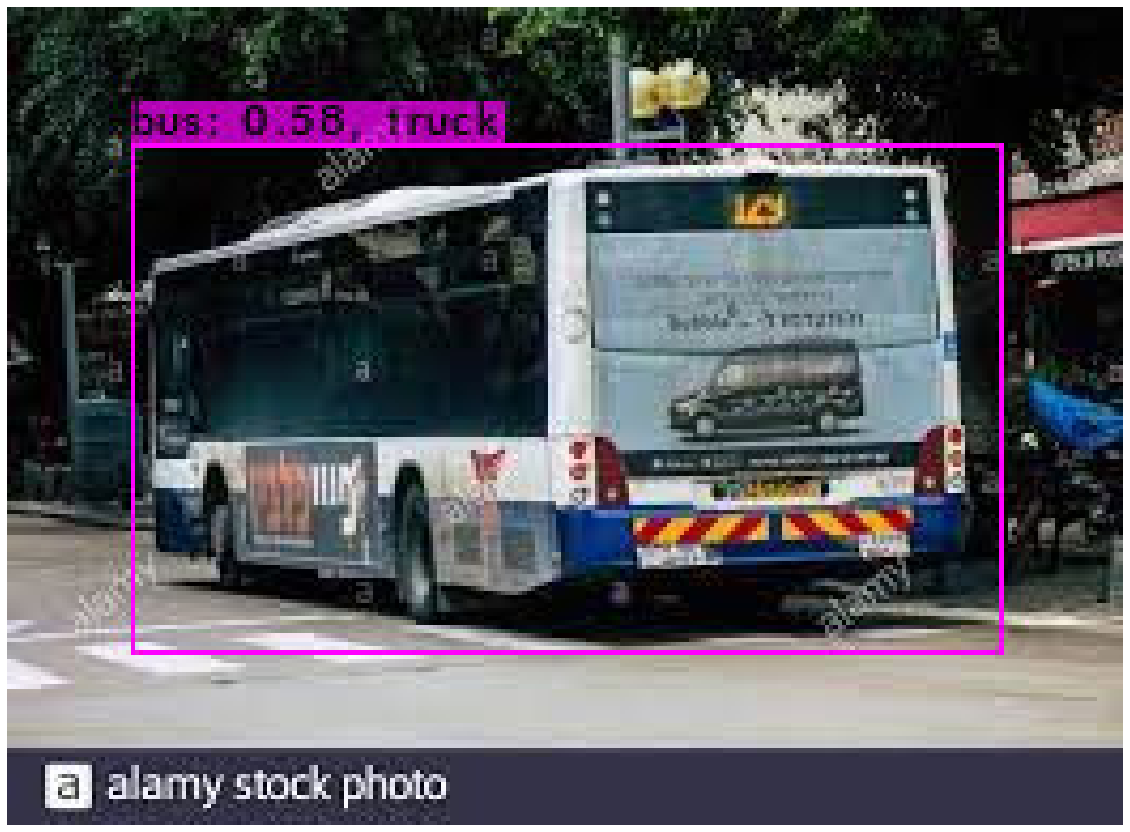

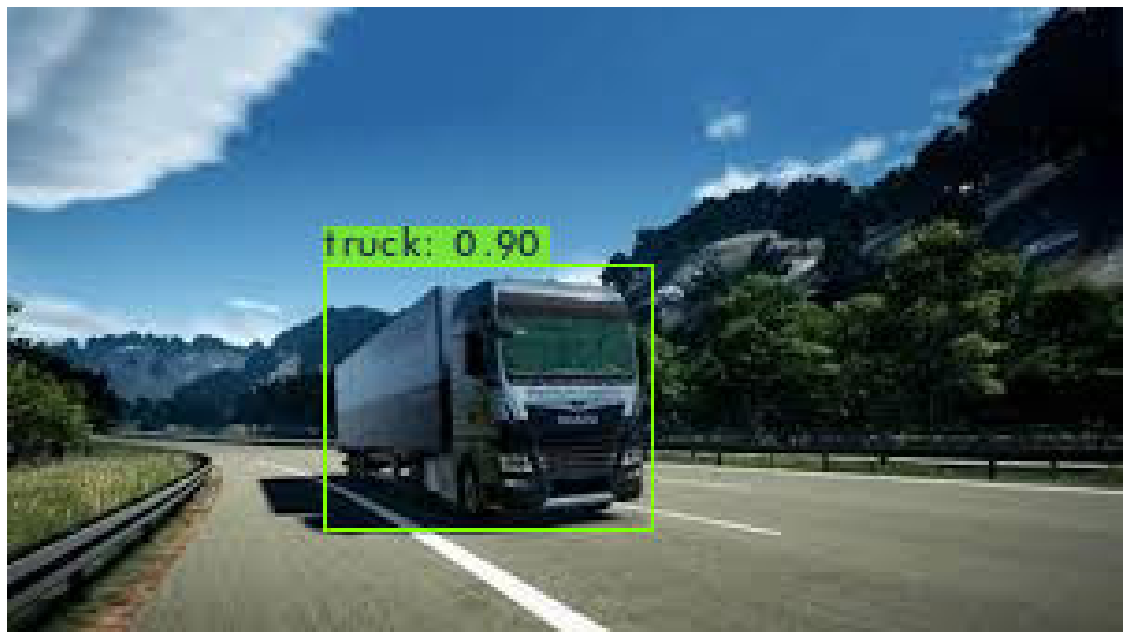

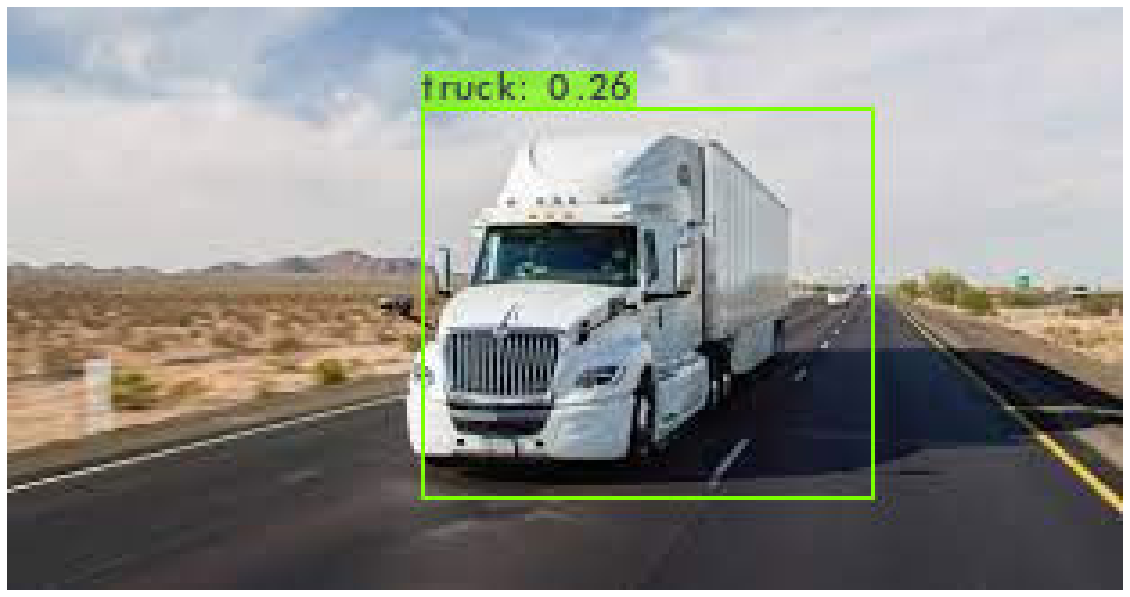

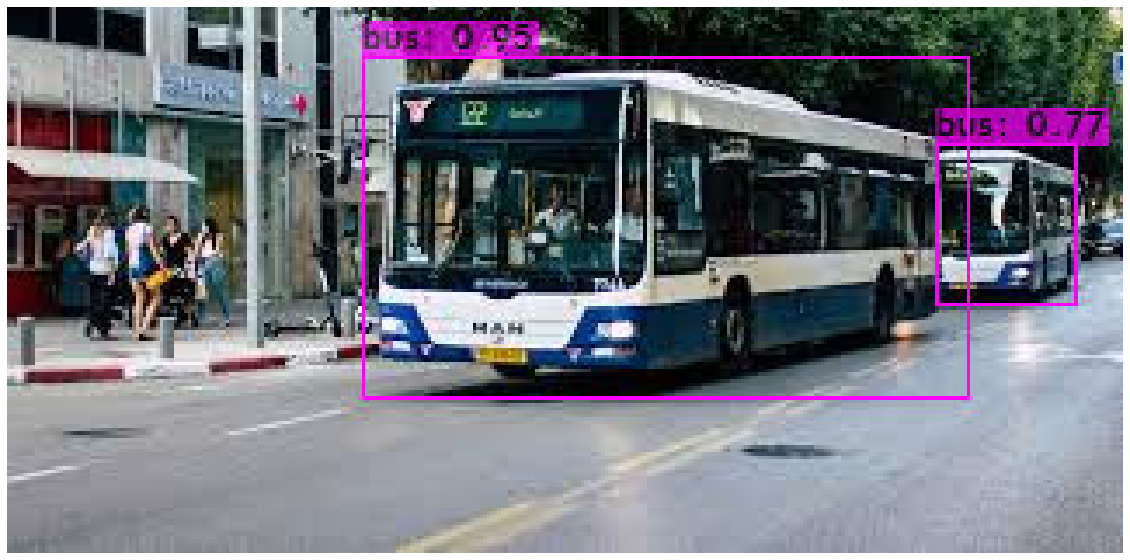

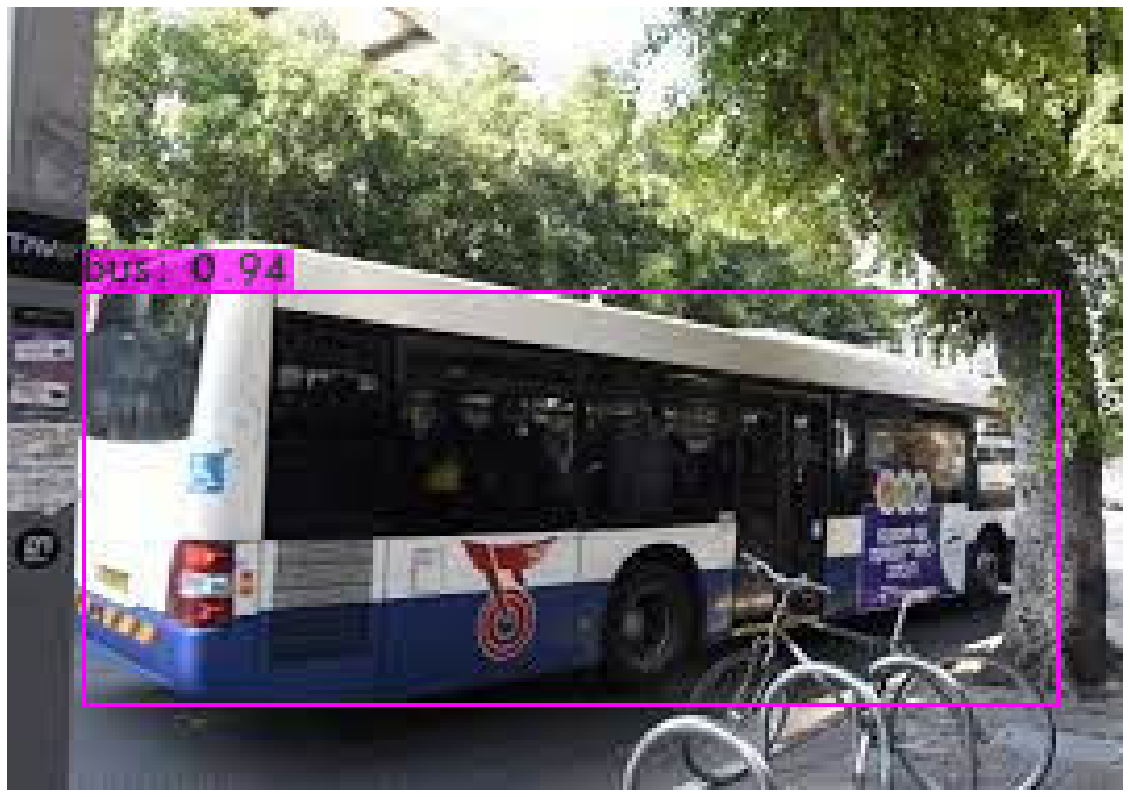

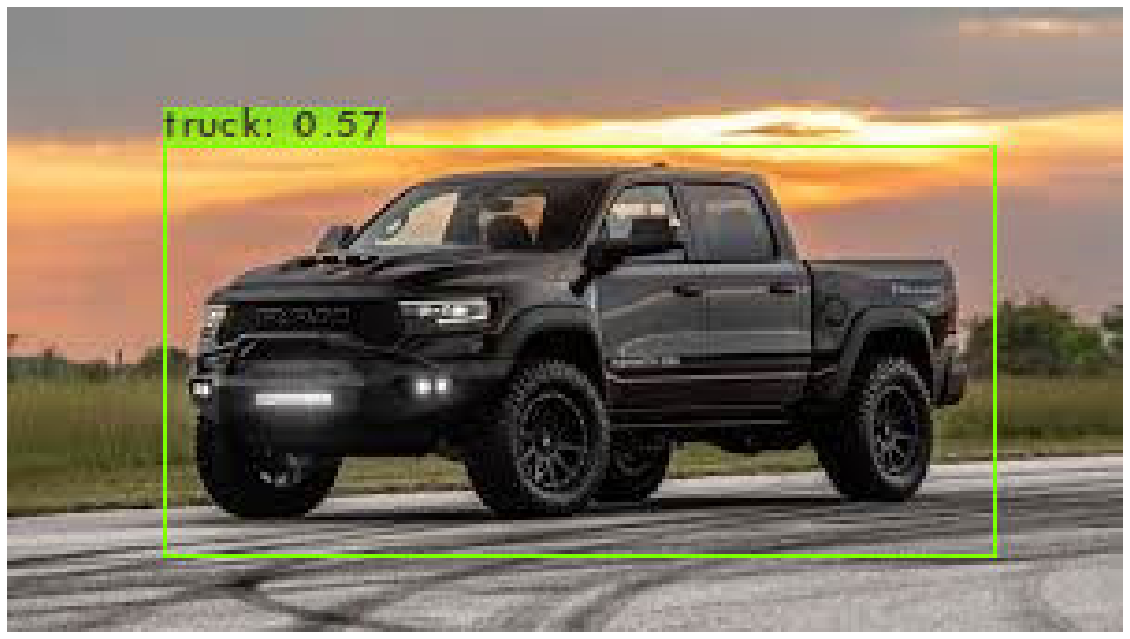

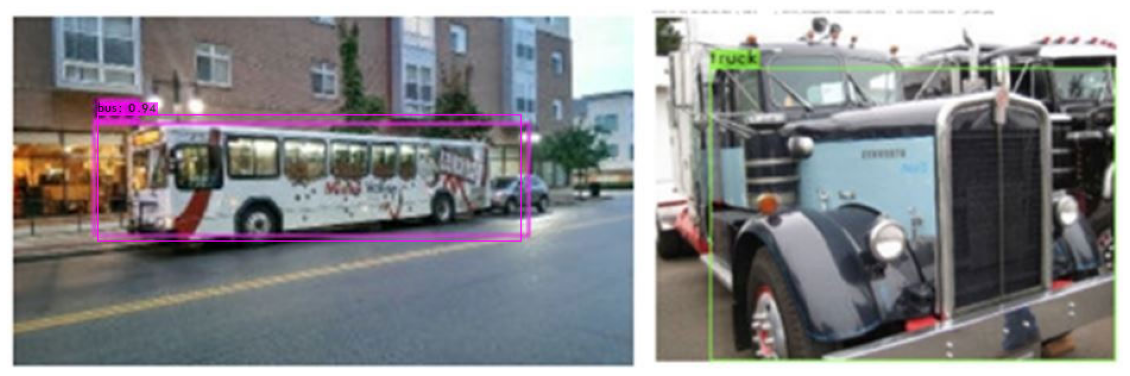

In [11]:
from torch_snippets import Glob, stem, show, read
# upload your own images to a folder
image_paths = Glob('images-of-trucks-and-busses')
for f in image_paths:
    !./darknet detector test data/obj.data cfg/yolov4-tiny-bus-trucks.cfg\
    backup/yolov4-tiny-bus-trucks_4000.weights {f}
    !mv predictions.jpg {stem(f)}_pred.jpg

for i in Glob('*_pred.jpg', silent=True):
    show(read(i, 1), sz=20)

In [9]:
ls

3rdparty/                         json_mjpeg_streams.sh*
backup/                           LICENSE
build/                            Makefile
build.ps1*                        net_cam_v3.sh*
cfg/                              net_cam_v4.sh*
chart.png                         obj/
chart_yolov4-tiny-bus-trucks.png  open-images-bus-trucks/
cmake/                            open-images-bus-trucks.tar.xz
CMakeLists.txt                    predictions.jpg
darknet*                          README.md
DarknetConfig.cmake.in            results/
darknet_images.py                 scripts/
darknet.py                        src/
darknet_video.py                  vcpkg.json
data/                             video_yolov3.sh*
image_yolov3.sh*                  video_yolov4.sh*
image_yolov4.sh*                  yolov4-tiny.conv.29
include/                          yolov4.weights
